In [1]:
import json
import matplotlib.pyplot as plt
import operator
import os
import sys
import typing
from collections import defaultdict
from scipy import stats
import numpy as np
import pandas as pd
from pathlib import Path

from Bio import SeqIO
 

In [2]:
sys.path.append(str(Path(os.path.dirname(os.getcwd())).parent))

In [3]:
from generate_summary_file import generate_summary
from input_testing_data.generate_input_testing_data_for_modules import generate_testing_data_for_ecoli_and_bacillus
from modules.main import run_modules
from modules import shared_functions_and_vars

In [4]:
def run_single_method_for_orf_sequence(optimization_method: str,
                                       is_ecoli_optimized: bool,
                                       orf_sequence: typing.Optional[str] = None,
                                       orf_sequence_file: typing.Optional[str] = None,
                                       output_path: typing.Optional[str] = None,
                                       optimization_cub_index: str = "CAI",
                                       tuning_param: float = 0.5,
                                       should_use_mrna_levels = True):
    default_user_inp_raw = generate_testing_data_for_ecoli_and_bacillus(
        optimization_method=optimization_method,
        optimization_cub_index=optimization_cub_index,
        clusters_count=1,
        tuning_param=tuning_param,
        is_ecoli_optimized=is_ecoli_optimized,
        sequence=orf_sequence,
        sequence_file_path=orf_sequence_file,
        output_path=os.path.join("results", output_path),
        should_use_mrna_levels=should_use_mrna_levels,
    )
    return run_modules(default_user_inp_raw)

In [5]:
def run_all_methods(orf_sequence = None, orf_sequence_file = None, output_path = None, tuning_param: int = 0.5, should_use_mrna_levels: bool = True):
    for optimization_method in [
        "single_codon_ratio",
        "single_codon_diff",
        "single_codon_weakest_link",
        # "zscore_single_aa_ratio",
        "zscore_bulk_aa_ratio",
        # "zscore_single_aa_diff",
        "zscore_bulk_aa_diff",
        # "zscore_single_aa_weakest_link",
        "zscore_bulk_aa_weakest_link",
    ]:
        for optimization_cub_index in ["CAI", "tAI"]:
            for direction in [True, False]:
                run_single_method_for_orf_sequence(optimization_method=optimization_method,
                                                   optimization_cub_index=optimization_cub_index,
                                                   is_ecoli_optimized=direction,
                                                   orf_sequence=orf_sequence,
                                                   orf_sequence_file=orf_sequence_file,
                                                   output_path=output_path,
                                                   tuning_param=tuning_param,
                                                   should_use_mrna_levels=should_use_mrna_levels)

In [6]:
def generate_sequences_fasta_file(root_dir) -> None:
    filename = "run_summary.json"

    sequences = []
    sequences_names = []
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file == filename:
                directory_name = Path(root).name
                file_path = os.path.join(root, file)
                with open(file_path, "r") as summary_file:
                    results_json = json.load(summary_file)

                seq = results_json["evaluation"]["final_sequence"]
                sequences.append(seq)
                sequences_names.append(directory_name[:-5])

    shared_functions_and_vars.write_fasta(os.path.join(root_dir, "mcherry_variants"), sequences, sequences_names)

In [7]:
def calculate_codon_frequencies(referece_cds: typing.Sequence[str]):
    codons_counter = defaultdict(int)
    
    for cds in referece_cds:
        if len(cds) % 3 != 0:
            continue
        for i in range(0, len(cds), 3):
            codon = cds[i:i+3]
            codons_counter[codon] += 1
    
    # Calculate relative frequncies

    for amino_acid, codons in shared_functions_and_vars.synonymous_codons.items():
        total_amino_acid_codons = 0
        for amino_acid_codon in codons:
            total_amino_acid_codons += codons_counter[amino_acid_codon]
        
        # In case a certain amino acid is missing from the reference cds collection, no need to normalize
        if total_amino_acid_codons == 0:
            continue
        
        for amino_acid_codon in codons:
            codons_counter[amino_acid_codon] /= total_amino_acid_codons
    
    df_dict = {"codon": list(codons_counter.keys()), "amino_acid": [shared_functions_and_vars.nt_to_aa[codon] for codon in codons_counter.keys()], "frequency": list(codons_counter.values())}
    
    return pd.DataFrame(df_dict)

In [8]:
def plot_frequency_map(frequency_df):
    sorted_df = frequency_df.sort_values("amino_acid")
    
    plt.rcParams["figure.figsize"] = [10, 5]
    plt.rcParams["figure.autolayout"] = True

    sorted_df.plot("codon", "frequency", kind="bar", color = "b")

In [9]:
def calculate_distance_between_frequencies(first_codons_freq, second_codons_freq):
    return np.linalg.norm(first_codons_freq-second_codons_freq)

In [10]:
def get_variants_df_dict(variants_root_path):
    with open(variants_root_path, "r") as mcherry_variants_fasta_file:
        mcherry_variants_dict = SeqIO.to_dict(SeqIO.parse(mcherry_variants_fasta_file, "fasta"))

    unified_variants_dict = defaultdict(dict)

    for variant_name, variant_seq in mcherry_variants_dict.items():
        if "weakest_link" in variant_name:
            continue
        
        stripped_name = variant_name.replace("_False", "").replace("_True", "").replace("_ecoli_opt", "")
       
        mcherry_variant_codon_frequencies = calculate_codon_frequencies((str(variant_seq.seq),)).sort_values("codon")

        series1 = mcherry_variant_codon_frequencies["frequency"].reset_index(drop=True)
        series2 =  ecoli_codon_frequencies["frequency"].reset_index(drop=True)
        series3 =  bacillus_codon_frequencies["frequency"].reset_index(drop=True)

        ecoli_dist = calculate_distance_between_frequencies(series1, series2)
        bacillus_dist = calculate_distance_between_frequencies(series1, series3)

        if variant_name.endswith("True"):
            unified_variants_dict[stripped_name]["ecoli_dist_for_optimized_ecoli"] = ecoli_dist
            unified_variants_dict[stripped_name]["bacillus_dist_for_optimized_ecoli"] = bacillus_dist
        else:
            unified_variants_dict[stripped_name]["ecoli_dist_for_optimized_bacillus"] = ecoli_dist
            unified_variants_dict[stripped_name]["bacillus_dist_for_optimized_bacillus"] = bacillus_dist

    df_dict = defaultdict(list)
    for variant_name in unified_variants_dict.keys():
        df_dict["variant"].append(variant_name)
        df_dict["ecoli_dist_for_original_mcherry"].append(original_ecoli_dist)
        df_dict["ecoli_dist_for_optimized_ecoli"].append(unified_variants_dict[variant_name]["ecoli_dist_for_optimized_ecoli"])
        df_dict["ecoli_dist_for_optimized_bacillus"].append(unified_variants_dict[variant_name]["ecoli_dist_for_optimized_bacillus"])

        df_dict["bacillus_dist_for_original_mcherry"].append(original_bacillus_dist)
        df_dict["bacillus_dist_for_optimized_ecoli"].append(unified_variants_dict[variant_name]["bacillus_dist_for_optimized_ecoli"])
        df_dict["bacillus_dist_for_optimized_bacillus"].append(unified_variants_dict[variant_name]["bacillus_dist_for_optimized_bacillus"])
    
    return df_dict

In [11]:
def get_codon_frequencies_df_dict(variants_root_path):
    with open(variants_root_path, "r") as mcherry_variants_fasta_file:
        mcherry_variants_dict = SeqIO.to_dict(SeqIO.parse(mcherry_variants_fasta_file, "fasta"))

    unified_variants_dict = defaultdict(dict)

    for variant_name, variant_seq in mcherry_variants_dict.items():
        if "weakest_link" in variant_name:
            continue
        
        stripped_name = variant_name.replace("_False", "").replace("_True", "").replace("_ecoli_opt", "")
       
        mcherry_variant_codon_frequencies = calculate_codon_frequencies((str(variant_seq.seq),)).sort_values("codon")
        
        return mcherry_variant_codon_frequencies 
    
        series1 = mcherry_variant_codon_frequencies["frequency"].reset_index(drop=True)
        
        if variant_name.endswith("True"):
            unified_variants_dict[stripped_name]["codon_frequencies_for_optimized_ecoli"] = mcherry_variant_codon_frequencies
        else:
            unified_variants_dict[stripped_name]["codon_frequencies_for_optimized_bacillus"] = mcherry_variant_codon_frequencies

    df_dict = defaultdict(list)
    for variant_name in unified_variants_dict.keys():
        df_dict["variant"].append(variant_name)
        df_dict["codon_frequencies_for_optimized_ecoli"].append(unified_variants_dict[variant_name]["codon_frequencies_for_optimized_ecoli"])
        df_dict["codon_frequencies_for_optimized_bacillus"].append(unified_variants_dict[variant_name]["codon_frequencies_for_optimized_bacillus"])
    
    return df_dict

In [12]:
def get_cub_score_df_dict(root_dir) -> None:
    filename = "run_summary.json"
    
    unified_variants_dict = defaultdict(dict)
    
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file == filename:
                directory_name = Path(root).name
                file_path = os.path.join(root, file)
                with open(file_path, "r") as summary_file:
                    results_json = json.load(summary_file)
                
                is_cai = directory_name.startswith("CAI")
                organisms = results_json["evaluation"]["organisms"]
                for organism in organisms:
                    if organism["name"] == "Bacillus subtilis":
                        if is_cai:
                            bacillus_initial_score = organism["cai_initial_score"]
                            bacillus_final_score = organism["cai_final_score"]
                        else:
                            bacillus_initial_score = organism["tai_initial_score"]
                            bacillus_final_score = organism["tai_final_score"]
                    else:
                        if is_cai:
                            ecoli_initial_score = organism["cai_initial_score"]
                            ecoli_final_score = organism["cai_final_score"]
                        else:
                            ecoli_initial_score = organism["tai_initial_score"]
                            ecoli_final_score = organism["tai_final_score"]
                            
                
                variant_name = directory_name[:-5]
                stripped_name = variant_name.replace("_False", "").replace("_True", "").replace("_ecoli_opt", "")
                
                if "weakest_link" in variant_name:
                    continue
                
                if variant_name.endswith("True"):
                    suffix = "_for_optimized_ecoli"
                else:
                    suffix = "_for_optimized_bacillus"
                
                unified_variants_dict[stripped_name]["bacillus_initial_score" + suffix] = bacillus_initial_score
                unified_variants_dict[stripped_name]["bacillus_final_score" + suffix] = bacillus_final_score
                unified_variants_dict[stripped_name]["ecoli_initial_score" + suffix] = ecoli_initial_score
                unified_variants_dict[stripped_name]["ecoli_final_score" + suffix] = ecoli_final_score
                unified_variants_dict[stripped_name]["evaluation_score" + suffix] = results_json["evaluation"]["average_distance_score"]
                
    
    df_dict = defaultdict(list)
    for variant_name in unified_variants_dict.keys():
        df_dict["variant"].append(variant_name)
        df_dict["ecoli_initial_score_for_optimized_ecoli"].append(unified_variants_dict[variant_name]["ecoli_initial_score_for_optimized_ecoli"])
        df_dict["ecoli_final_score_for_optimized_ecoli"].append(unified_variants_dict[variant_name]["ecoli_final_score_for_optimized_ecoli"])
        df_dict["ecoli_initial_score_for_optimized_bacillus"].append(unified_variants_dict[variant_name]["ecoli_initial_score_for_optimized_bacillus"])
        df_dict["ecoli_final_score_for_optimized_bacillus"].append(unified_variants_dict[variant_name]["ecoli_final_score_for_optimized_bacillus"])
        df_dict["bacillus_initial_score_for_optimized_ecoli"].append(unified_variants_dict[variant_name]["bacillus_initial_score_for_optimized_ecoli"])
        df_dict["bacillus_final_score_for_optimized_ecoli"].append(unified_variants_dict[variant_name]["bacillus_final_score_for_optimized_ecoli"])
        df_dict["bacillus_initial_score_for_optimized_bacillus"].append(unified_variants_dict[variant_name]["bacillus_initial_score_for_optimized_bacillus"])
        df_dict["bacillus_final_score_for_optimized_bacillus"].append(unified_variants_dict[variant_name]["bacillus_final_score_for_optimized_bacillus"])
        df_dict["evaluation_score_for_optimized_ecoli"].append(unified_variants_dict[variant_name]["evaluation_score_for_optimized_ecoli"])
        df_dict["evaluation_score_for_optimized_bacillus"].append(unified_variants_dict[variant_name]["evaluation_score_for_optimized_bacillus"])
    

    return df_dict

In [13]:
def get_cub_weights(organism_summary_file_path: str):
    with open(organism_summary_file_path, "r") as organism_summary_file:
        organism_summary = json.load(organism_summary_file)
    
    cai_profile = organism_summary["cai_weights"]
    tai_profile = organism_summary["tai_weights"]
    
    return cai_profile, tai_profile

In [14]:
def get_cub_scores(organism_summary_file_path: str):
    with open(organism_summary_file_path, "r") as organism_summary_file:
        organism_summary = json.load(organism_summary_file)
    
    cai_scores = organism_summary["cai_scores"]
    tai_scores = organism_summary["tai_scores"]
    
    return cai_scores, tai_scores

In [15]:
def get_estimated_expression(endogenous_genes_fasta_file_path, mrna_levels_file_path):
    expression_df = pd.read_csv(mrna_levels_file_path)
    gene_name_to_mrna_level = {}
    for _, pair in enumerate(zip(expression_df.gene.to_list(), expression_df.mRNA_level.to_list())):
        measured_gene_name, expression_level = pair
        try:
            gene_name_to_mrna_level[measured_gene_name.lower()] = float(expression_level)
        except:
            continue
            
    with open(endogenous_genes_fasta_file_path, "r") as endogenous_genes_fasta_file:
        endogenous_genes_dict = SeqIO.to_dict(SeqIO.parse(endogenous_genes_fasta_file, "fasta"))
        
    estimated_expression = {description: {"cds": cds, "mrna_level": gene_name_to_mrna_level[description.split("|")[0].lower()]}  for description, cds in endogenous_genes_dict.items() if description.split("|")[0].lower() in gene_name_to_mrna_level}
    return estimated_expression

In [16]:
def get_highly_expressed_genes(endogenous_genes_fasta_file_path, mrna_levels_file_path):
    estimated_expression = get_estimated_expression(endogenous_genes_fasta_file_path=endogenous_genes_fasta_file_path, mrna_levels_file_path=mrna_levels_file_path)
    estimated_expression_threshold = 0.15
    sorted_estimated_expression = dict(
        sorted(estimated_expression.items(), key=lambda x: x[1]["mrna_level"], reverse=True)
    )
    highly_expressed_genes_count = round(len(sorted_estimated_expression) * estimated_expression_threshold)
    
    highly_expressed_names = list(sorted_estimated_expression.keys())[:highly_expressed_genes_count]
    highly_expressed_genes = {key: value for key, value in estimated_expression.items() if key in highly_expressed_names}
    return highly_expressed_genes

In [17]:
base_path = os.path.join(Path(os.getcwd()).parent.resolve(), "example_data")
macherry_file_path = os.path.join(base_path, "mCherry_original.fasta")

In [18]:
with open(macherry_file_path, "r") as mcherry_fasta_file:
    mcherry_dict = SeqIO.to_dict(SeqIO.parse(mcherry_fasta_file, "fasta"))

original_mcherry_seq = list(mcherry_dict.values())[0].seq

# Generating mcherry variants

### Tuning parameter = 0.5

In [19]:
# run_all_methods(orf_sequence_file=macherry_file_path, output_path="mcherry")

In [20]:
mcherry_root_dir = r"C:\projects\Igem_TAU_2021_moran\analysis\orf_model_analysis\results\mcherry"
mcherry_variants_file = os.path.join(mcherry_root_dir, "mcherry_variants.fasta")
generate_sequences_fasta_file(mcherry_root_dir)
generate_summary(results_directory=mcherry_root_dir)

### Tuning parameter = 1 (optimizing only wanted host and neglecting unwanted host)

In [21]:
# run_all_methods(orf_sequence_file=macherry_file_path, output_path="mcherry_greater_alpha", tuning_param=1)

In [22]:
mcherry_greater_alpha_root_dir = r"C:\projects\Igem_TAU_2021_moran\analysis\orf_model_analysis\results\mcherry_greater_alpha"
mcherry_greater_alpha_variants_file = os.path.join(mcherry_greater_alpha_root_dir, "mcherry_variants.fasta")
generate_sequences_fasta_file(mcherry_greater_alpha_root_dir)
generate_summary(results_directory=mcherry_greater_alpha_root_dir)

### Tuning parameter = 0 (de-optimizing uwanted host and neglecting wanted host)

In [23]:
# run_all_methods(orf_sequence_file=macherry_file_path, output_path="mcherry_lower_alpha", tuning_param=0)

In [24]:
mcherry_lower_alpha_root_dir = r"C:\projects\Igem_TAU_2021_moran\analysis\orf_model_analysis\results\mcherry_lower_alpha"
mcherry_lower_alpha_variants_file = os.path.join(mcherry_lower_alpha_root_dir, "mcherry_variants.fasta")
generate_sequences_fasta_file(mcherry_lower_alpha_root_dir)
generate_summary(results_directory=mcherry_lower_alpha_root_dir)

### Using ribosomal genes as highly expressed genes (instead of mRNA levels)

In [25]:
# run_all_methods(orf_sequence_file=macherry_file_path, output_path="ribosomal", should_use_mrna_levels=False)

In [26]:
mcherry_ribosomal_root_dir = r"C:\projects\Igem_TAU_2021_moran\analysis\orf_model_analysis\results\ribosomal"
mcherry_ribosomal_variants_file = os.path.join(mcherry_ribosomal_root_dir, "mcherry_variants.fasta")
generate_sequences_fasta_file(mcherry_ribosomal_root_dir)
generate_summary(results_directory=mcherry_ribosomal_root_dir)

# CUB and codon frequencies of Bacillus and E.coli

In [27]:
bacillus_endogenous_genes_fasta_file_path = r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\Bacillus-subtilis.fasta"
ecoli_endogenous_genes_fasta_file_path =  r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\Escherichia-coli.fasta"

In [28]:
with open(bacillus_endogenous_genes_fasta_file_path, "r") as bacillus_endogenous_genes_fasta_file:
    bacillus_endogenous_genes_dict = SeqIO.to_dict(SeqIO.parse(bacillus_endogenous_genes_fasta_file, "fasta"))

bacillus_codon_frequencies = calculate_codon_frequencies([str(gene.seq) for gene in bacillus_endogenous_genes_dict.values()])
bacillus_codon_frequencies = bacillus_codon_frequencies.sort_values("codon")

with open(ecoli_endogenous_genes_fasta_file_path, "r") as ecoli_endogenous_genes_fasta_file:
    ecoli_endogenous_genes_dict = SeqIO.to_dict(SeqIO.parse(ecoli_endogenous_genes_fasta_file, "fasta"))

ecoli_codon_frequencies = calculate_codon_frequencies([str(gene.seq) for gene in ecoli_endogenous_genes_dict.values()])
ecoli_codon_frequencies = ecoli_codon_frequencies.sort_values("codon")

In [29]:
bacillus_codon_frequencies

,codon,amino_acid,frequency
14,AAA,K,0.701698
8,AAC,N,0.434440
15,AAG,K,0.298302
2,AAT,N,0.565560
28,ACA,T,0.412248
...,...,...,...
63,TGT,C,0.453827
4,TTA,L,0.198508
50,TTC,F,0.315180
16,TTG,L,0.159242


In [30]:
ecoli_codon_frequencies

,codon,amino_acid,frequency
1,AAA,K,0.766500
9,AAC,N,0.551734
16,AAG,K,0.233500
20,AAT,N,0.448266
7,ACA,T,0.130030
...,...,...,...
54,TGT,C,0.443173
37,TTA,L,0.129801
17,TTC,F,0.426216
15,TTG,L,0.128096


In [31]:
ecoli_highly_expressed_genes = get_highly_expressed_genes(endogenous_genes_fasta_file_path=ecoli_endogenous_genes_fasta_file_path,
                                                          mrna_levels_file_path=r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\ecoli_mrna_level.csv")
ecoli_highly_expressed_genes_codon_frequencies = calculate_codon_frequencies([str(gene["cds"].seq) for gene in ecoli_highly_expressed_genes.values()])
ecoli_highly_expressed_genes_codon_frequencies = ecoli_highly_expressed_genes_codon_frequencies.sort_values("codon")

bacillus_highly_expressed_genes = get_highly_expressed_genes(endogenous_genes_fasta_file_path=bacillus_endogenous_genes_fasta_file_path,
                                                          mrna_levels_file_path=r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\bacillus_mrna_level.csv")
bacillus_highly_expressed_genes_codon_frequencies = calculate_codon_frequencies([str(gene["cds"].seq) for gene in bacillus_highly_expressed_genes.values()])
bacillus_highly_expressed_genes_codon_frequencies = bacillus_highly_expressed_genes_codon_frequencies.sort_values("codon")

Run only once - for generating both tai and cai weights dict:

In [32]:
from modules.user_IO.user_input import UserInputModule
from modules.run_summary import RunSummary

from generate_summary_file import generate_summary
from input_testing_data.generate_input_testing_data_for_modules import generate_testing_data_for_ecoli_and_bacillus
from modules.main import run_modules
from modules import shared_functions_and_vars

default_user_inp_raw = generate_testing_data_for_ecoli_and_bacillus(
    optimization_method="single_codon_diff",
    optimization_cub_index="max_CAI_tAI",
    clusters_count=1,
    tuning_param=0.5,
    is_ecoli_optimized=True,
    sequence=original_mcherry_seq,
    output_path="results",
    should_use_mrna_levels=False,
)

UserInputModule.run_module(default_user_inp_raw, RunSummary())

##########################
# USER INPUT INFORMATION #
##########################

Information about Escherichia coli:
Organism is optimized
Number of genes: 4310
Found 90 ribosomal proteins in input genome.
Estimated expression dictionary does not have enough expression levels. CAI will be calculated from a reference set of ribosomal proteins or the entire genome.
CAI will be calculated from a reference set of ribosomal proteins.
tGCN values were found, tAI profile was calculated
name=Escherichia coli, cai_std=0.09127335979563275, cai_avg=0.5958181249689964

Information about Bacillus subtilis:
Organism is deoptimized
Number of genes: 4311
Found 98 ribosomal proteins in input genome.
Estimated expression dictionary does not have enough expression levels. CAI will be calculated from a reference set of ribosomal proteins or the entire genome.
CAI will be calculated from a reference set of ribosomal proteins.
tGCN values were found, tAI profile was calculated
name=Bacillus subtilis, cai_s

UserInput(organisms=[<modules.models.Organism object at 0x1D4A61D0>, <modules.models.Organism object at 0x1D444CB0>], sequence=Seq('ATGGTTTCCAAGGGCGAGGAGGATAACATGGCTATCATTAAAGAGTTCATGCGC...TAA'), output_path='results\\max_CAI_tAI_single_codon_diff_ecoli_opt_True_8517', tuning_parameter=0.5, clusters_count=1, optimization_method=<OptimizationMethod.single_codon_diff: 'single_codon_diff'>, optimization_cub_index=<OptimizationCubIndex.max_codon_trna_adaptation_index: 'max_CAI_tAI'>)

In [33]:
ecoli_cai_weights, ecoli_tai_weights = get_cub_weights(r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\Escherichia-coli_True_parsed.json")
bacillus_cai_weights, bacillus_tai_weights = get_cub_weights(r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\Bacillus-subtilis_False_parsed.json")

In [34]:
codons = ecoli_cai_weights.keys()
weights_df_dict = {
    "codon": codons, 
    "amino_acid": [shared_functions_and_vars.nt_to_aa[k] for k in codons],
    "ecoli_cai_weights": [ecoli_cai_weights[k] for k in codons],
    "ecoli_tai_weights": [ecoli_tai_weights[k] for k in codons],
    "bacillus_cai_weights": [bacillus_cai_weights[k] for k in codons],
    "bacillus_tai_weights": [bacillus_tai_weights[k] for k in codons],
}
weights_dataframe = pd.DataFrame(weights_df_dict)
weights_dataframe.sort_values("amino_acid")
weights_dataframe

,codon,amino_acid,ecoli_cai_weights,ecoli_tai_weights,bacillus_cai_weights,bacillus_tai_weights
0,TTT,F,0.735593,0.237558,1.000000,0.357989
1,TTC,F,1.000000,0.329942,0.551069,0.497207
2,TTA,L,0.095017,0.165698,0.670034,0.452514
3,TTG,L,0.137891,0.116846,0.560045,0.151955
4,TCT,S,0.942857,0.246279,1.000000,0.120670
...,...,...,...,...,...,...
59,GGA,G,0.098921,0.214070,1.000000,0.502793
60,GGG,G,0.165468,0.121962,0.427097,0.058603
61,TGA,_,0.189189,0.210904,0.078947,0.177010
62,TAA,_,1.000000,0.210904,1.000000,0.177010


Text(0.7, 0.9, 'r = 0.729')

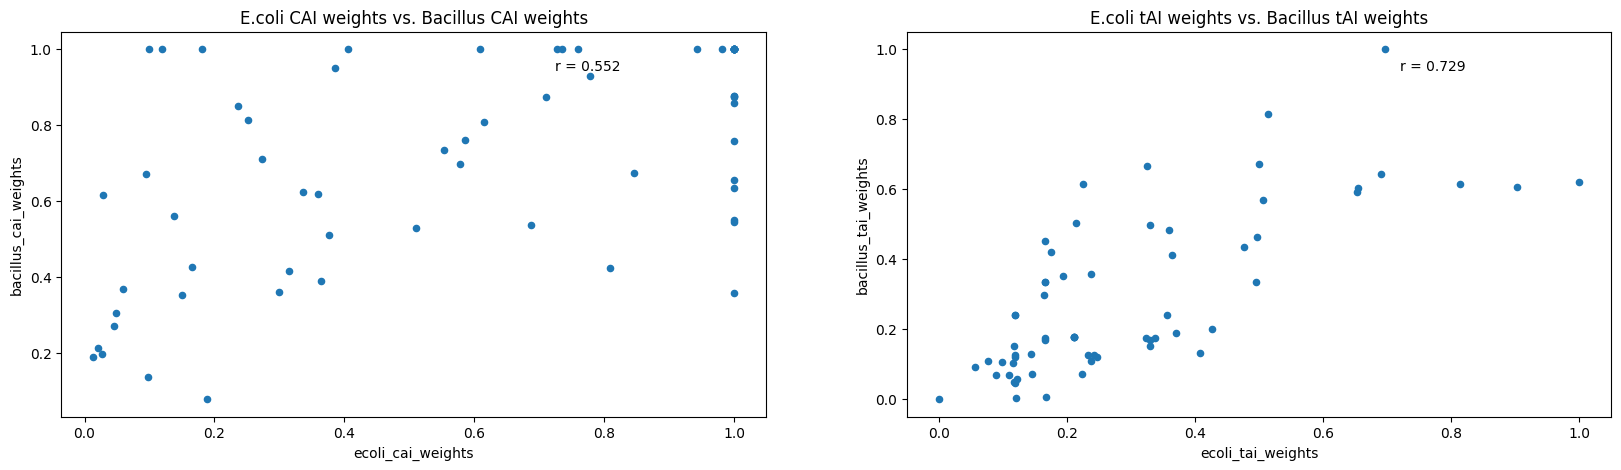

In [35]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(20,5))
scatter = weights_dataframe.plot.scatter(x="ecoli_cai_weights", y="bacillus_cai_weights", title="E.coli CAI weights vs. Bacillus CAI weights", ax=axes[0])
r, p = stats.spearmanr(weights_dataframe["ecoli_cai_weights"], weights_dataframe["bacillus_cai_weights"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = weights_dataframe.plot.scatter(x="ecoli_tai_weights", y="bacillus_tai_weights", title="E.coli tAI weights vs. Bacillus tAI weights", ax=axes[1])
r, p = stats.spearmanr(weights_dataframe["ecoli_tai_weights"], weights_dataframe["bacillus_tai_weights"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

Text(0.7, 0.9, 'r = 0.2582, p=0.039395492076293115')

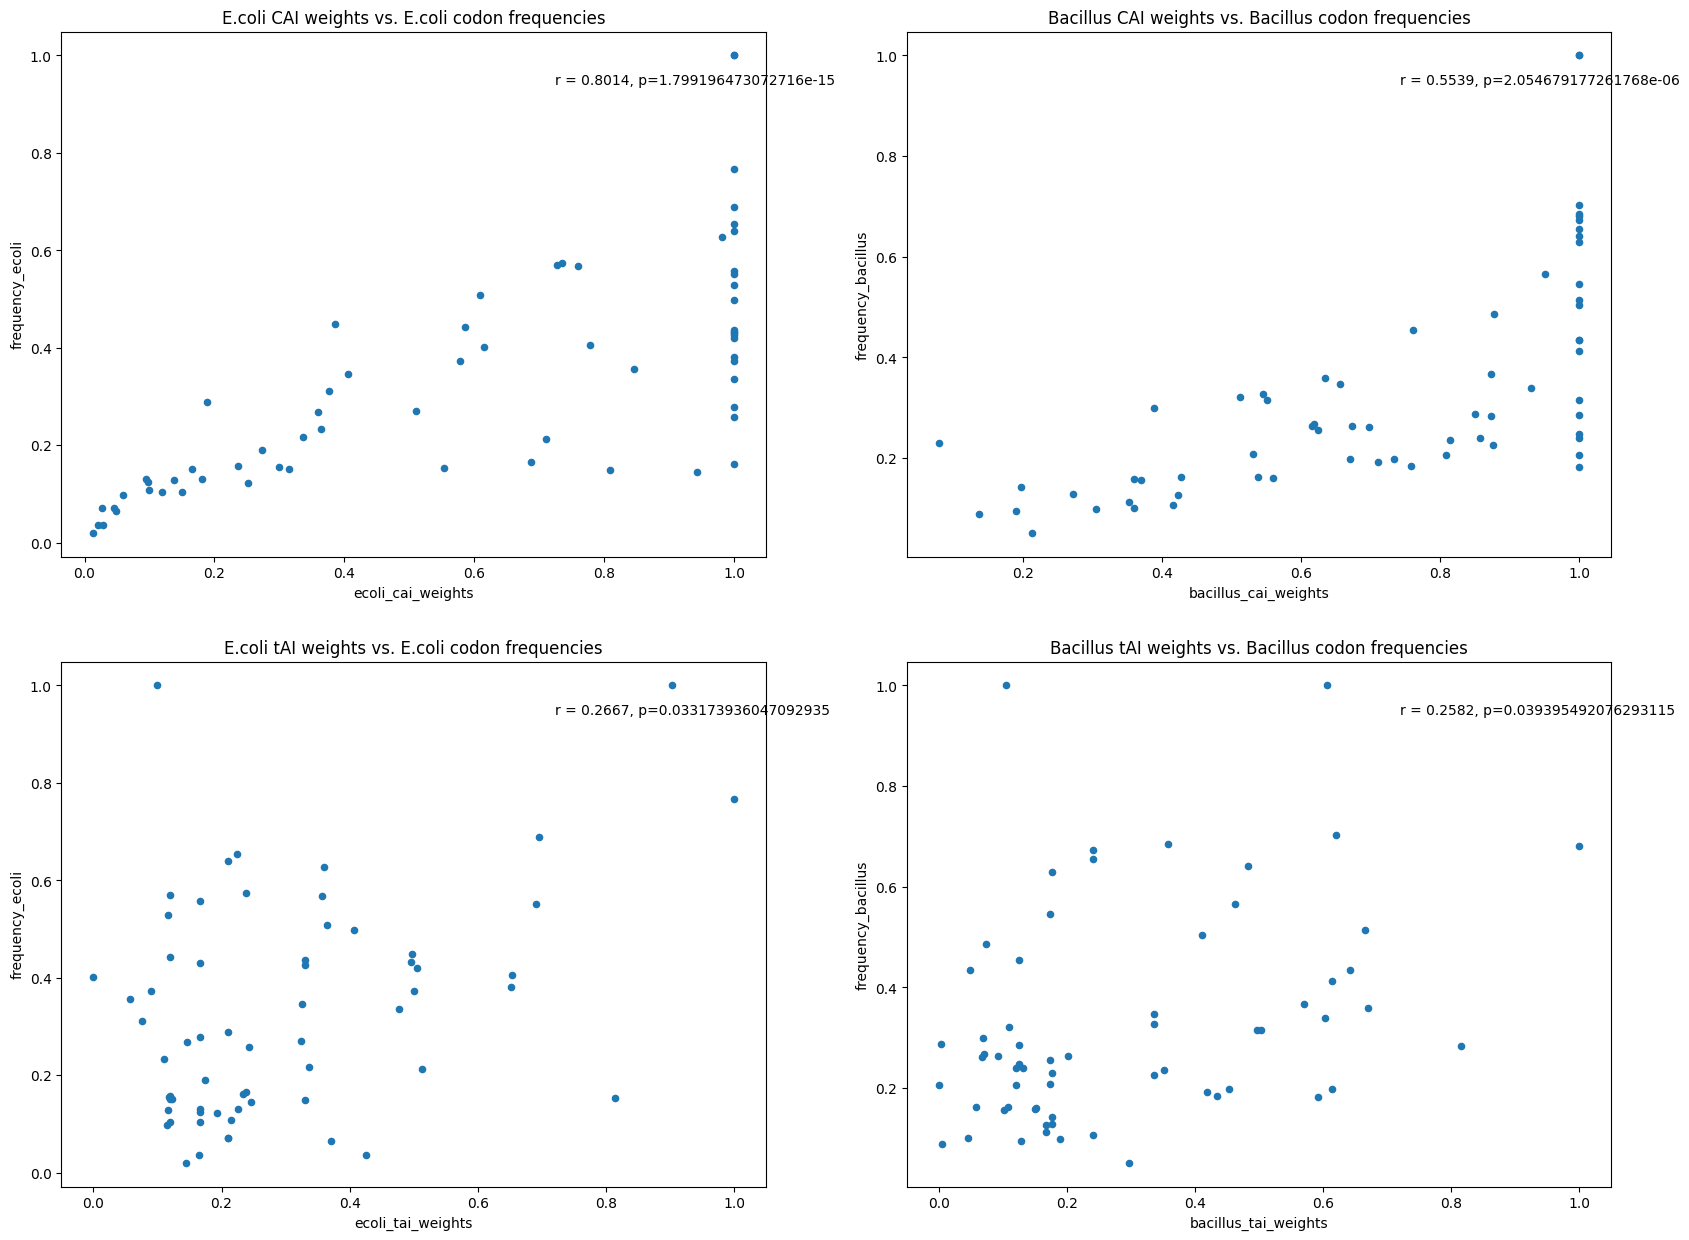

In [36]:
merged_weights_codon_frequencies_df = pd.merge(weights_dataframe, ecoli_codon_frequencies, on='codon', how='inner')
merged_weights_codon_frequencies_df = pd.merge(merged_weights_codon_frequencies_df, bacillus_codon_frequencies, on='codon', how='inner', suffixes=("_ecoli", "_bacillus"))

fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(20,15))
scatter = merged_weights_codon_frequencies_df.plot.scatter(x="ecoli_cai_weights", y="frequency_ecoli", title="E.coli CAI weights vs. E.coli codon frequencies", ax=axes[0,0])
r, p = stats.spearmanr(merged_weights_codon_frequencies_df["ecoli_cai_weights"], merged_weights_codon_frequencies_df["frequency_ecoli"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_weights_codon_frequencies_df.plot.scatter(x="bacillus_cai_weights", y="frequency_bacillus", title="Bacillus CAI weights vs. Bacillus codon frequencies", ax=axes[0,1])
r, p = stats.spearmanr(merged_weights_codon_frequencies_df["ecoli_cai_weights"], merged_weights_codon_frequencies_df["frequency_bacillus"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_weights_codon_frequencies_df.plot.scatter(x="ecoli_tai_weights", y="frequency_ecoli", title="E.coli tAI weights vs. E.coli codon frequencies", ax=axes[1,0])
r, p = stats.spearmanr(merged_weights_codon_frequencies_df["ecoli_tai_weights"], merged_weights_codon_frequencies_df["frequency_ecoli"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_weights_codon_frequencies_df.plot.scatter(x="bacillus_tai_weights", y="frequency_bacillus", title="Bacillus tAI weights vs. Bacillus codon frequencies", ax=axes[1,1])
r, p = stats.spearmanr(merged_weights_codon_frequencies_df["ecoli_tai_weights"], merged_weights_codon_frequencies_df["frequency_bacillus"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

Text(0.7, 0.9, 'r = 0.3076, p=0.013424440494590363')

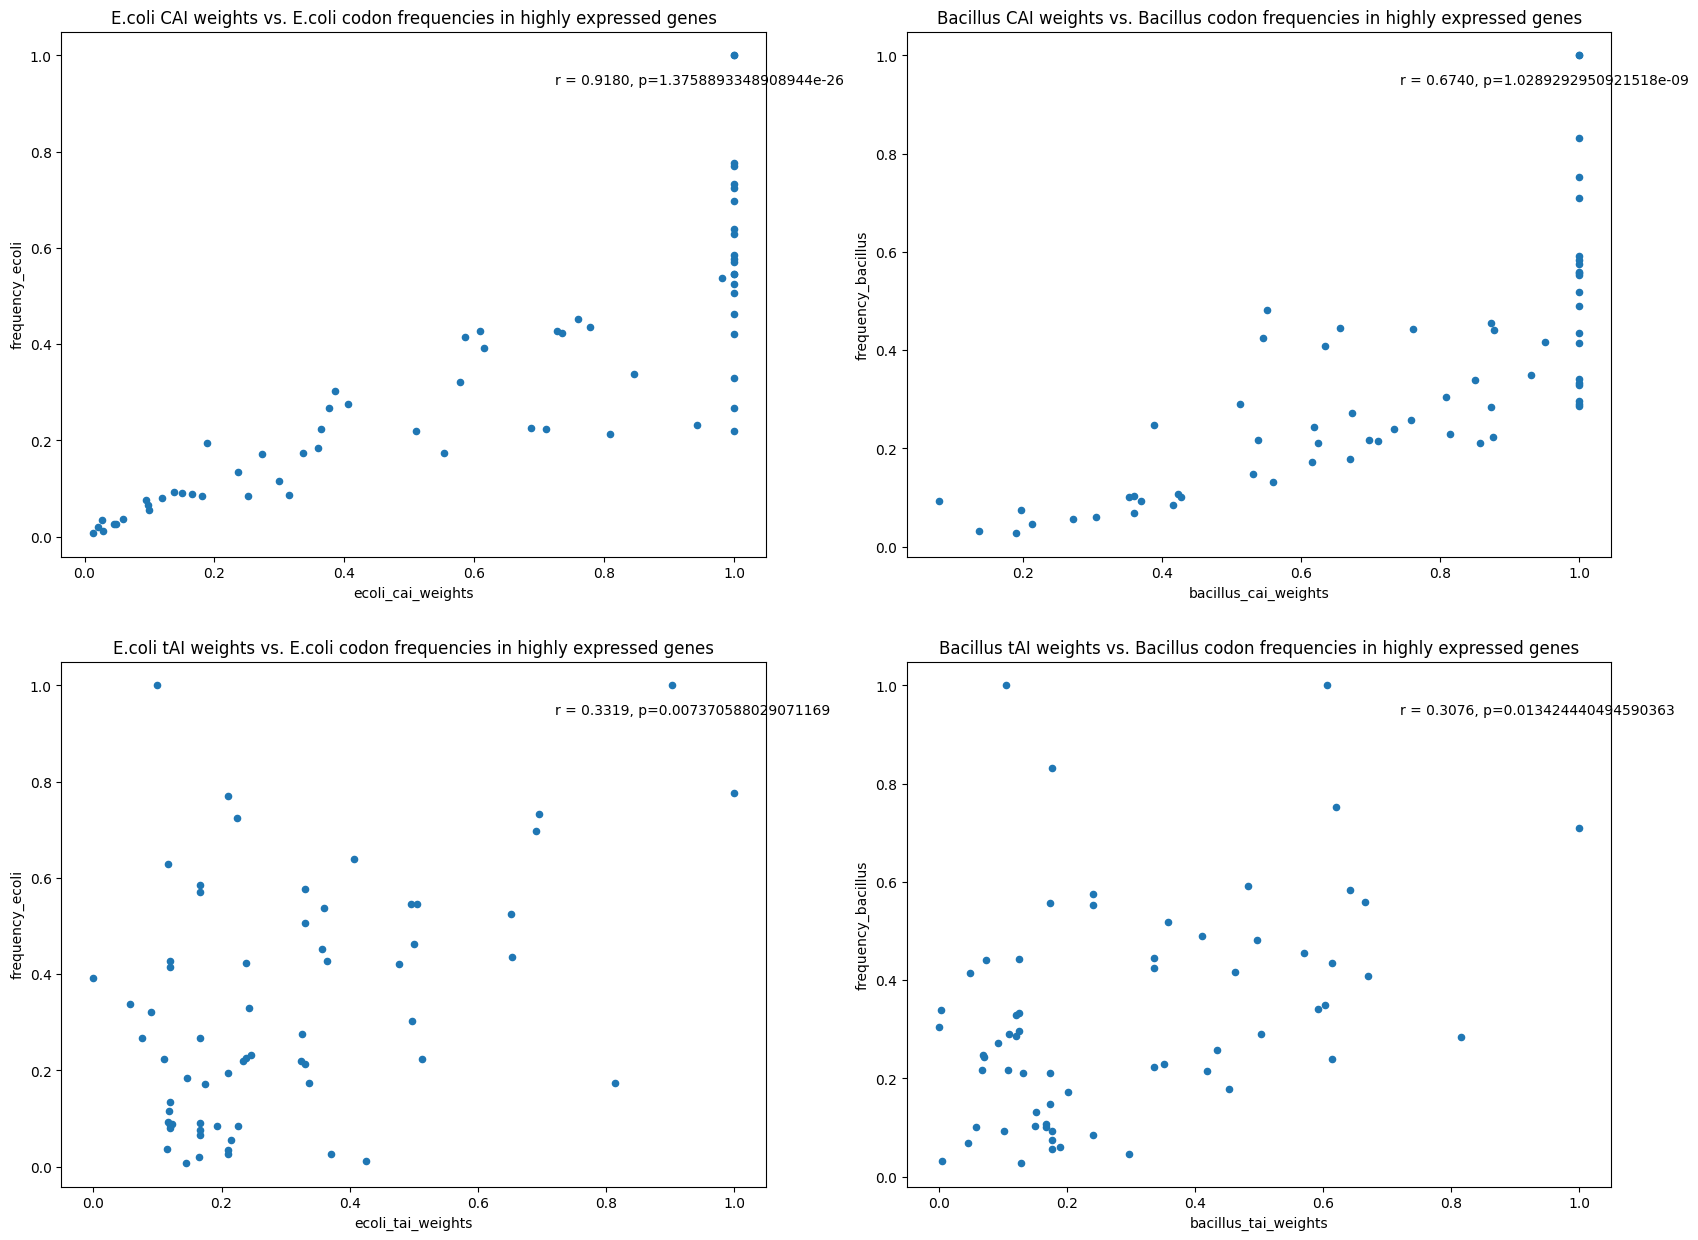

In [37]:
merged_weights_codon_frequencies_df = pd.merge(weights_dataframe, ecoli_highly_expressed_genes_codon_frequencies, on='codon', how='inner')
merged_weights_codon_frequencies_df = pd.merge(merged_weights_codon_frequencies_df, bacillus_highly_expressed_genes_codon_frequencies, on='codon', how='inner', suffixes=("_ecoli", "_bacillus"))

fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(20,15))
scatter = merged_weights_codon_frequencies_df.plot.scatter(x="ecoli_cai_weights", y="frequency_ecoli", title="E.coli CAI weights vs. E.coli codon frequencies in highly expressed genes", ax=axes[0,0])
r, p = stats.spearmanr(merged_weights_codon_frequencies_df["ecoli_cai_weights"], merged_weights_codon_frequencies_df["frequency_ecoli"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_weights_codon_frequencies_df.plot.scatter(x="bacillus_cai_weights", y="frequency_bacillus", title="Bacillus CAI weights vs. Bacillus codon frequencies in highly expressed genes", ax=axes[0,1])
r, p = stats.spearmanr(merged_weights_codon_frequencies_df["ecoli_cai_weights"], merged_weights_codon_frequencies_df["frequency_bacillus"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_weights_codon_frequencies_df.plot.scatter(x="ecoli_tai_weights", y="frequency_ecoli", title="E.coli tAI weights vs. E.coli codon frequencies in highly expressed genes", ax=axes[1,0])
r, p = stats.spearmanr(merged_weights_codon_frequencies_df["ecoli_tai_weights"], merged_weights_codon_frequencies_df["frequency_ecoli"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_weights_codon_frequencies_df.plot.scatter(x="bacillus_tai_weights", y="frequency_bacillus", title="Bacillus tAI weights vs. Bacillus codon frequencies in highly expressed genes", ax=axes[1,1])
r, p = stats.spearmanr(merged_weights_codon_frequencies_df["ecoli_tai_weights"], merged_weights_codon_frequencies_df["frequency_bacillus"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

In [38]:
ecoli_cai_scores, ecoli_tai_scores = get_cub_scores(r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\Escherichia-coli_True_parsed.json")
bacillus_cai_scores, bacillus_tai_scores = get_cub_scores(r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\Bacillus-subtilis_False_parsed.json")

In [39]:
def get_scores(estimated_expression_dict, cai_scores_dict, tai_scores_dict, selected_genes=None):
    all_cds = cai_scores_dict.keys()
    selected_genes = selected_genes or all_cds
    filtered_cds = []
    mrna_levels = []
    for k in all_cds:
        if not any(k.startswith(x) for x in selected_genes):
            continue
        short_name = k.split(" ")[0]
        if short_name in estimated_expression_dict:
            mrna_levels.append(estimated_expression_dict[short_name]["mrna_level"])
            filtered_cds.append(k)

    scores_mrna_levels_df_dict = {
        "gene": filtered_cds, 
        "cai_scores": [cai_scores_dict[k] for k in filtered_cds],
        "tai_scores": [tai_scores_dict[k] for k in filtered_cds],
        "mrna_level": mrna_levels,
    }
    return pd.DataFrame(scores_mrna_levels_df_dict)

Ecoli mrna levels stats:
 records:3215
 min: 2.77694 
 max: 9134.66
 mean: 1076.834258622084
 std: 1335.093916895283
Bacillus mrna levels stats:
 records:1863
 min: 0.1 
 max: 1037.55
 mean: 19.086349973161564
 std: 64.85824879973497


<AxesSubplot:>

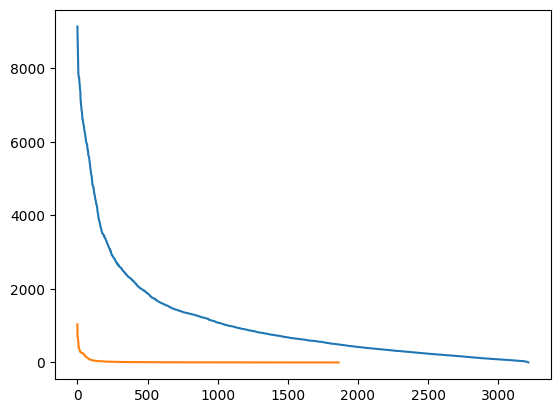

In [40]:
ecoli_estimated_expression = get_estimated_expression(endogenous_genes_fasta_file_path=ecoli_endogenous_genes_fasta_file_path,
                                                      mrna_levels_file_path=r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\ecoli_mrna_level.csv")
ecoli_scores_dataframe =  get_scores(estimated_expression_dict=ecoli_estimated_expression, cai_scores_dict=ecoli_cai_scores, tai_scores_dict=ecoli_tai_scores)
print(f"Ecoli mrna levels stats:\n records:{len(ecoli_scores_dataframe['mrna_level'])}\n min: {ecoli_scores_dataframe['mrna_level'].min()} \n max: {ecoli_scores_dataframe['mrna_level'].max()}\n mean: {ecoli_scores_dataframe['mrna_level'].mean()}\n std: {ecoli_scores_dataframe['mrna_level'].std()}")  
ecoli_scores_dataframe["mrna_level"].sort_values(ascending=False).reset_index(drop=True).plot()

bacillus_estimated_expression = get_estimated_expression(endogenous_genes_fasta_file_path=bacillus_endogenous_genes_fasta_file_path,
                                                      mrna_levels_file_path=r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\bacillus_mrna_level.csv")
bacillus_scores_dataframe =  get_scores(estimated_expression_dict=bacillus_estimated_expression, cai_scores_dict=bacillus_cai_scores, tai_scores_dict=bacillus_tai_scores)
print(f"Bacillus mrna levels stats:\n records:{len(bacillus_scores_dataframe['mrna_level'])}\n min: {bacillus_scores_dataframe['mrna_level'].min()} \n max: {bacillus_scores_dataframe['mrna_level'].max()}\n mean: {bacillus_scores_dataframe['mrna_level'].mean()}\n std: {bacillus_scores_dataframe['mrna_level'].std()}")  
bacillus_scores_dataframe["mrna_level"].sort_values(ascending=False).reset_index(drop=True).plot()

Text(0.7, 0.9, 'r = 0.1135, p=9.047386579590936e-07')

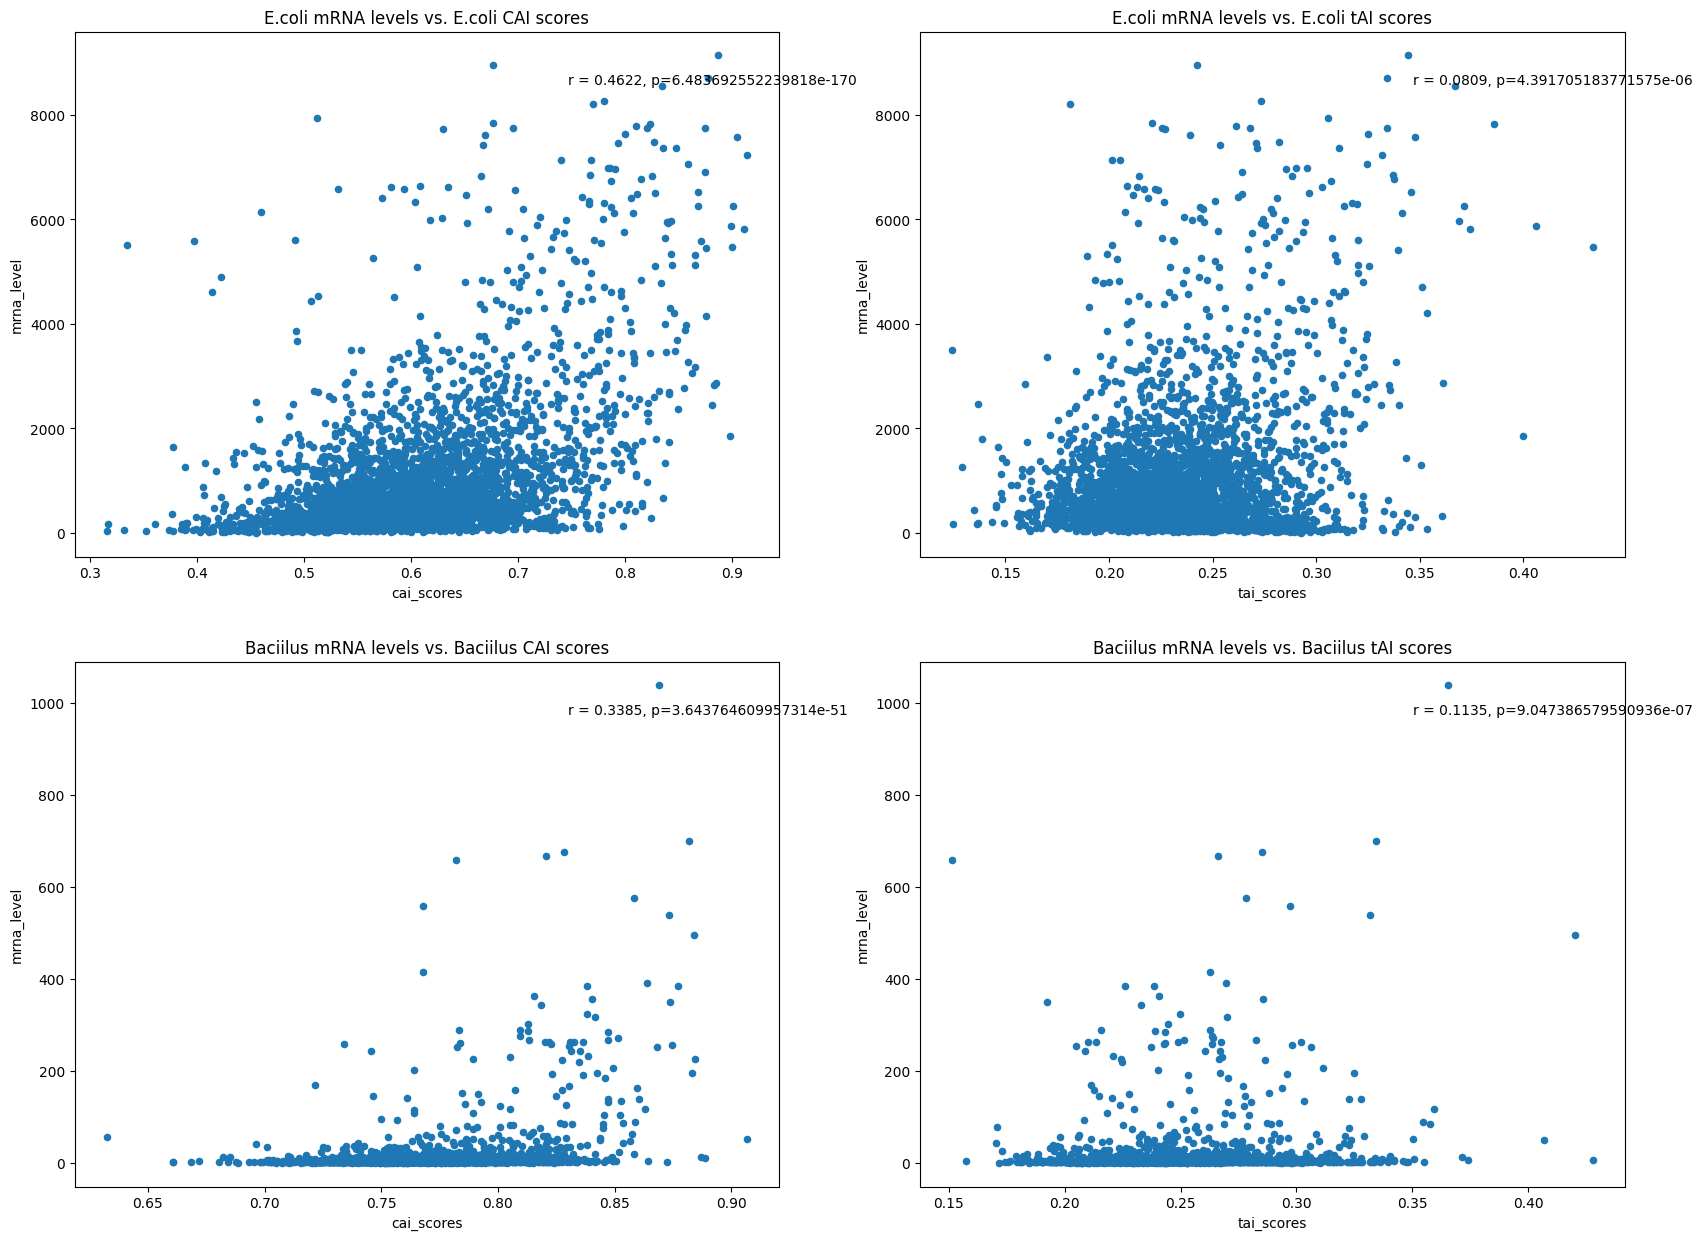

In [41]:
fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(20,15))

scatter = ecoli_scores_dataframe.plot.scatter(x="cai_scores", y="mrna_level", title="E.coli mRNA levels vs. E.coli CAI scores", ax=axes[0,0])
r, p = stats.spearmanr(ecoli_scores_dataframe["cai_scores"], ecoli_scores_dataframe["mrna_level"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = ecoli_scores_dataframe.plot.scatter(x="tai_scores", y="mrna_level", title="E.coli mRNA levels vs. E.coli tAI scores", ax=axes[0,1])
r, p = stats.spearmanr(ecoli_scores_dataframe["tai_scores"], ecoli_scores_dataframe["mrna_level"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = bacillus_scores_dataframe.plot.scatter(x="cai_scores", y="mrna_level", title="Baciilus mRNA levels vs. Baciilus CAI scores", ax=axes[1,0])
r, p = stats.spearmanr(bacillus_scores_dataframe["cai_scores"], bacillus_scores_dataframe["mrna_level"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = bacillus_scores_dataframe.plot.scatter(x="tai_scores", y="mrna_level", title="Baciilus mRNA levels vs. Baciilus tAI scores", ax=axes[1,1])
r, p = stats.spearmanr(bacillus_scores_dataframe["tai_scores"], bacillus_scores_dataframe["mrna_level"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

Ecoli mrna levels stats:
 records:482
 min: 1939.97 
 max: 9134.66
 mean: 3646.317406639004
 std: 1680.794328714984
Bacillus mrna levels stats:
 records:279
 min: 16.35 
 max: 1037.55
 mean: 104.78878136200717
 std: 139.42227820166056


<AxesSubplot:>

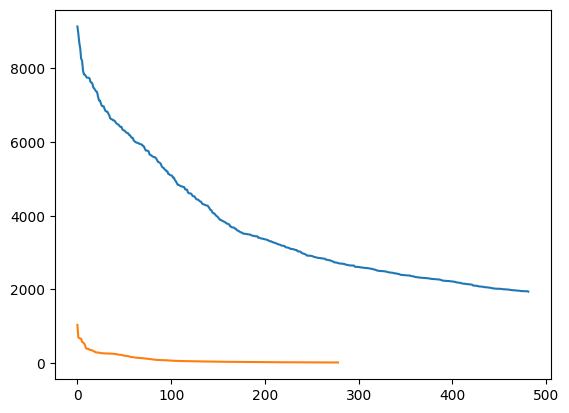

In [42]:
ecoli_estimated_expression = get_estimated_expression(endogenous_genes_fasta_file_path=ecoli_endogenous_genes_fasta_file_path,
                                                      mrna_levels_file_path=r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\ecoli_mrna_level.csv")
ecoli_highly_expressed_scores_dataframe =  get_scores(estimated_expression_dict=ecoli_estimated_expression, cai_scores_dict=ecoli_cai_scores, tai_scores_dict=ecoli_tai_scores, selected_genes=ecoli_highly_expressed_genes.keys())
print(f"Ecoli mrna levels stats:\n records:{len(ecoli_highly_expressed_scores_dataframe['mrna_level'])}\n min: {ecoli_highly_expressed_scores_dataframe['mrna_level'].min()} \n max: {ecoli_highly_expressed_scores_dataframe['mrna_level'].max()}\n mean: {ecoli_highly_expressed_scores_dataframe['mrna_level'].mean()}\n std: {ecoli_highly_expressed_scores_dataframe['mrna_level'].std()}")  
ecoli_highly_expressed_scores_dataframe["mrna_level"].sort_values(ascending=False).reset_index(drop=True).plot()
bacillus_estimated_expression = get_estimated_expression(endogenous_genes_fasta_file_path=bacillus_endogenous_genes_fasta_file_path,
                                                      mrna_levels_file_path=r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\bacillus_mrna_level.csv")
bacillus_highly_expressed_scores_dataframe =  get_scores(estimated_expression_dict=bacillus_estimated_expression, cai_scores_dict=bacillus_cai_scores, tai_scores_dict=bacillus_tai_scores, selected_genes=bacillus_highly_expressed_genes.keys())
print(f"Bacillus mrna levels stats:\n records:{len(bacillus_highly_expressed_scores_dataframe['mrna_level'])}\n min: {bacillus_highly_expressed_scores_dataframe['mrna_level'].min()} \n max: {bacillus_highly_expressed_scores_dataframe['mrna_level'].max()}\n mean: {bacillus_highly_expressed_scores_dataframe['mrna_level'].mean()}\n std: {bacillus_highly_expressed_scores_dataframe['mrna_level'].std()}")  
bacillus_highly_expressed_scores_dataframe["mrna_level"].sort_values(ascending=False).reset_index(drop=True).plot()

Text(0.7, 0.9, 'r = 0.1633, p=0.006248782358043014')

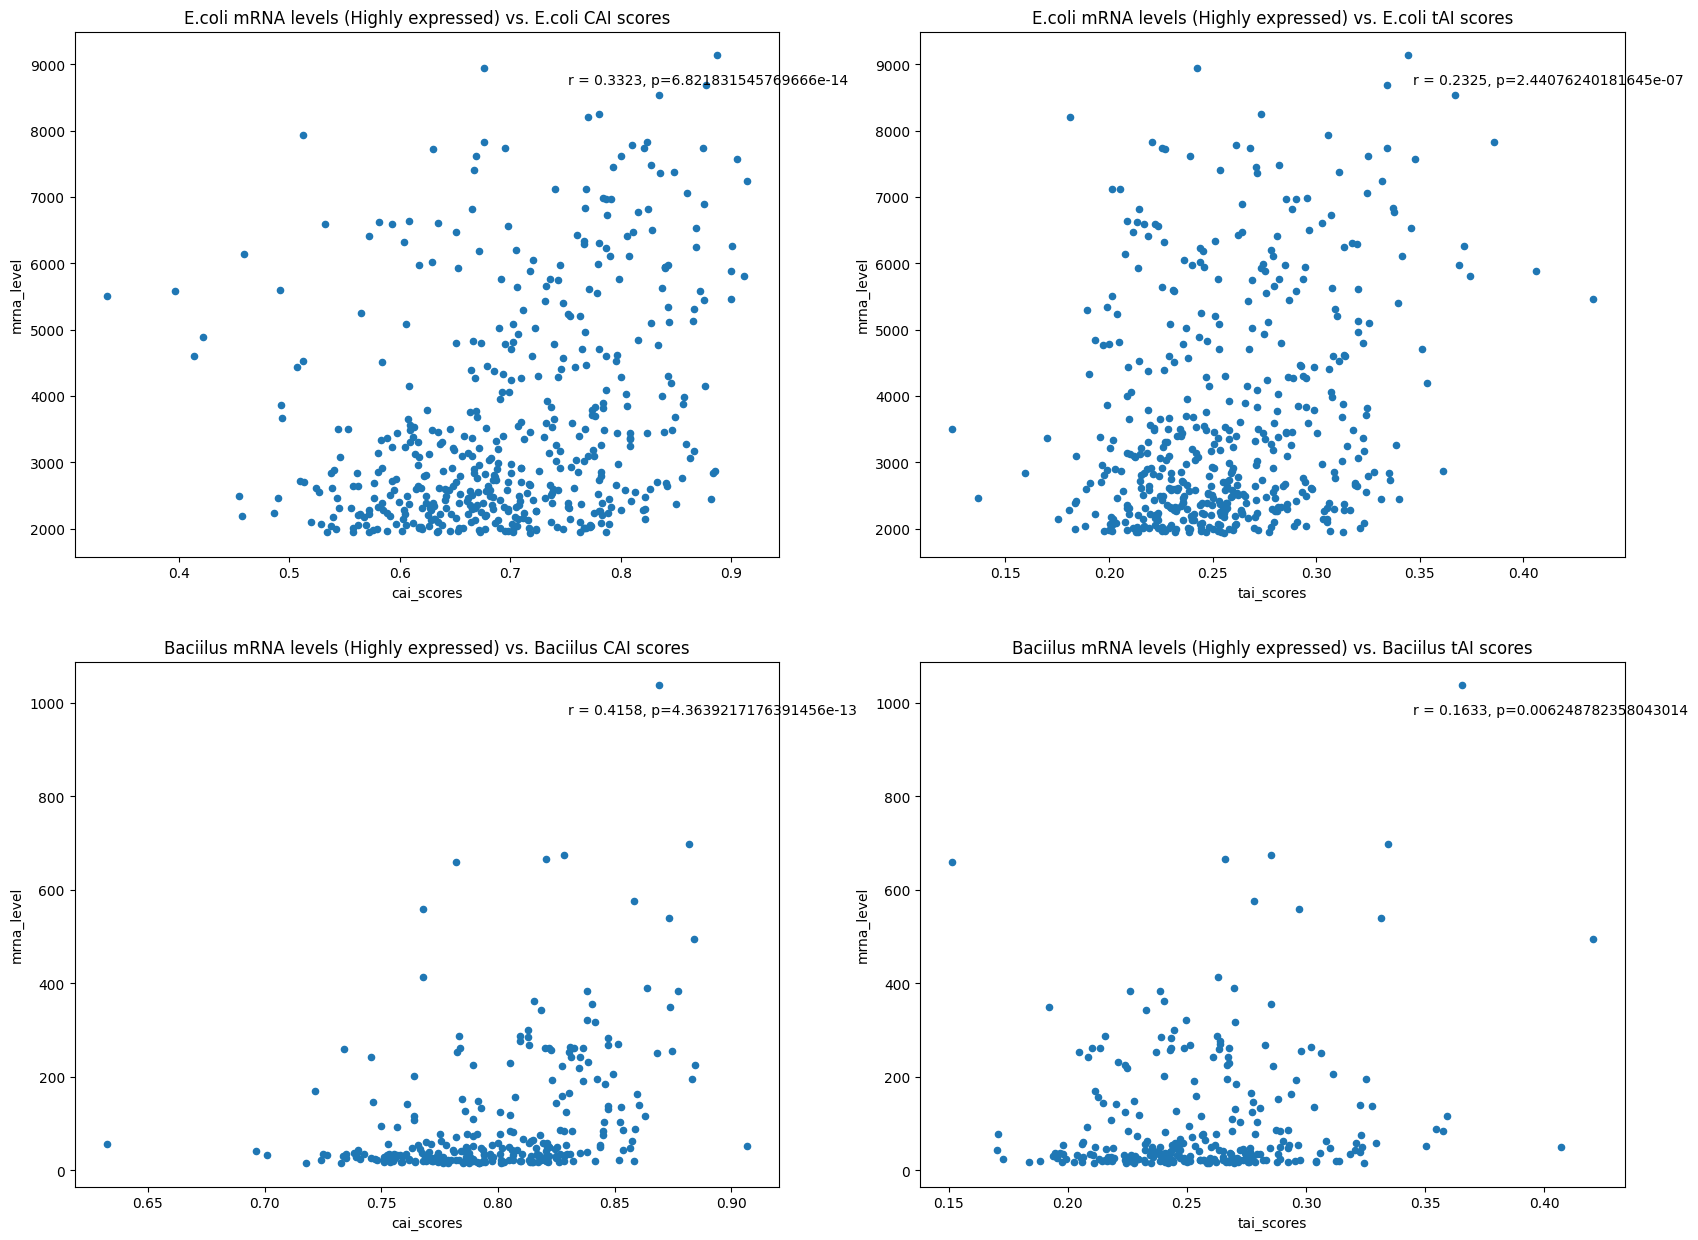

In [43]:
fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(20,15))

scatter = ecoli_highly_expressed_scores_dataframe.plot.scatter(x="cai_scores", y="mrna_level", title="E.coli mRNA levels (Highly expressed) vs. E.coli CAI scores", ax=axes[0,0])
r, p = stats.spearmanr(ecoli_highly_expressed_scores_dataframe["cai_scores"], ecoli_highly_expressed_scores_dataframe["mrna_level"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = ecoli_highly_expressed_scores_dataframe.plot.scatter(x="tai_scores", y="mrna_level", title="E.coli mRNA levels (Highly expressed) vs. E.coli tAI scores", ax=axes[0,1])
r, p = stats.spearmanr(ecoli_highly_expressed_scores_dataframe["tai_scores"], ecoli_highly_expressed_scores_dataframe["mrna_level"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = bacillus_highly_expressed_scores_dataframe.plot.scatter(x="cai_scores", y="mrna_level", title="Baciilus mRNA levels (Highly expressed) vs. Baciilus CAI scores", ax=axes[1,0])
r, p = stats.spearmanr(bacillus_highly_expressed_scores_dataframe["cai_scores"], bacillus_highly_expressed_scores_dataframe["mrna_level"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = bacillus_highly_expressed_scores_dataframe.plot.scatter(x="tai_scores", y="mrna_level", title="Baciilus mRNA levels (Highly expressed) vs. Baciilus tAI scores", ax=axes[1,1])
r, p = stats.spearmanr(bacillus_highly_expressed_scores_dataframe["tai_scores"], bacillus_highly_expressed_scores_dataframe["mrna_level"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

# Verification of variants translation to correct amino acid sequence

Validating original mcherry sequence:

In [44]:
# Reference aa sequence is taken from: https://www.addgene.org/browse/sequence_vdb/6496/
reference_mcherry_protein_seq  = "MVSKGEEDNMAIIKEFMRFKVHMEGSVNGHEFEIEGEGEGRPYEGTQTAKLKVTKGGPLPFAWDILSPQFMYGSKAYVKHPADIPDYLKLSFPEGFKWERVMNFEDGGVVTVTQDSSLQDGEFIYKVKLRGTNFPSDGPVMQKKTMGWEASSERMYPEDGALKGEIKQRLKLKDGGHYDAEVKTTYKAKKPVQLPGAYNVNIKLDITSHNEDYTIVEQYERAEGRHSTGGMDELYK*"
formatted_reference_mcherry_protein_seq = reference_mcherry_protein_seq.replace("*", "_")

translated_original_mcherry_seq = shared_functions_and_vars.translate(original_mcherry_seq)

assert translated_original_mcherry_seq == formatted_reference_mcherry_protein_seq

Validating generated mcherry variants:

In [45]:
with open(mcherry_variants_file, "r") as mcherry_variants_fasta_file:
    mcherry_variants_dict = SeqIO.to_dict(SeqIO.parse(mcherry_variants_fasta_file, "fasta"))

for variant_name, variant_seq in mcherry_variants_dict.items():
    translated_seq = shared_functions_and_vars.translate(variant_seq.seq)
    if translated_seq != formatted_reference_mcherry_protein_seq:
        raise ValueError(f"Variant {variant_name} is not coding to correct sequence. \nReference sequence: {formatted_reference_mcherry_protein_seq} \nVariant sequence: {translated_seq}")

# Measurements for assessing variants scores 

#### Eucledean distance of codon frequencies

In [46]:
original_mcherry_codon_frequencies = calculate_codon_frequencies((str(original_mcherry_seq),))
original_mcherry_codon_frequencies = original_mcherry_codon_frequencies.sort_values("codon")

In [47]:
original_bacillus_dist = calculate_distance_between_frequencies(original_mcherry_codon_frequencies["frequency"].reset_index(drop=True), bacillus_codon_frequencies["frequency"].reset_index(drop=True))
original_ecoli_dist = calculate_distance_between_frequencies(original_mcherry_codon_frequencies["frequency"].reset_index(drop=True), ecoli_codon_frequencies["frequency"].reset_index(drop=True))

In [48]:
df_dict = get_variants_df_dict(mcherry_variants_file)
ecoli_opt_df_dict = {key: value for key, value in df_dict.items() if not key.endswith("for_optimized_bacillus")}
ecoli_opt_variants_dataframe = pd.DataFrame(ecoli_opt_df_dict)

bacillus_opt_df_dict = {key: value for key, value in df_dict.items() if not key.endswith("for_optimized_ecoli")}
bacillus_opt_variants_dataframe = pd.DataFrame(bacillus_opt_df_dict)

In [49]:
bacillus_A = bacillus_codon_frequencies[bacillus_codon_frequencies["amino_acid"] == "A"].sort_values("codon")
x = pd.DataFrame(get_codon_frequencies_df_dict(mcherry_variants_file))
x_A = x[x["amino_acid"] == "A"].sort_values("codon")
original_A = original_mcherry_codon_frequencies[original_mcherry_codon_frequencies["amino_acid"] == "A"].sort_values("codon")


original_dist = calculate_distance_between_frequencies(original_A["frequency"].reset_index(drop=True), bacillus_A["frequency"].reset_index(drop=True))
variant_dist = calculate_distance_between_frequencies(x_A["frequency"].reset_index(drop=True), bacillus_A["frequency"].reset_index(drop=True))
bacillus_A

,codon,amino_acid,frequency
36,GCA,A,0.282823
10,GCC,A,0.207163
42,GCG,A,0.262543
12,GCT,A,0.247470


In [50]:
original_A

,codon,amino_acid,frequency
51,GCA,A,0.000000
23,GCC,A,0.181818
29,GCG,A,0.636364
8,GCT,A,0.181818


In [51]:
x_A

,codon,amino_acid,frequency
40,GCA,A,0.0
41,GCC,A,0.0
42,GCG,A,0.0
8,GCT,A,1.0


In [52]:
print(f"original seq dist: {original_dist}, variant dist: {variant_dist}")

original seq dist: 0.4740076240253718, variant dist: 0.8707097798509963


#### CUB scores

In [53]:
df_dict = get_cub_score_df_dict(mcherry_root_dir)
cub_ecoli_opt_df_dict = {key.replace("_for_optimized_ecoli", ""): value for key, value in df_dict.items() if not (key.endswith("_for_optimized_bacillus") or key.startswith("evaluation_score"))}
cub_ecoli_opt_variants_dataframe = pd.DataFrame(cub_ecoli_opt_df_dict)

evaluation_ecoli_opt_df_dict = {key: value for key, value in df_dict.items() if key in ["variant", "evaluation_score_for_optimized_ecoli"]}
evaluation_ecoli_opt_variants_dataframe = pd.DataFrame(evaluation_ecoli_opt_df_dict)

cub_bacillus_opt_df_dict = {key.replace("_for_optimized_bacillus", ""): value for key, value in df_dict.items() if not (key.endswith("for_optimized_ecoli") or key.startswith("evaluation_score"))}
cub_bacillus_opt_variants_dataframe = pd.DataFrame(cub_bacillus_opt_df_dict)

evaluation_bacillus_opt_df_dict = {key: value for key, value in df_dict.items() if key in ["variant", "evaluation_score_for_optimized_bacillus"]}
evaluation_bacillus_opt_variants_dataframe = pd.DataFrame(evaluation_bacillus_opt_df_dict)

#### tuning parameter = 1 - Eucledean distance of codon frequencies

In [54]:
greater_alpha_df_dict = get_variants_df_dict(mcherry_greater_alpha_variants_file)
    
greater_alpha_ecoli_opt_df_dict = {key: value for key, value in greater_alpha_df_dict.items() if not key.endswith("for_optimized_bacillus")}
greater_alpha_ecoli_opt_variants_dataframe = pd.DataFrame(greater_alpha_ecoli_opt_df_dict)

greater_alpha_bacillus_opt_df_dict = {key: value for key, value in greater_alpha_df_dict.items() if not key.endswith("for_optimized_ecoli")}
greater_alpha_bacillus_opt_variants_dataframe = pd.DataFrame(greater_alpha_bacillus_opt_df_dict)

#### tuning parameter = 1 - CUB scores

In [55]:
greater_alpha_df_dict = get_cub_score_df_dict(mcherry_greater_alpha_root_dir)
cub_ecoli_opt_greater_alpha_df_dict = {key.replace("_for_optimized_ecoli", ""): value for key, value in greater_alpha_df_dict.items() if not (key.endswith("_for_optimized_bacillus") or key.startswith("evaluation_score"))}
cub_ecoli_opt_greater_alpha_variants_dataframe = pd.DataFrame(cub_ecoli_opt_greater_alpha_df_dict)

evaluation_ecoli_opt_greate_alpha_df_dict = {key: value for key, value in greater_alpha_df_dict.items() if key in ["variant", "evaluation_score_for_optimized_ecoli"]}
evaluation_ecoli_opt_greater_alpha_variants_dataframe = pd.DataFrame(evaluation_ecoli_opt_greate_alpha_df_dict)

cub_bacillus_opt_greater_alpha_df_dict = {key.replace("_for_optimized_bacillus", ""): value for key, value in greater_alpha_df_dict.items() if not (key.endswith("for_optimized_ecoli") or key.startswith("evaluation_score"))}
cub_bacillus_opt_greater_alpha_variants_dataframe = pd.DataFrame(cub_bacillus_opt_greater_alpha_df_dict)

evaluation_bacillus_opt_greater_alpha_df_dict = {key: value for key, value in greater_alpha_df_dict.items() if key in ["variant", "evaluation_score_for_optimized_bacillus"]}
evaluation_bacillus_opt_greater_alpha_variants_dataframe = pd.DataFrame(evaluation_bacillus_opt_greater_alpha_df_dict)

#### tuning parameter = 0 - Eucledean distance of codon frequencies & CUB scores 

In [56]:
lower_alpha_df_dict = get_variants_df_dict(mcherry_lower_alpha_variants_file)
    
lower_alpha_ecoli_opt_df_dict = {key: value for key, value in lower_alpha_df_dict.items() if not key.endswith("for_optimized_bacillus")}
lower_alpha_ecoli_opt_variants_dataframe = pd.DataFrame(lower_alpha_ecoli_opt_df_dict)

lower_alpha_bacillus_opt_df_dict = {key: value for key, value in lower_alpha_df_dict.items() if not key.endswith("for_optimized_ecoli")}
lower_alpha_bacillus_opt_variants_dataframe = pd.DataFrame(lower_alpha_bacillus_opt_df_dict)

In [57]:
lower_alpha_df_dict = get_cub_score_df_dict(mcherry_lower_alpha_root_dir)
cub_ecoli_opt_lower_alpha_df_dict = {key.replace("_for_optimized_ecoli", ""): value for key, value in lower_alpha_df_dict.items() if not (key.endswith("_for_optimized_bacillus") or key.startswith("evaluation_score"))}
cub_ecoli_opt_lower_alpha_variants_dataframe = pd.DataFrame(cub_ecoli_opt_lower_alpha_df_dict)

evaluation_ecoli_opt_lower_alpha_df_dict = {key: value for key, value in lower_alpha_df_dict.items() if key in ["variant", "evaluation_score_for_optimized_ecoli"]}
evaluation_ecoli_opt_lower_alpha_variants_dataframe = pd.DataFrame(evaluation_ecoli_opt_lower_alpha_df_dict)

cub_bacillus_opt_lower_alpha_df_dict = {key.replace("_for_optimized_bacillus", ""): value for key, value in lower_alpha_df_dict.items() if not (key.endswith("for_optimized_ecoli") or key.startswith("evaluation_score"))}
cub_bacillus_opt_lower_alpha_variants_dataframe = pd.DataFrame(cub_bacillus_opt_lower_alpha_df_dict)

evaluation_bacillus_opt_lower_alpha_df_dict = {key: value for key, value in lower_alpha_df_dict.items() if key in ["variant", "evaluation_score_for_optimized_bacillus"]}
evaluation_bacillus_opt_lower_alpha_variants_dataframe = pd.DataFrame(evaluation_bacillus_opt_lower_alpha_df_dict)

# Comparative analysis

<AxesSubplot:title={'center':'Bacillus optimized'}, ylabel='variant'>

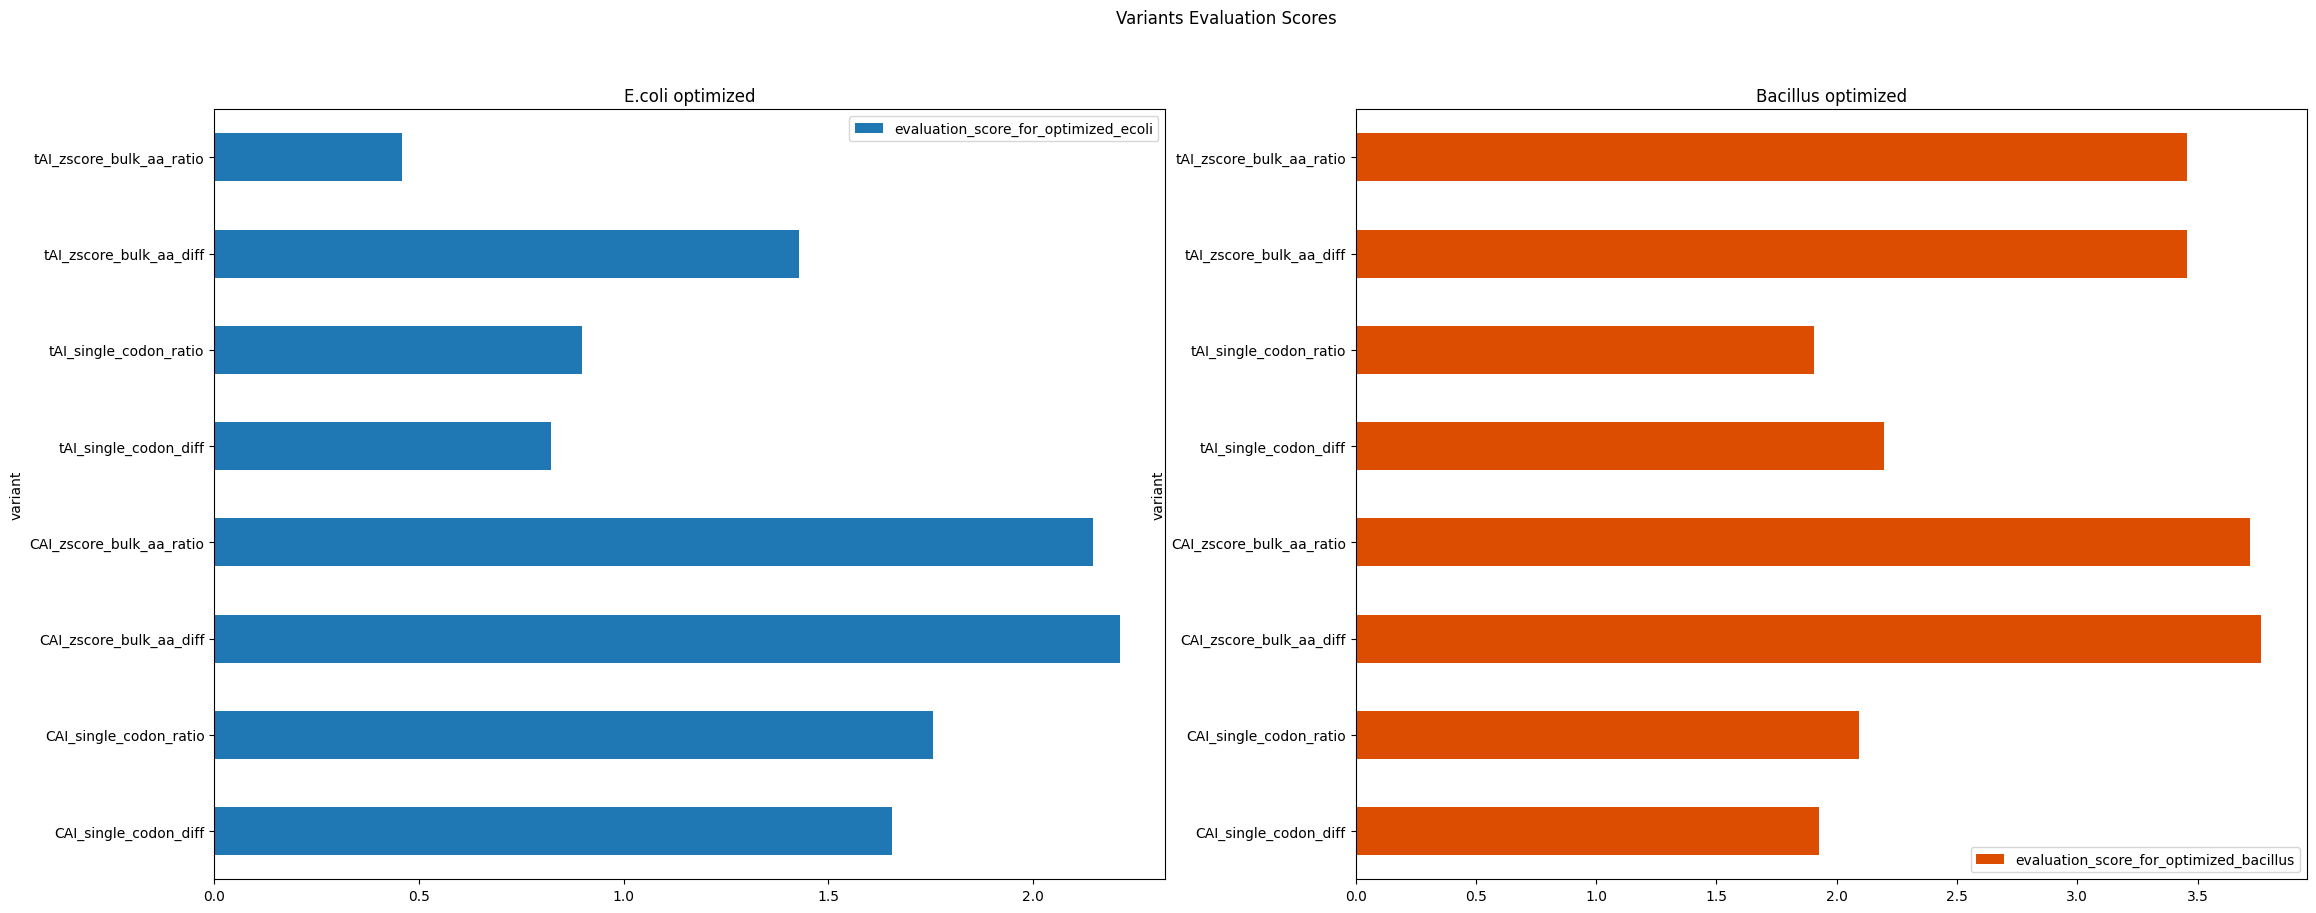

In [58]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(27,10))

fig.suptitle("Variants Evaluation Scores")
evaluation_ecoli_opt_variants_dataframe.plot("variant", kind="barh", ax=axes[0], title="E.coli optimized")
evaluation_bacillus_opt_variants_dataframe.plot("variant", kind="barh", ax=axes[1], title="Bacillus optimized", color="#dc4d01")

Text(0.7, 0.9, 'r = -0.569')

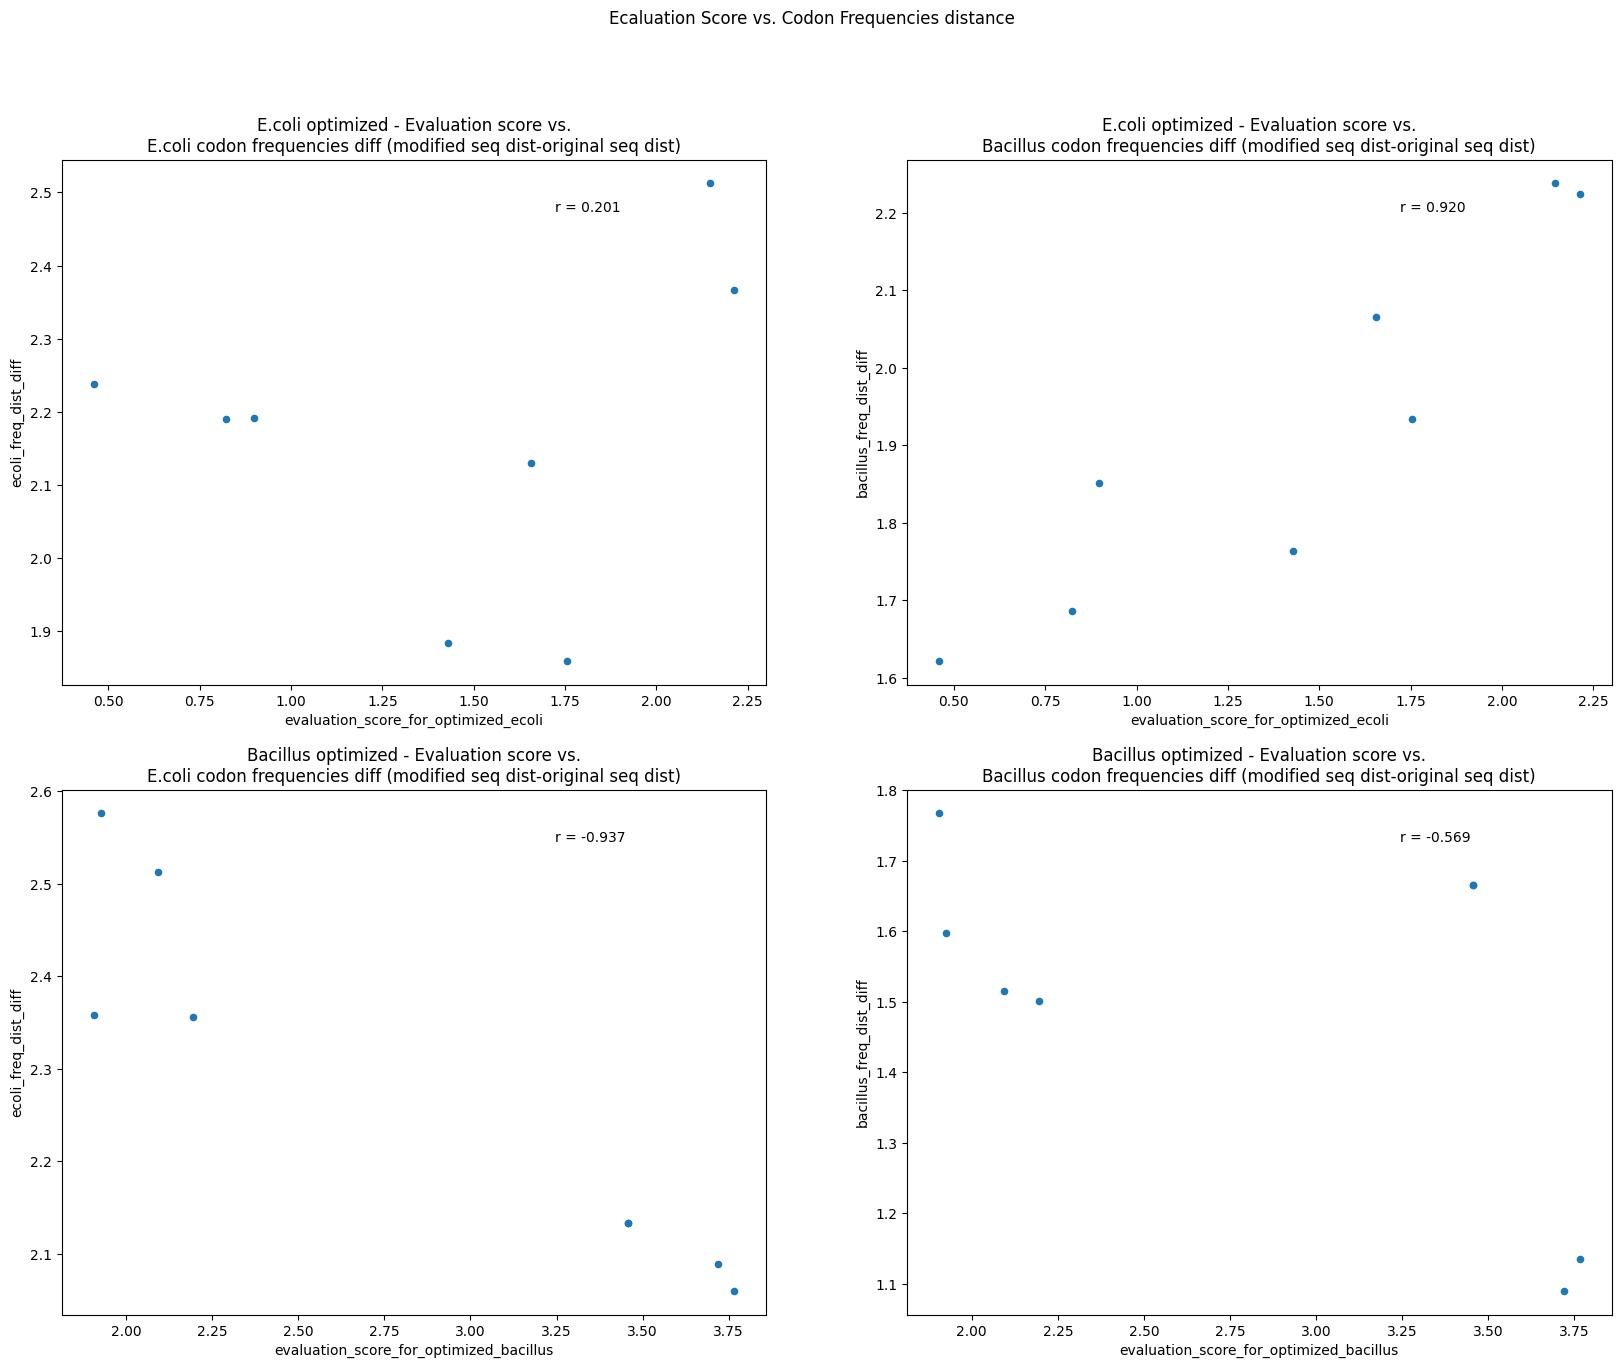

In [59]:
merged_df_ecoli = pd.merge(evaluation_ecoli_opt_variants_dataframe, ecoli_opt_variants_dataframe, on='variant', how='inner')
merged_df_ecoli['ecoli_freq_dist_diff'] =  merged_df_ecoli['ecoli_dist_for_optimized_ecoli'] - merged_df_ecoli['ecoli_dist_for_original_mcherry']
merged_df_ecoli['bacillus_freq_dist_diff'] = merged_df_ecoli['bacillus_dist_for_optimized_ecoli'] - merged_df_ecoli['bacillus_dist_for_original_mcherry']

merged_df_bacillus = pd.merge(evaluation_bacillus_opt_variants_dataframe, bacillus_opt_variants_dataframe, on='variant', how='inner')
merged_df_bacillus['ecoli_freq_dist_diff'] =  merged_df_bacillus['ecoli_dist_for_optimized_bacillus'] - merged_df_bacillus['ecoli_dist_for_original_mcherry']
merged_df_bacillus['bacillus_freq_dist_diff'] = merged_df_bacillus['bacillus_dist_for_optimized_bacillus'] - merged_df_bacillus['bacillus_dist_for_original_mcherry'] 


fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(20,15))
fig.suptitle("Ecaluation Score vs. Codon Frequencies distance")

scatter = merged_df_ecoli.plot.scatter(x="evaluation_score_for_optimized_ecoli", y="ecoli_freq_dist_diff", ax=axes[0,0], title="E.coli optimized - Evaluation score vs.\nE.coli codon frequencies diff (modified seq dist-original seq dist)")
r, p = stats.pearsonr(merged_df_ecoli["evaluation_score_for_optimized_ecoli"], merged_df_ecoli["ecoli_freq_dist_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df_ecoli.plot.scatter(x="evaluation_score_for_optimized_ecoli", y="bacillus_freq_dist_diff", ax=axes[0,1], title="E.coli optimized - Evaluation score vs.\nBacillus codon frequencies diff (modified seq dist-original seq dist)")
r, p = stats.pearsonr(merged_df_ecoli["evaluation_score_for_optimized_ecoli"], merged_df_ecoli["bacillus_freq_dist_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df_bacillus.plot.scatter(x="evaluation_score_for_optimized_bacillus", y="ecoli_freq_dist_diff", ax=axes[1,0], title="Bacillus optimized - Evaluation score vs.\nE.coli codon frequencies diff (modified seq dist-original seq dist)")
r, p = stats.pearsonr(merged_df_bacillus["evaluation_score_for_optimized_bacillus"], merged_df_bacillus["ecoli_freq_dist_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df_bacillus.plot.scatter(x="evaluation_score_for_optimized_bacillus", y="bacillus_freq_dist_diff", ax=axes[1,1], title="Bacillus optimized - Evaluation score vs.\nBacillus codon frequencies diff (modified seq dist-original seq dist)")
r, p = stats.pearsonr(merged_df_bacillus["evaluation_score_for_optimized_bacillus"], merged_df_bacillus["bacillus_freq_dist_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

Text(0.7, 0.9, 'r = 0.988')

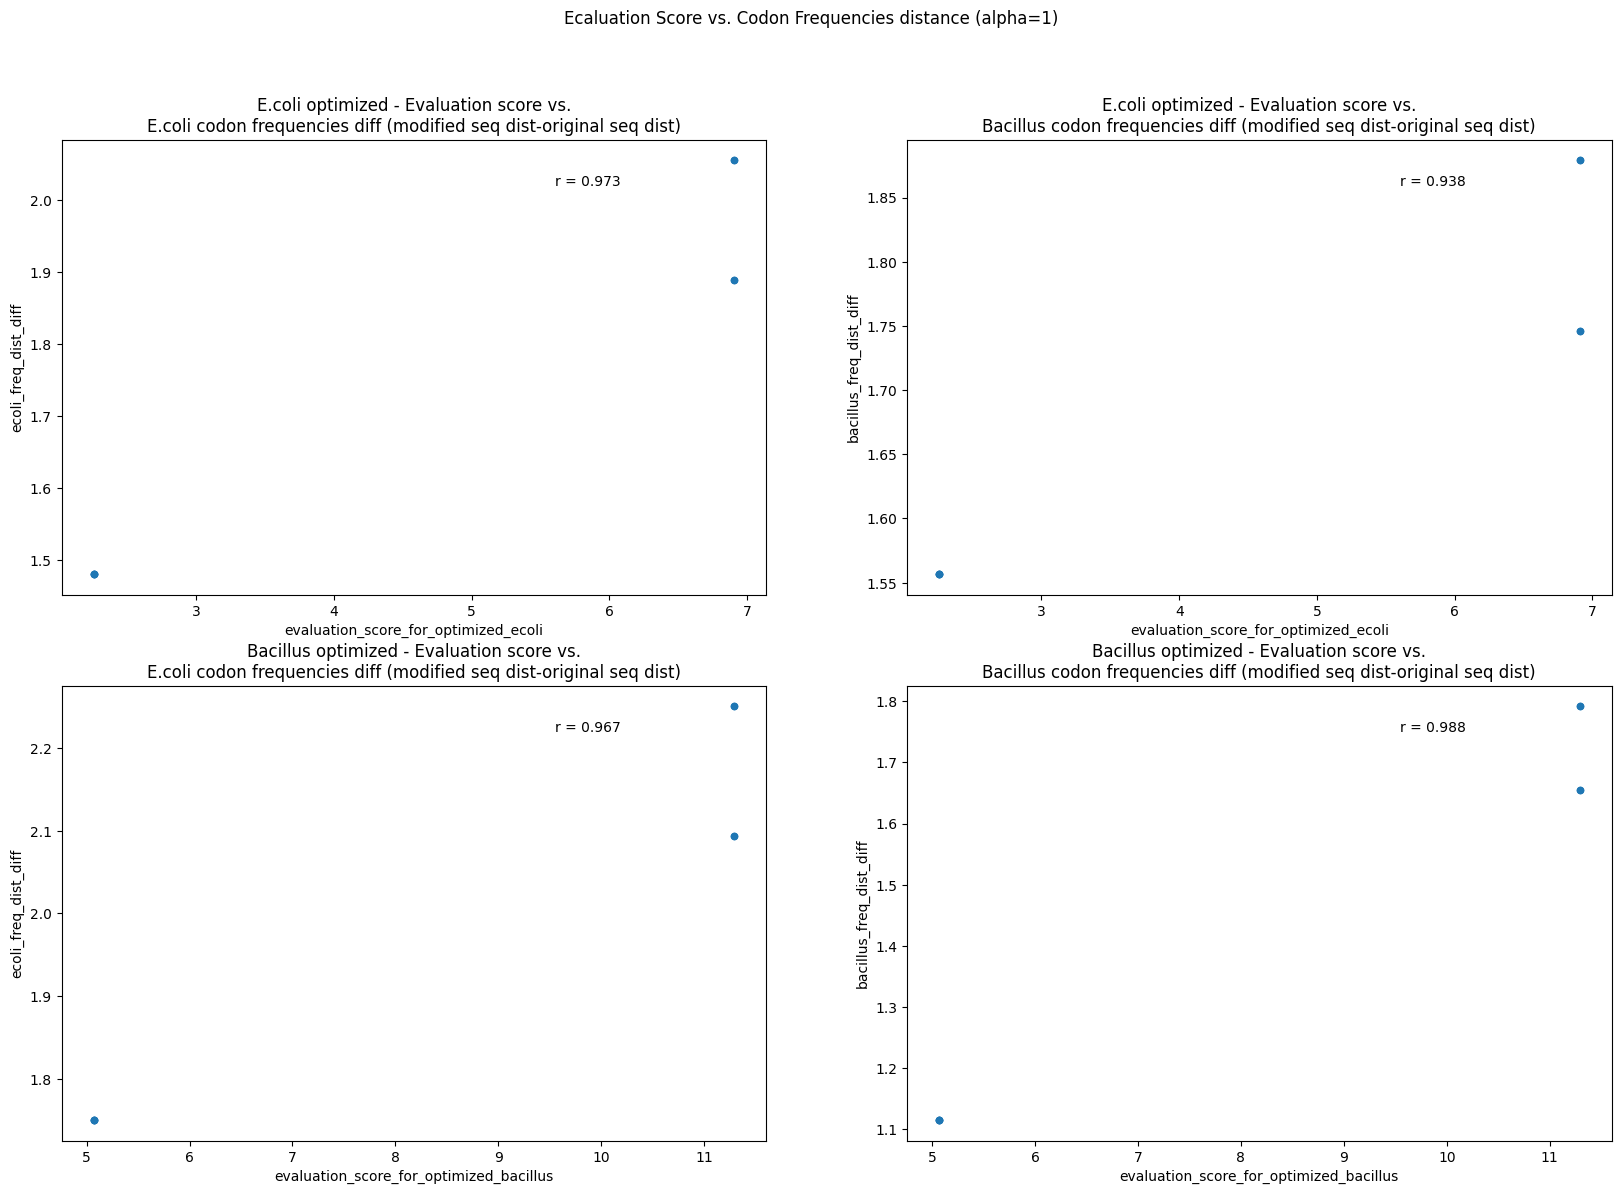

In [60]:
merged_df_ecoli = pd.merge(evaluation_ecoli_opt_greater_alpha_variants_dataframe, greater_alpha_ecoli_opt_variants_dataframe, on='variant', how='inner')
merged_df_ecoli['ecoli_freq_dist_diff'] =  merged_df_ecoli['ecoli_dist_for_optimized_ecoli'] - merged_df_ecoli['ecoli_dist_for_original_mcherry']
merged_df_ecoli['bacillus_freq_dist_diff'] = merged_df_ecoli['bacillus_dist_for_optimized_ecoli'] - merged_df_ecoli['bacillus_dist_for_original_mcherry']

merged_df_bacillus = pd.merge(evaluation_bacillus_opt_greater_alpha_variants_dataframe, greater_alpha_bacillus_opt_variants_dataframe, on='variant', how='inner')
merged_df_bacillus['ecoli_freq_dist_diff'] =  merged_df_bacillus['ecoli_dist_for_optimized_bacillus'] - merged_df_bacillus['ecoli_dist_for_original_mcherry']
merged_df_bacillus['bacillus_freq_dist_diff'] = merged_df_bacillus['bacillus_dist_for_optimized_bacillus'] - merged_df_bacillus['bacillus_dist_for_original_mcherry'] 


fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(20,13))
fig.suptitle("Ecaluation Score vs. Codon Frequencies distance (alpha=1)")

scatter = merged_df_ecoli.plot.scatter(x="evaluation_score_for_optimized_ecoli", y="ecoli_freq_dist_diff", ax=axes[0,0], title="E.coli optimized - Evaluation score vs.\nE.coli codon frequencies diff (modified seq dist-original seq dist)")
r, p = stats.pearsonr(merged_df_ecoli["evaluation_score_for_optimized_ecoli"], merged_df_ecoli["ecoli_freq_dist_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df_ecoli.plot.scatter(x="evaluation_score_for_optimized_ecoli", y="bacillus_freq_dist_diff", ax=axes[0,1], title="E.coli optimized - Evaluation score vs.\nBacillus codon frequencies diff (modified seq dist-original seq dist)")
r, p = stats.pearsonr(merged_df_ecoli["evaluation_score_for_optimized_ecoli"], merged_df_ecoli["bacillus_freq_dist_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df_bacillus.plot.scatter(x="evaluation_score_for_optimized_bacillus", y="ecoli_freq_dist_diff", ax=axes[1,0], title="Bacillus optimized - Evaluation score vs.\nE.coli codon frequencies diff (modified seq dist-original seq dist)")
r, p = stats.pearsonr(merged_df_bacillus["evaluation_score_for_optimized_bacillus"], merged_df_bacillus["ecoli_freq_dist_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df_bacillus.plot.scatter(x="evaluation_score_for_optimized_bacillus", y="bacillus_freq_dist_diff", ax=axes[1,1], title="Bacillus optimized - Evaluation score vs.\nBacillus codon frequencies diff (modified seq dist-original seq dist)")
r, p = stats.pearsonr(merged_df_bacillus["evaluation_score_for_optimized_bacillus"], merged_df_bacillus["bacillus_freq_dist_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

Text(0.7, 0.9, 'r = 0.890')

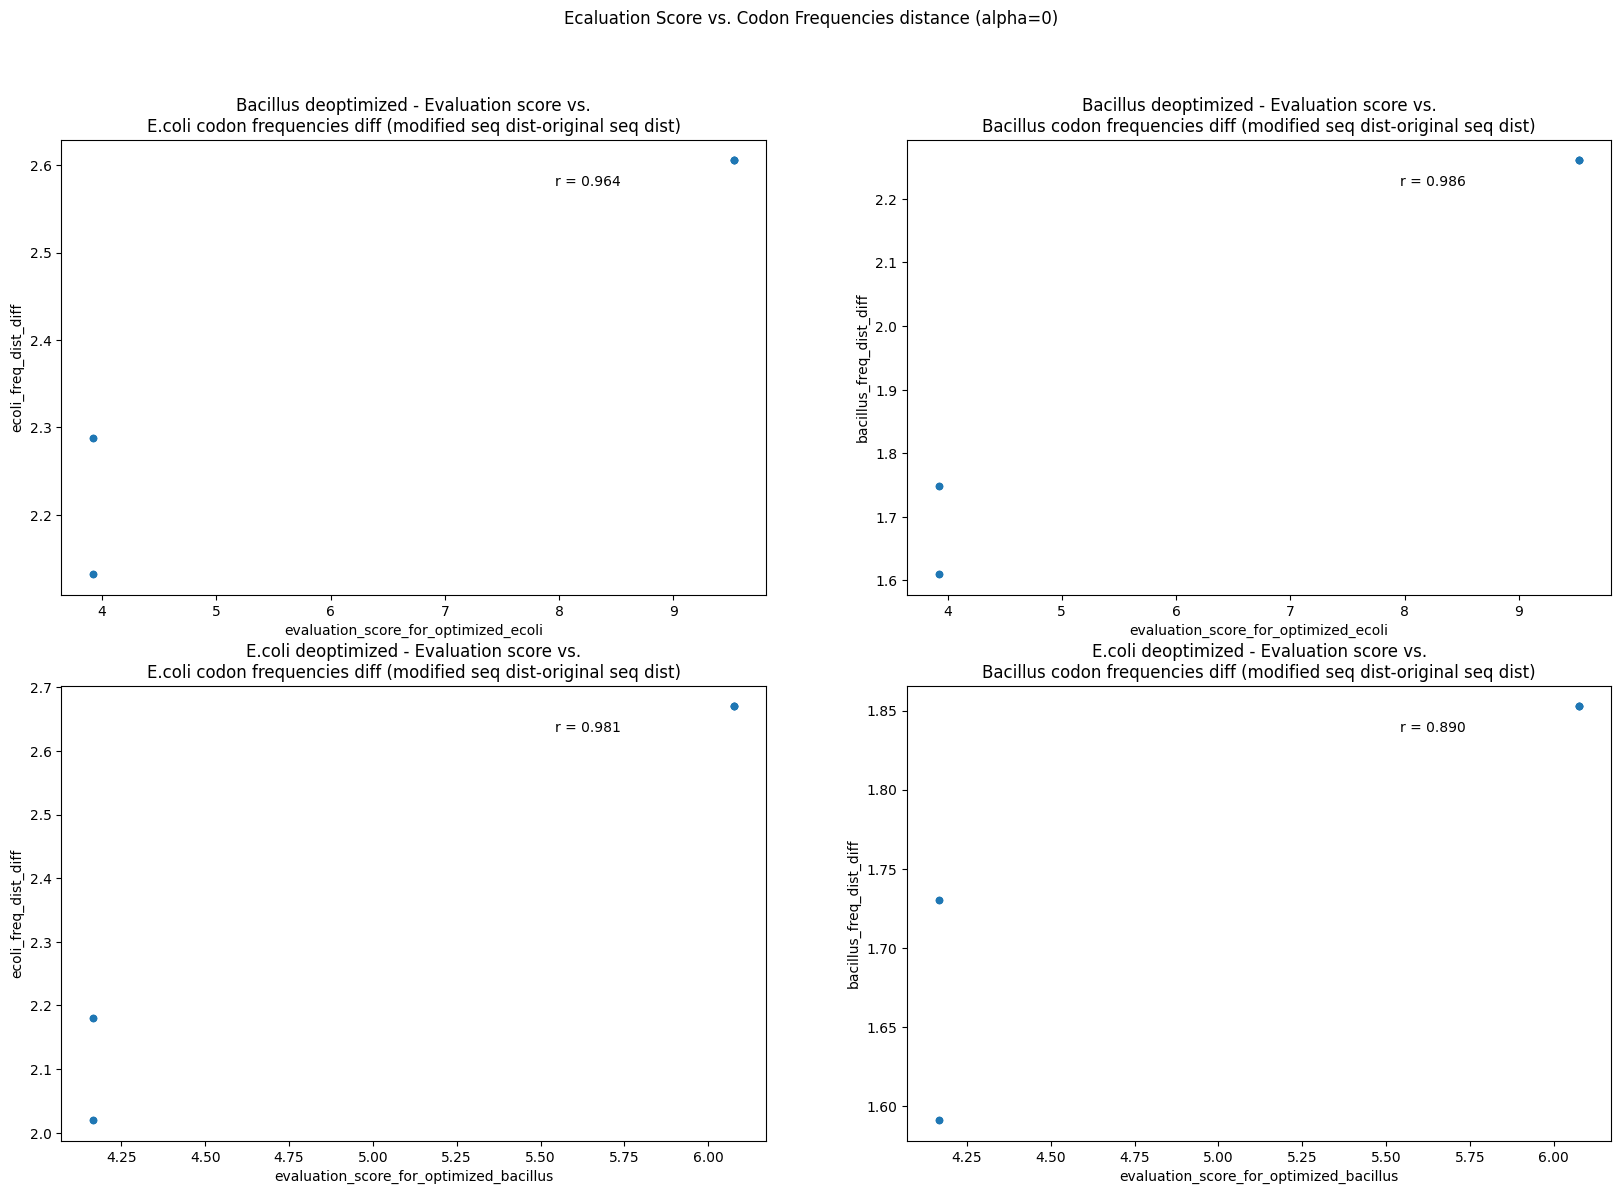

In [61]:
merged_df_ecoli = pd.merge(evaluation_ecoli_opt_lower_alpha_variants_dataframe, lower_alpha_ecoli_opt_variants_dataframe, on='variant', how='inner')
merged_df_ecoli['ecoli_freq_dist_diff'] =  merged_df_ecoli['ecoli_dist_for_optimized_ecoli'] - merged_df_ecoli['ecoli_dist_for_original_mcherry']
merged_df_ecoli['bacillus_freq_dist_diff'] = merged_df_ecoli['bacillus_dist_for_optimized_ecoli'] - merged_df_ecoli['bacillus_dist_for_original_mcherry']

merged_df_bacillus = pd.merge(evaluation_bacillus_opt_lower_alpha_variants_dataframe, lower_alpha_bacillus_opt_variants_dataframe, on='variant', how='inner')
merged_df_bacillus['ecoli_freq_dist_diff'] =  merged_df_bacillus['ecoli_dist_for_optimized_bacillus'] - merged_df_bacillus['ecoli_dist_for_original_mcherry']
merged_df_bacillus['bacillus_freq_dist_diff'] = merged_df_bacillus['bacillus_dist_for_optimized_bacillus'] - merged_df_bacillus['bacillus_dist_for_original_mcherry'] 


fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(20,13))
fig.suptitle("Ecaluation Score vs. Codon Frequencies distance (alpha=0)")

scatter = merged_df_ecoli.plot.scatter(x="evaluation_score_for_optimized_ecoli", y="ecoli_freq_dist_diff", ax=axes[0,0], title="Bacillus deoptimized - Evaluation score vs.\nE.coli codon frequencies diff (modified seq dist-original seq dist)")
r, p = stats.pearsonr(merged_df_ecoli["evaluation_score_for_optimized_ecoli"], merged_df_ecoli["ecoli_freq_dist_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df_ecoli.plot.scatter(x="evaluation_score_for_optimized_ecoli", y="bacillus_freq_dist_diff", ax=axes[0,1], title="Bacillus deoptimized - Evaluation score vs.\nBacillus codon frequencies diff (modified seq dist-original seq dist)")
r, p = stats.pearsonr(merged_df_ecoli["evaluation_score_for_optimized_ecoli"], merged_df_ecoli["bacillus_freq_dist_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df_bacillus.plot.scatter(x="evaluation_score_for_optimized_bacillus", y="ecoli_freq_dist_diff", ax=axes[1,0], title="E.coli deoptimized - Evaluation score vs.\nE.coli codon frequencies diff (modified seq dist-original seq dist)")
r, p = stats.pearsonr(merged_df_bacillus["evaluation_score_for_optimized_bacillus"], merged_df_bacillus["ecoli_freq_dist_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df_bacillus.plot.scatter(x="evaluation_score_for_optimized_bacillus", y="bacillus_freq_dist_diff", ax=axes[1,1], title="E.coli deoptimized - Evaluation score vs.\nBacillus codon frequencies diff (modified seq dist-original seq dist)")
r, p = stats.pearsonr(merged_df_bacillus["evaluation_score_for_optimized_bacillus"], merged_df_bacillus["bacillus_freq_dist_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

Text(0.7, 0.9, 'r = 0.735')

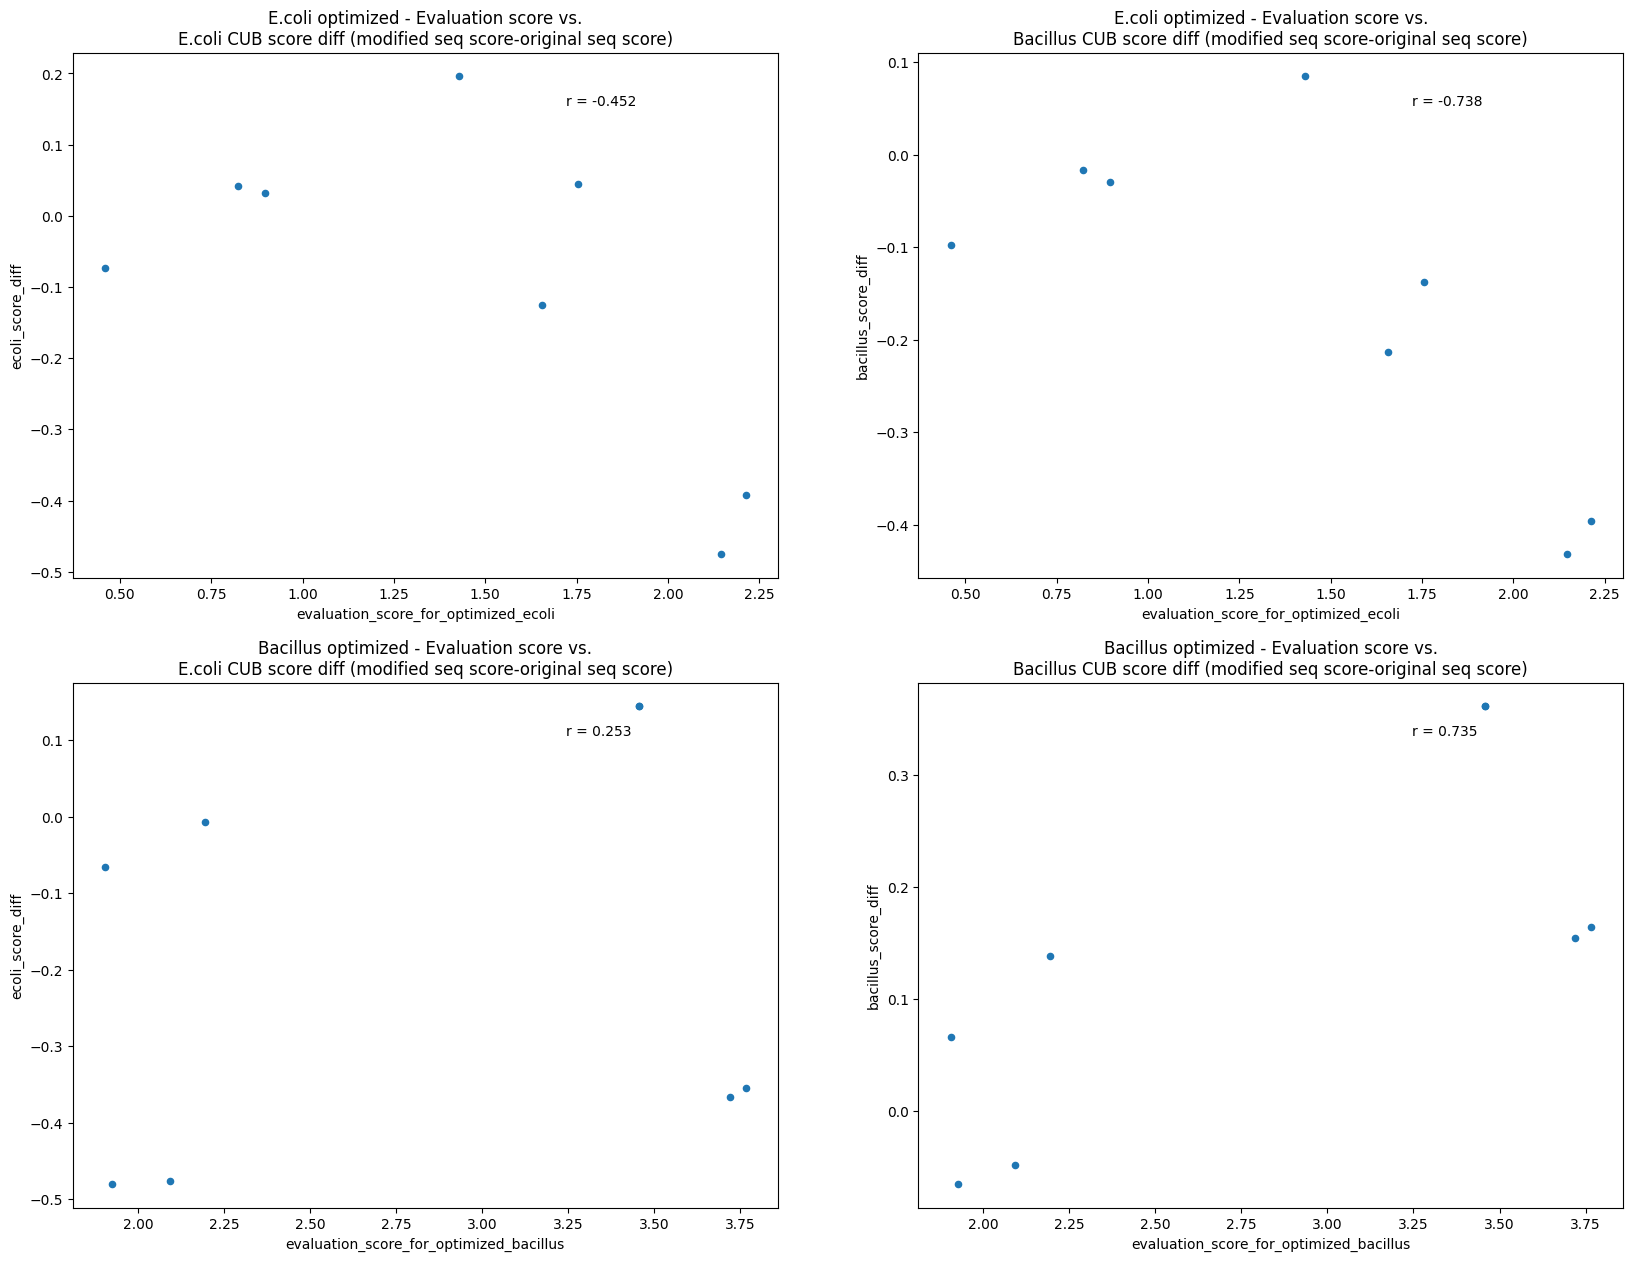

In [62]:
merged_df_ecoli = pd.merge(evaluation_ecoli_opt_variants_dataframe, cub_ecoli_opt_variants_dataframe, on='variant', how='inner')
merged_df_ecoli['ecoli_score_diff'] = merged_df_ecoli['ecoli_final_score'] - merged_df_ecoli['ecoli_initial_score']
merged_df_ecoli['bacillus_score_diff'] = merged_df_ecoli['bacillus_final_score'] - merged_df_ecoli['bacillus_initial_score']

merged_df_bacillus = pd.merge(evaluation_bacillus_opt_variants_dataframe, cub_bacillus_opt_variants_dataframe, on='variant', how='inner')
merged_df_bacillus['ecoli_score_diff'] = merged_df_bacillus['ecoli_final_score'] - merged_df_bacillus['ecoli_initial_score']
merged_df_bacillus['bacillus_score_diff'] = merged_df_bacillus['bacillus_final_score'] - merged_df_bacillus['bacillus_initial_score']

fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(20,15))

scatter = merged_df_ecoli.plot.scatter(x="evaluation_score_for_optimized_ecoli", y="ecoli_score_diff", ax=axes[0,0], title="E.coli optimized - Evaluation score vs.\nE.coli CUB score diff (modified seq score-original seq score)")
r, p = stats.spearmanr(merged_df_ecoli["evaluation_score_for_optimized_ecoli"], merged_df_ecoli["ecoli_score_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df_ecoli.plot.scatter(x="evaluation_score_for_optimized_ecoli", y="bacillus_score_diff", ax=axes[0,1], title="E.coli optimized - Evaluation score vs.\nBacillus CUB score diff (modified seq score-original seq score)")
r, p = stats.spearmanr(merged_df_ecoli["evaluation_score_for_optimized_ecoli"], merged_df_ecoli["bacillus_score_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df_bacillus.plot.scatter(x="evaluation_score_for_optimized_bacillus", y="ecoli_score_diff", ax=axes[1,0], title="Bacillus optimized - Evaluation score vs.\nE.coli CUB score diff (modified seq score-original seq score)")
r, p = stats.spearmanr(merged_df_bacillus["evaluation_score_for_optimized_bacillus"], merged_df_bacillus["ecoli_score_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df_bacillus.plot.scatter(x="evaluation_score_for_optimized_bacillus", y="bacillus_score_diff", ax=axes[1,1], title="Bacillus optimized - Evaluation score vs.\nBacillus CUB score diff (modified seq score-original seq score)")
r, p = stats.spearmanr(merged_df_bacillus["evaluation_score_for_optimized_bacillus"], merged_df_bacillus["bacillus_score_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

Text(0.7, 0.9, 'r = 1.000')

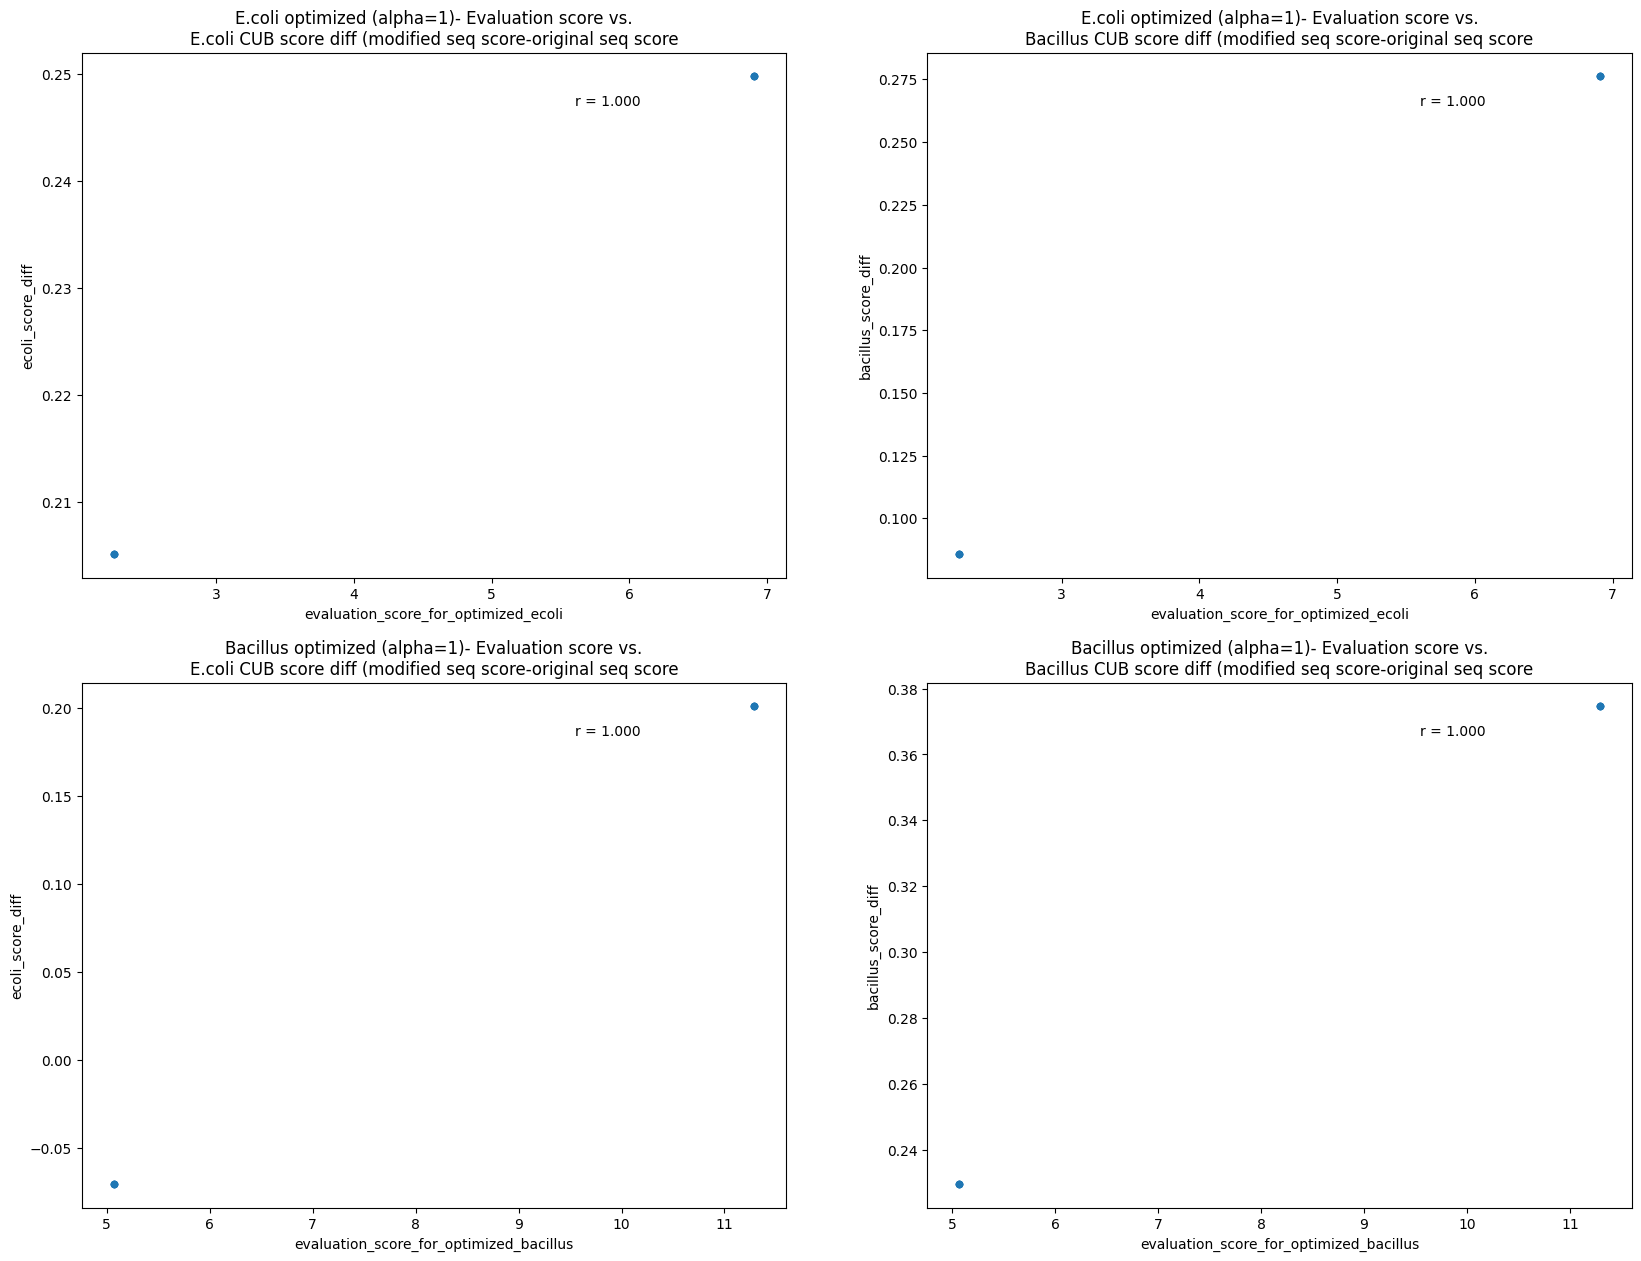

In [63]:
merged_df_ecoli_greater_alpha = pd.merge(evaluation_ecoli_opt_greater_alpha_variants_dataframe, cub_ecoli_opt_greater_alpha_variants_dataframe, on='variant', how='inner')
merged_df_ecoli_greater_alpha['ecoli_score_diff'] = merged_df_ecoli_greater_alpha['ecoli_final_score'] - merged_df_ecoli_greater_alpha['ecoli_initial_score']
merged_df_ecoli_greater_alpha['bacillus_score_diff'] = merged_df_ecoli_greater_alpha['bacillus_final_score'] - merged_df_ecoli_greater_alpha['bacillus_initial_score']

merged_df_bacillus_greater_alpha = pd.merge(evaluation_bacillus_opt_greater_alpha_variants_dataframe, cub_bacillus_opt_greater_alpha_variants_dataframe, on='variant', how='inner')
merged_df_bacillus_greater_alpha['ecoli_score_diff'] = merged_df_bacillus_greater_alpha['ecoli_final_score'] - merged_df_bacillus_greater_alpha['ecoli_initial_score']
merged_df_bacillus_greater_alpha['bacillus_score_diff'] = merged_df_bacillus_greater_alpha['bacillus_final_score'] - merged_df_bacillus_greater_alpha['bacillus_initial_score']

fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(20,15))

scatter = merged_df_ecoli_greater_alpha.plot.scatter(x="evaluation_score_for_optimized_ecoli", y="ecoli_score_diff", ax=axes[0,0], title="E.coli optimized (alpha=1)- Evaluation score vs.\nE.coli CUB score diff (modified seq score-original seq score")
r, p = stats.spearmanr(merged_df_ecoli_greater_alpha["evaluation_score_for_optimized_ecoli"], merged_df_ecoli_greater_alpha["ecoli_score_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df_ecoli_greater_alpha.plot.scatter(x="evaluation_score_for_optimized_ecoli", y="bacillus_score_diff", ax=axes[0,1], title="E.coli optimized (alpha=1)- Evaluation score vs.\nBacillus CUB score diff (modified seq score-original seq score")
r, p = stats.spearmanr(merged_df_ecoli_greater_alpha["evaluation_score_for_optimized_ecoli"], merged_df_ecoli_greater_alpha["bacillus_score_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df_bacillus_greater_alpha.plot.scatter(x="evaluation_score_for_optimized_bacillus", y="ecoli_score_diff", ax=axes[1,0], title="Bacillus optimized (alpha=1)- Evaluation score vs.\nE.coli CUB score diff (modified seq score-original seq score")
r, p = stats.spearmanr(merged_df_bacillus_greater_alpha["evaluation_score_for_optimized_bacillus"], merged_df_bacillus_greater_alpha["ecoli_score_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df_bacillus_greater_alpha.plot.scatter(x="evaluation_score_for_optimized_bacillus", y="bacillus_score_diff", ax=axes[1,1], title="Bacillus optimized (alpha=1)- Evaluation score vs.\nBacillus CUB score diff (modified seq score-original seq score")
r, p = stats.spearmanr(merged_df_bacillus_greater_alpha["evaluation_score_for_optimized_bacillus"], merged_df_bacillus_greater_alpha["bacillus_score_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

Text(0.7, 0.9, 'r = -1.000')

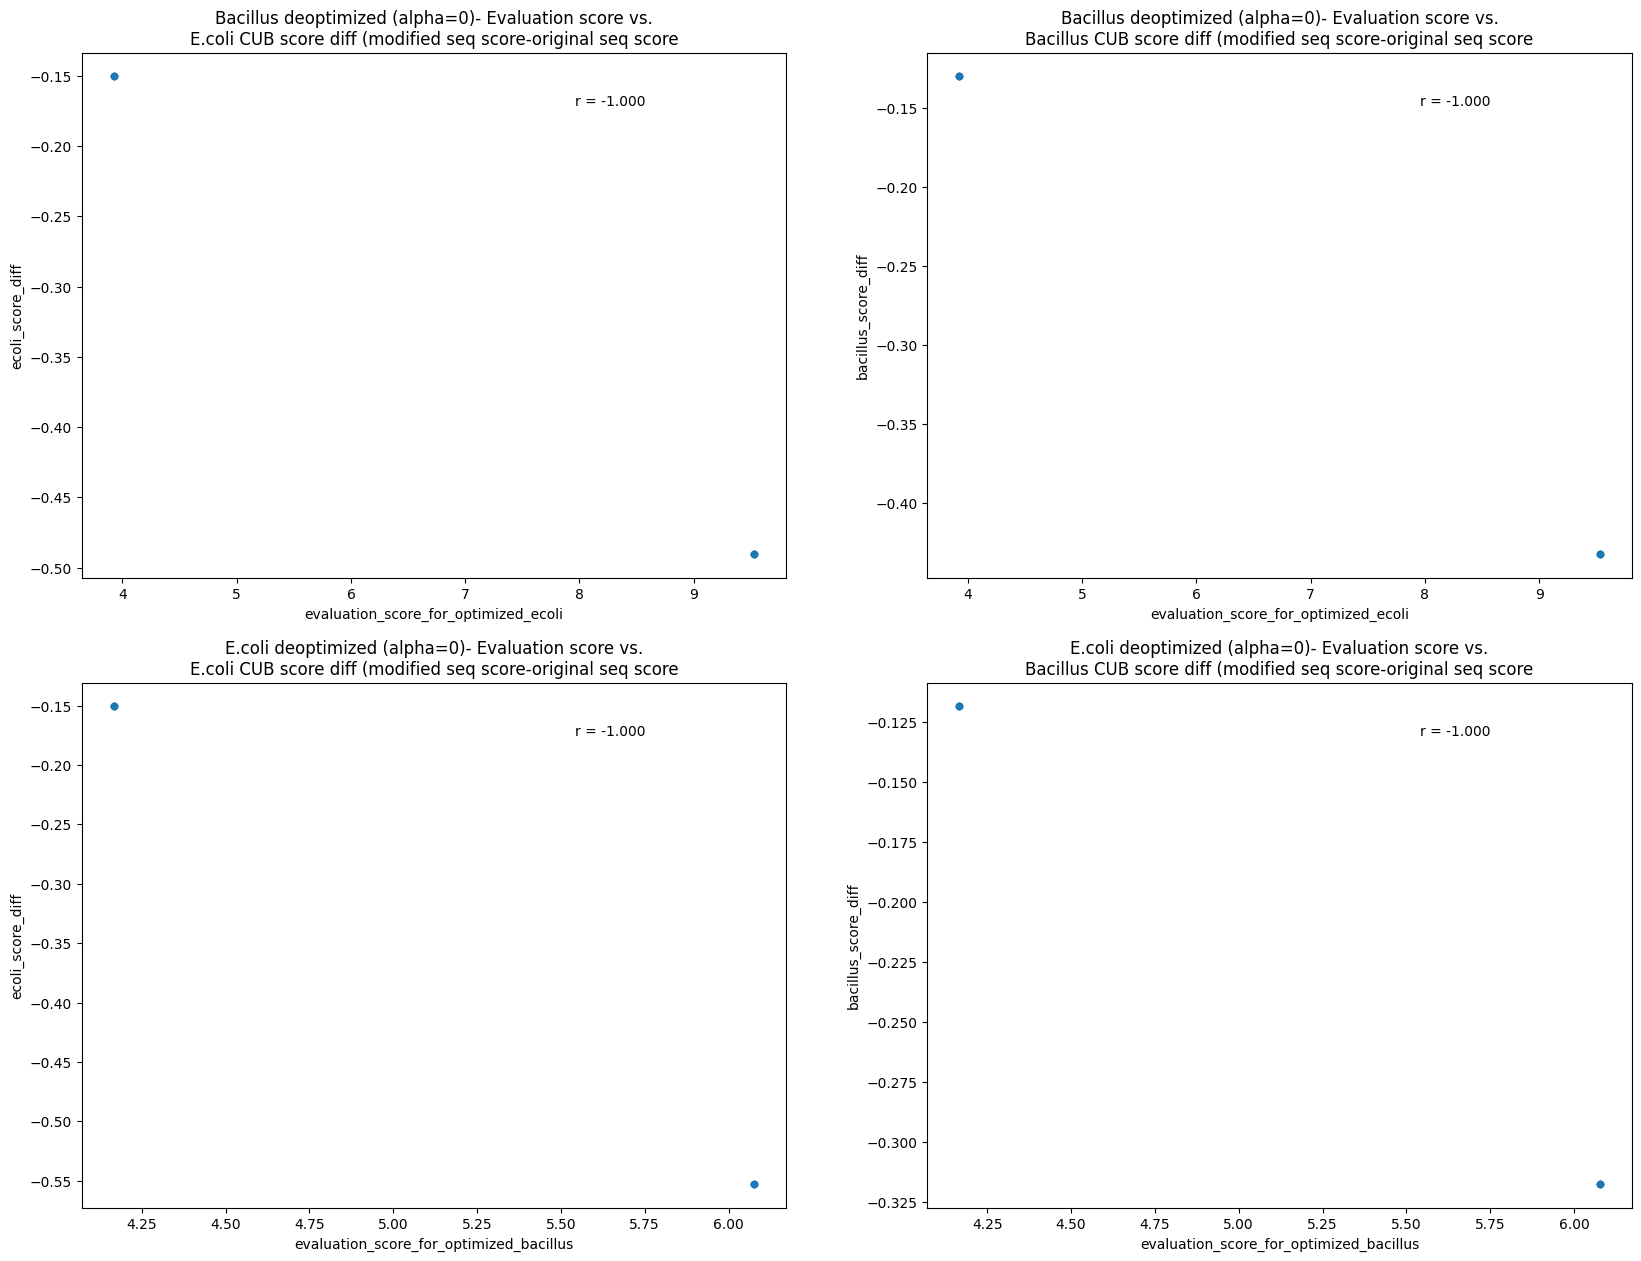

In [64]:
merged_df_ecoli_lower_alpha = pd.merge(evaluation_ecoli_opt_lower_alpha_variants_dataframe, cub_ecoli_opt_lower_alpha_variants_dataframe, on='variant', how='inner')
merged_df_ecoli_lower_alpha['ecoli_score_diff'] = merged_df_ecoli_lower_alpha['ecoli_final_score'] - merged_df_ecoli_lower_alpha['ecoli_initial_score']
merged_df_ecoli_lower_alpha['bacillus_score_diff'] = merged_df_ecoli_lower_alpha['bacillus_final_score'] - merged_df_ecoli_lower_alpha['bacillus_initial_score']

merged_df_bacillus_lower_alpha = pd.merge(evaluation_bacillus_opt_lower_alpha_variants_dataframe, cub_bacillus_opt_lower_alpha_variants_dataframe, on='variant', how='inner')
merged_df_bacillus_lower_alpha['ecoli_score_diff'] = merged_df_bacillus_lower_alpha['ecoli_final_score'] - merged_df_bacillus_lower_alpha['ecoli_initial_score']
merged_df_bacillus_lower_alpha['bacillus_score_diff'] = merged_df_bacillus_lower_alpha['bacillus_final_score'] - merged_df_bacillus_lower_alpha['bacillus_initial_score']

fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(20,15))

scatter = merged_df_ecoli_lower_alpha.plot.scatter(x="evaluation_score_for_optimized_ecoli", y="ecoli_score_diff", ax=axes[0,0], title="Bacillus deoptimized (alpha=0)- Evaluation score vs.\nE.coli CUB score diff (modified seq score-original seq score")
r, p = stats.spearmanr(merged_df_ecoli_lower_alpha["evaluation_score_for_optimized_ecoli"], merged_df_ecoli_lower_alpha["ecoli_score_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df_ecoli_lower_alpha.plot.scatter(x="evaluation_score_for_optimized_ecoli", y="bacillus_score_diff", ax=axes[0,1], title="Bacillus deoptimized (alpha=0)- Evaluation score vs.\nBacillus CUB score diff (modified seq score-original seq score")
r, p = stats.spearmanr(merged_df_ecoli_lower_alpha["evaluation_score_for_optimized_ecoli"], merged_df_ecoli_lower_alpha["bacillus_score_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df_bacillus_lower_alpha.plot.scatter(x="evaluation_score_for_optimized_bacillus", y="ecoli_score_diff", ax=axes[1,0], title="E.coli deoptimized (alpha=0)- Evaluation score vs.\nE.coli CUB score diff (modified seq score-original seq score")
r, p = stats.spearmanr(merged_df_bacillus_lower_alpha["evaluation_score_for_optimized_bacillus"], merged_df_bacillus_lower_alpha["ecoli_score_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df_bacillus_lower_alpha.plot.scatter(x="evaluation_score_for_optimized_bacillus", y="bacillus_score_diff", ax=axes[1,1], title="E.coli deoptimized (alpha=0)- Evaluation score vs.\nBacillus CUB score diff (modified seq score-original seq score")
r, p = stats.spearmanr(merged_df_bacillus_lower_alpha["evaluation_score_for_optimized_bacillus"], merged_df_bacillus_lower_alpha["bacillus_score_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

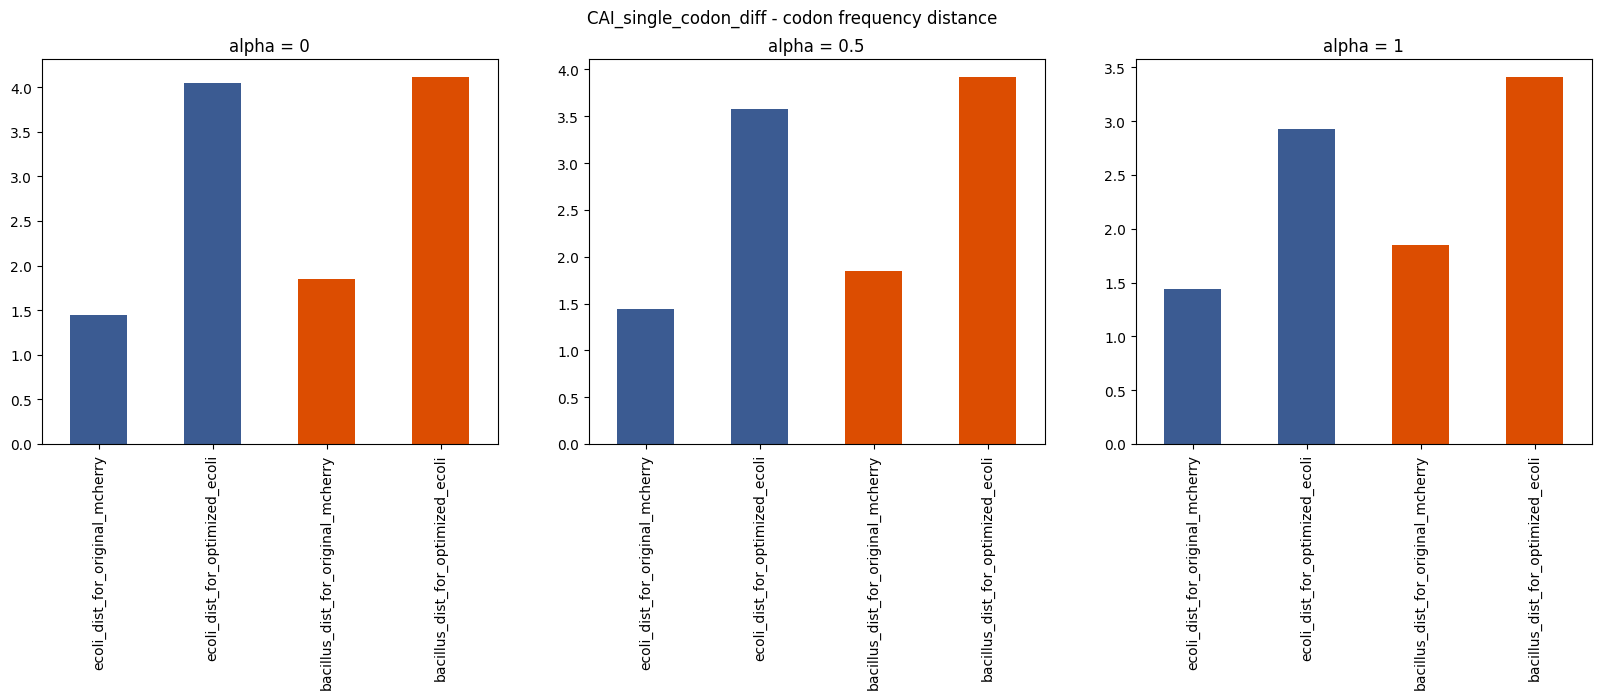

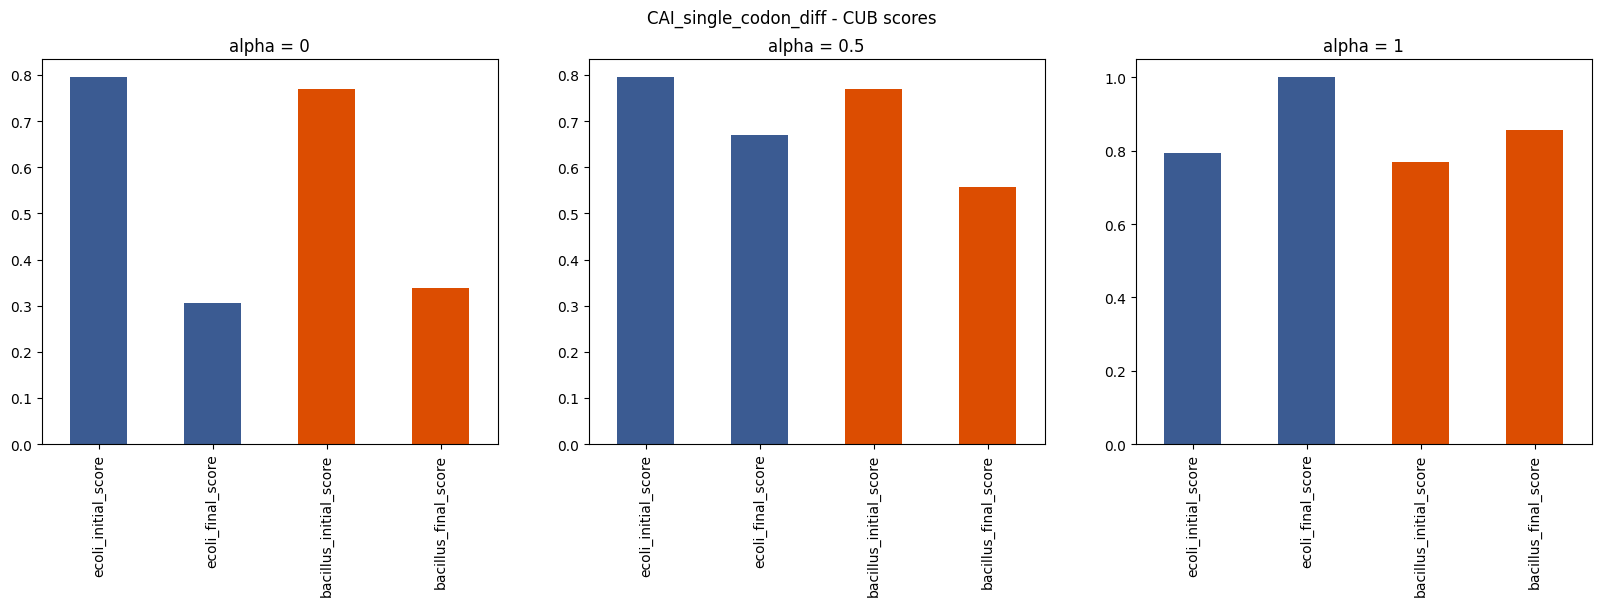

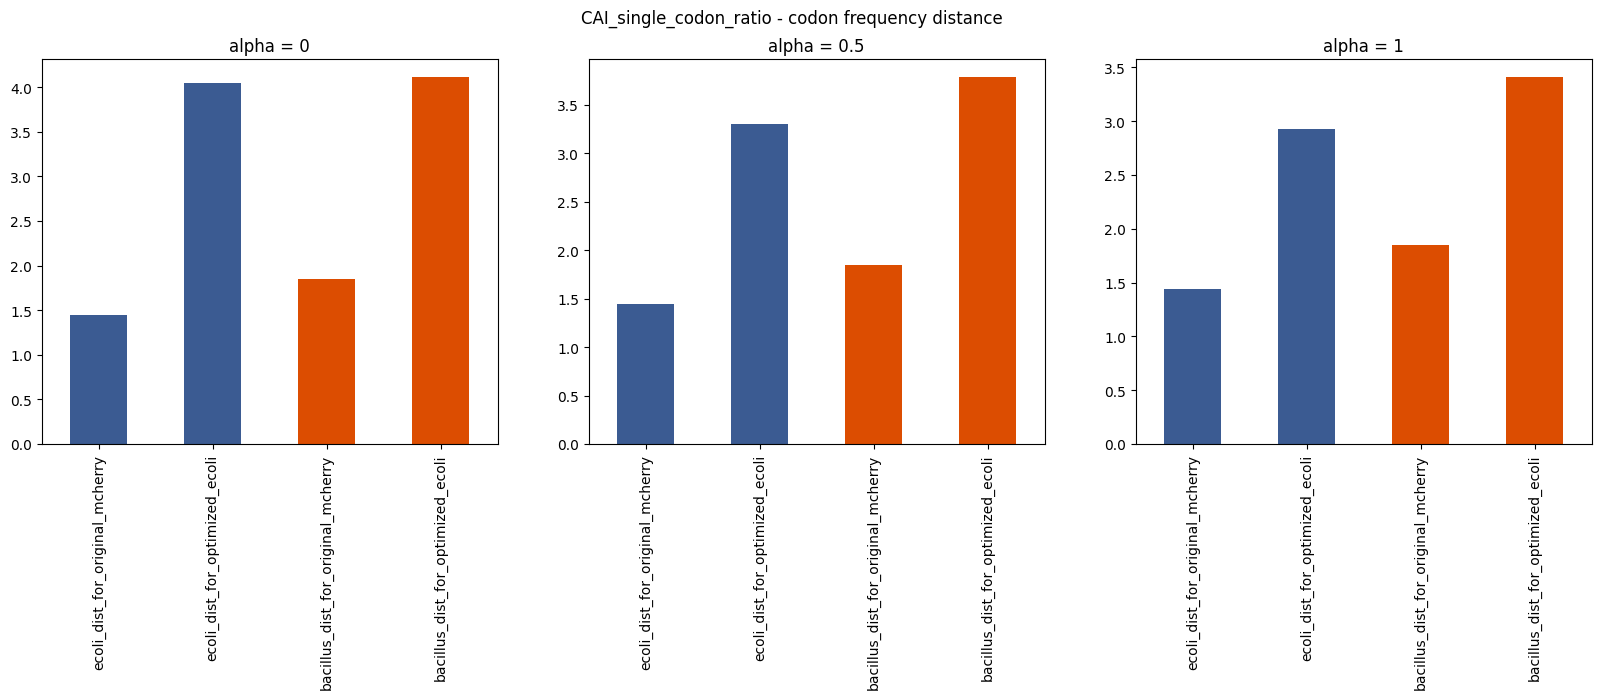

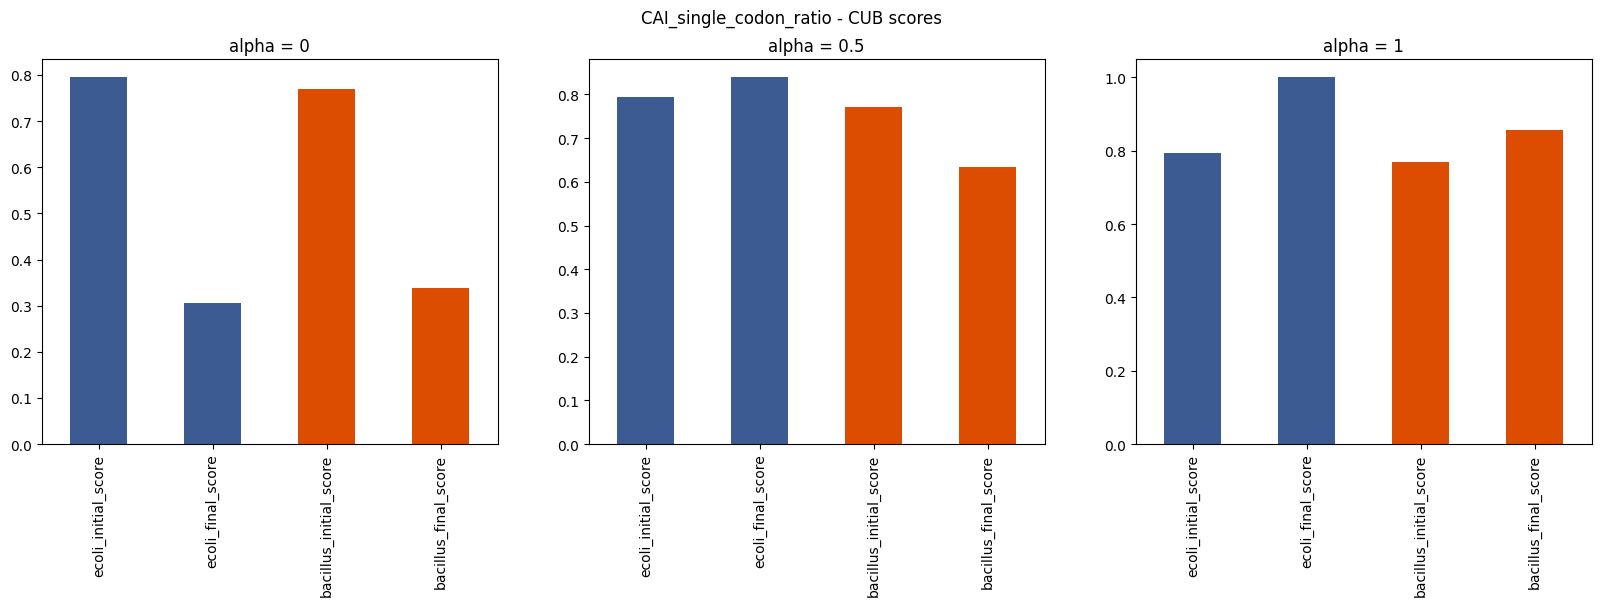

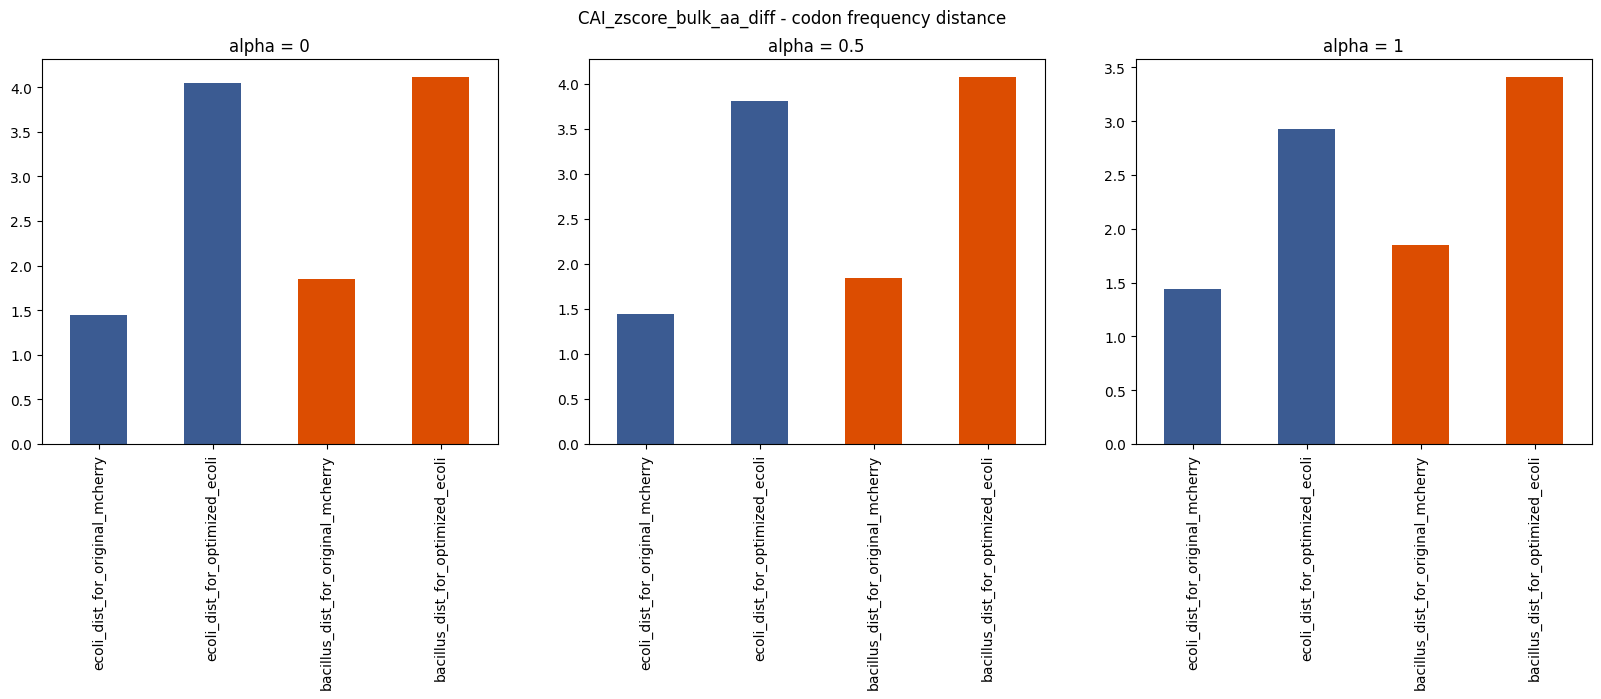

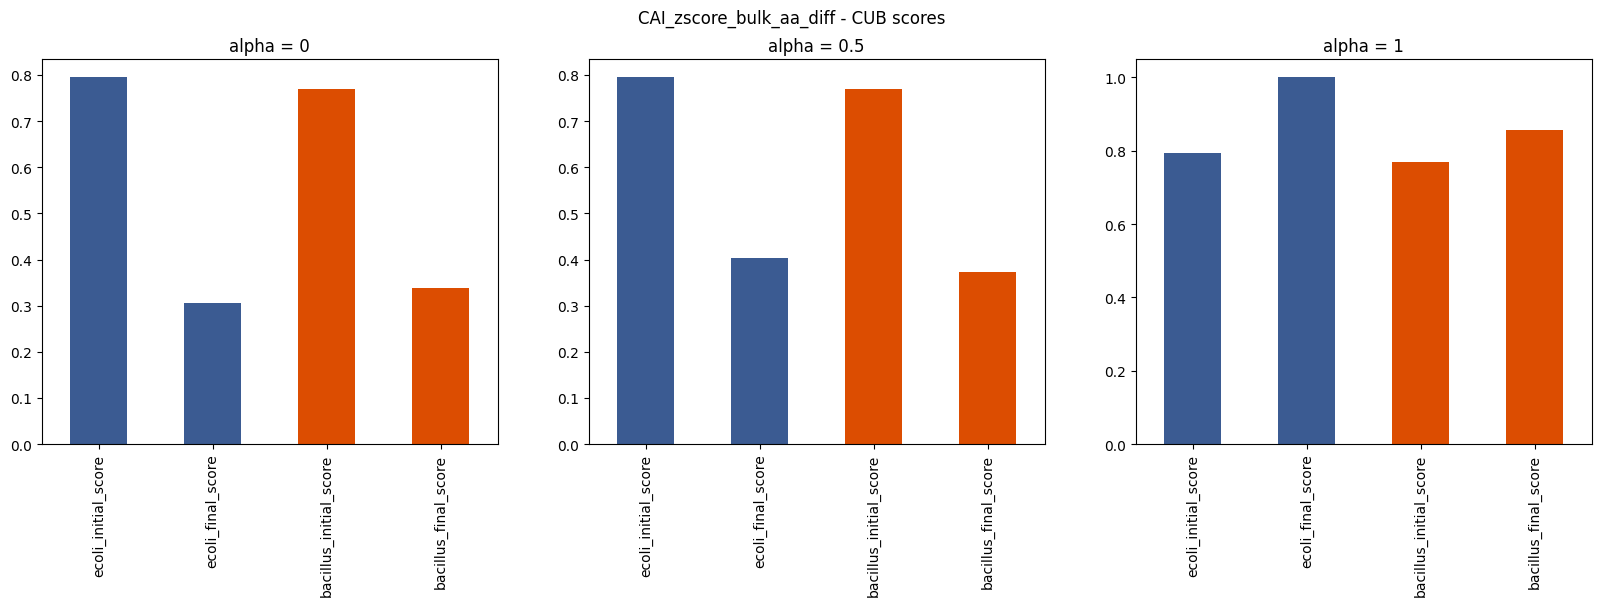

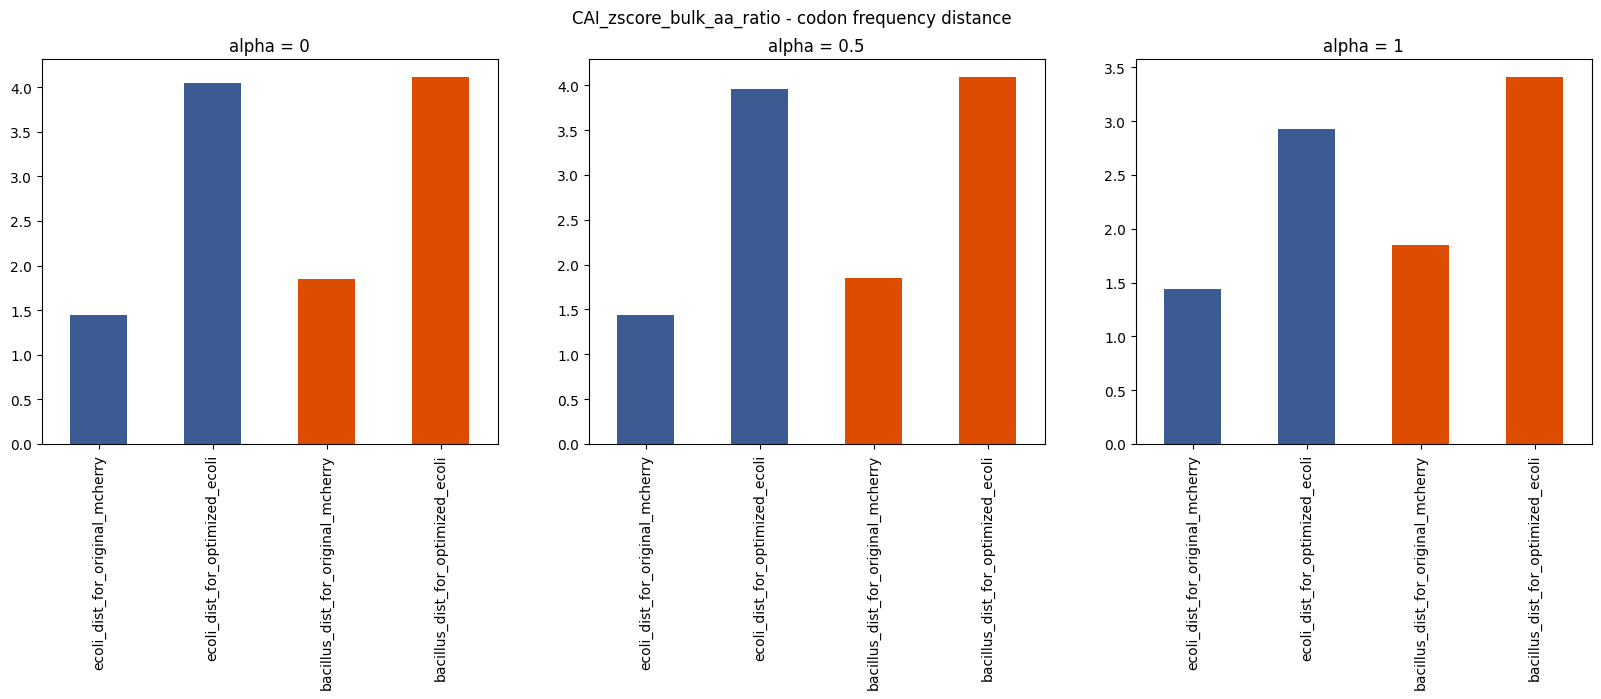

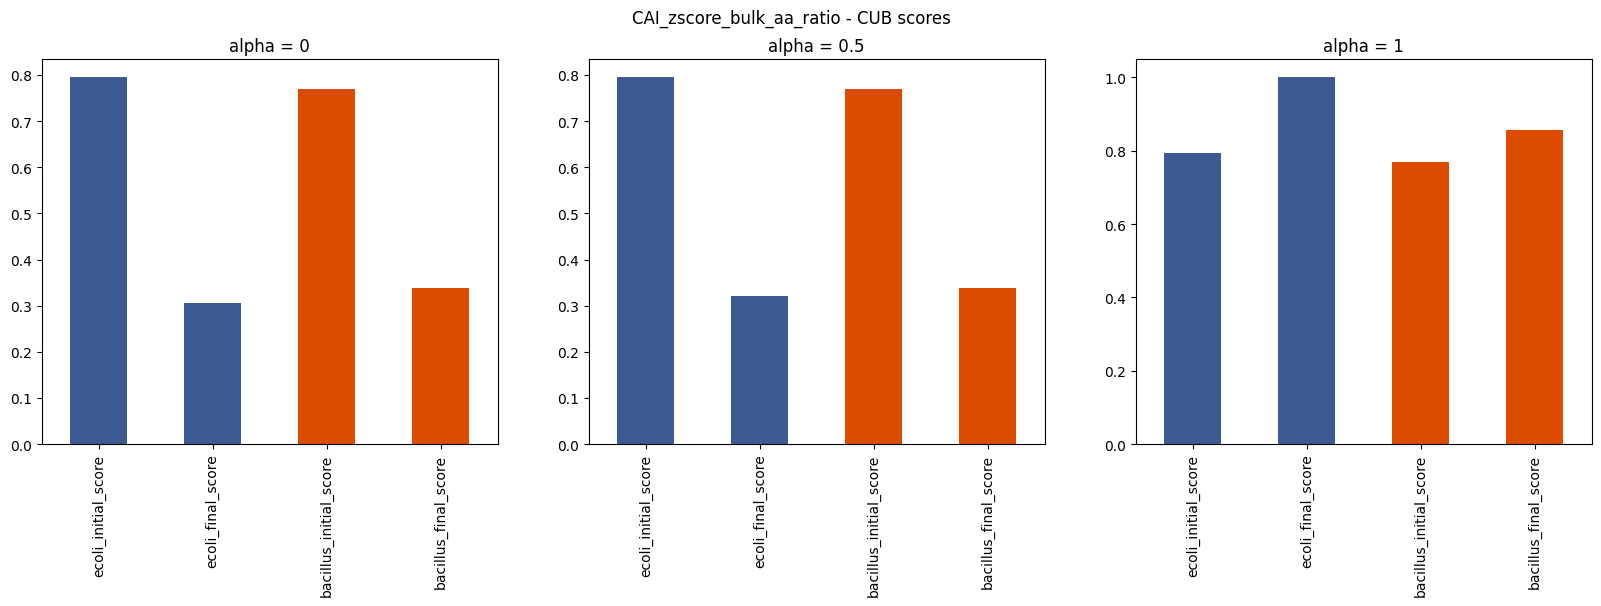

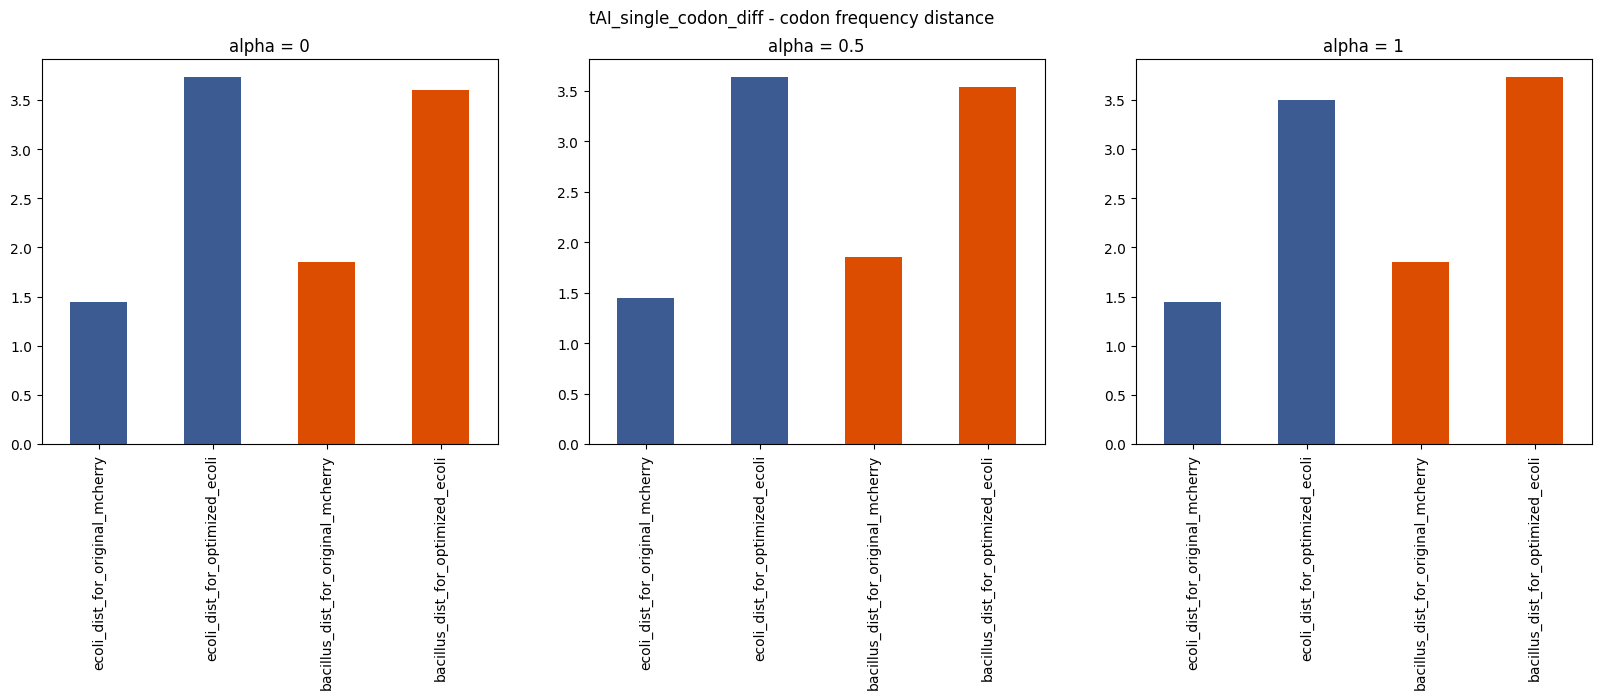

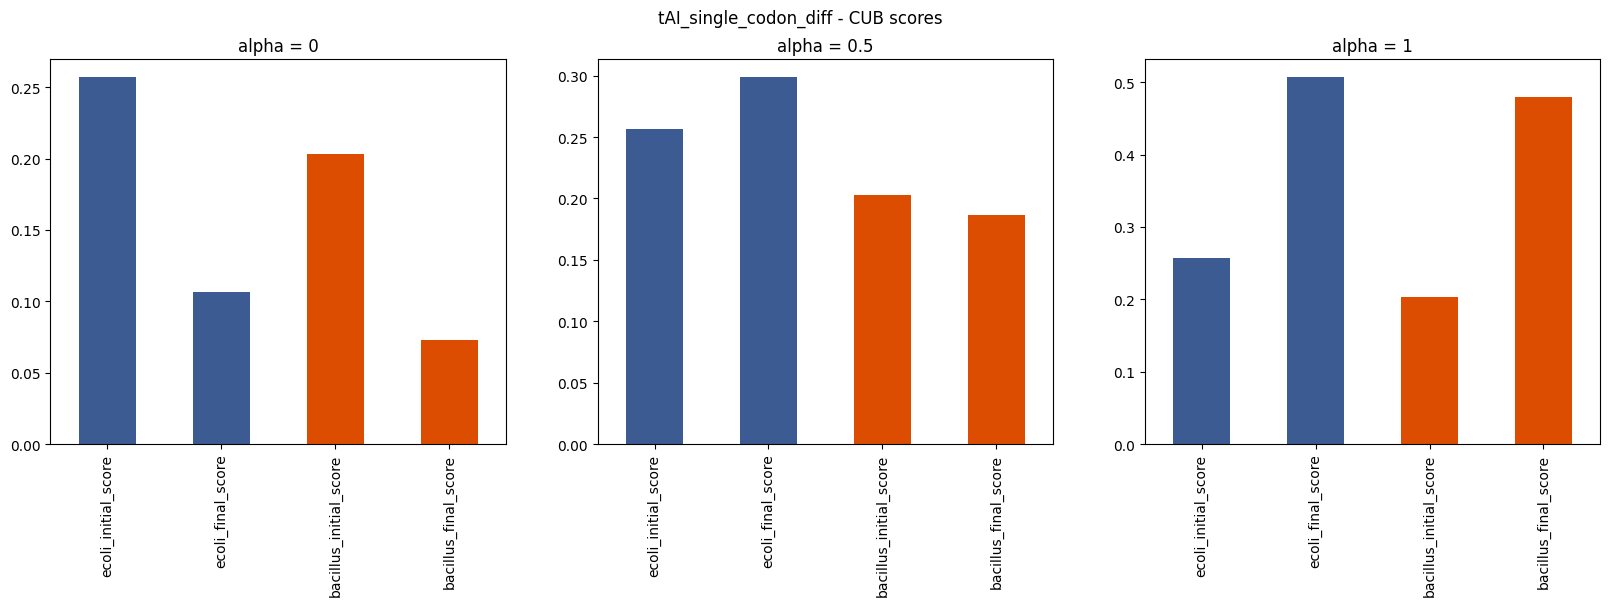

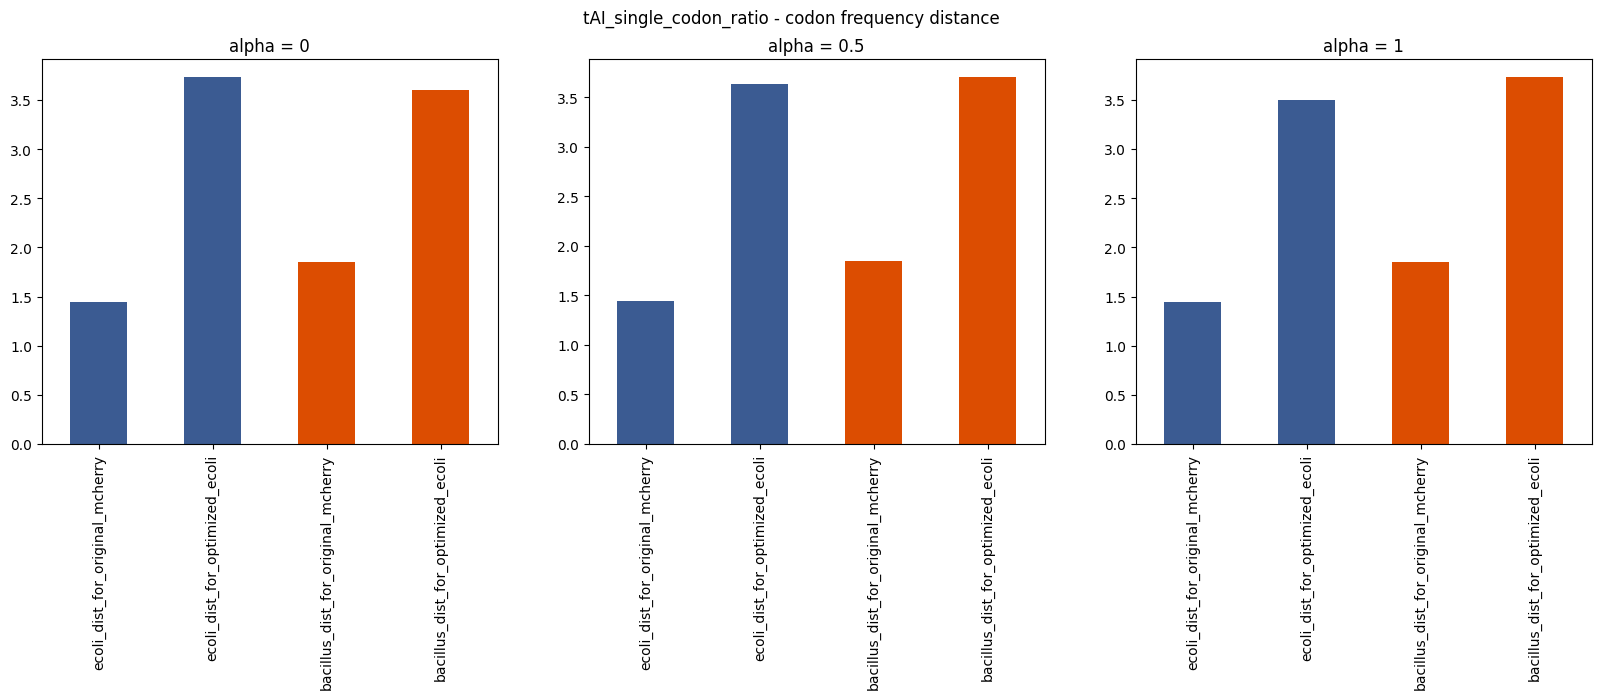

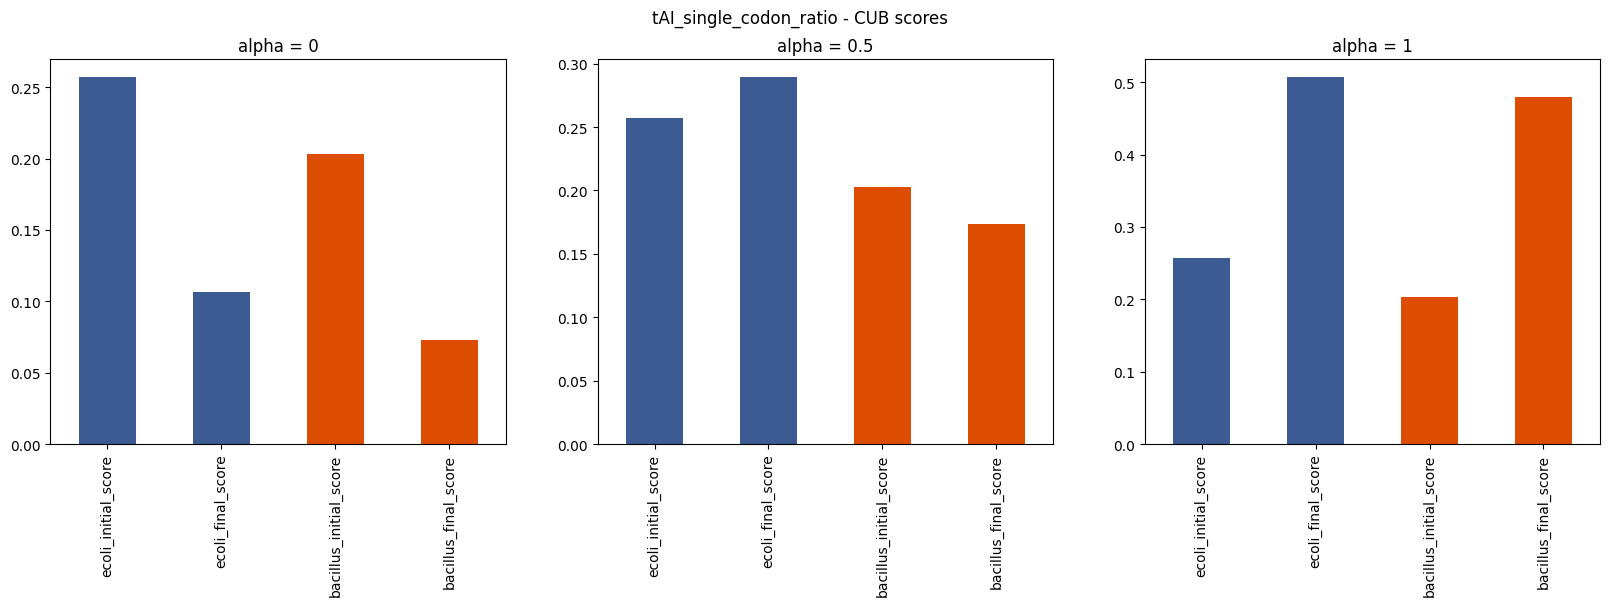

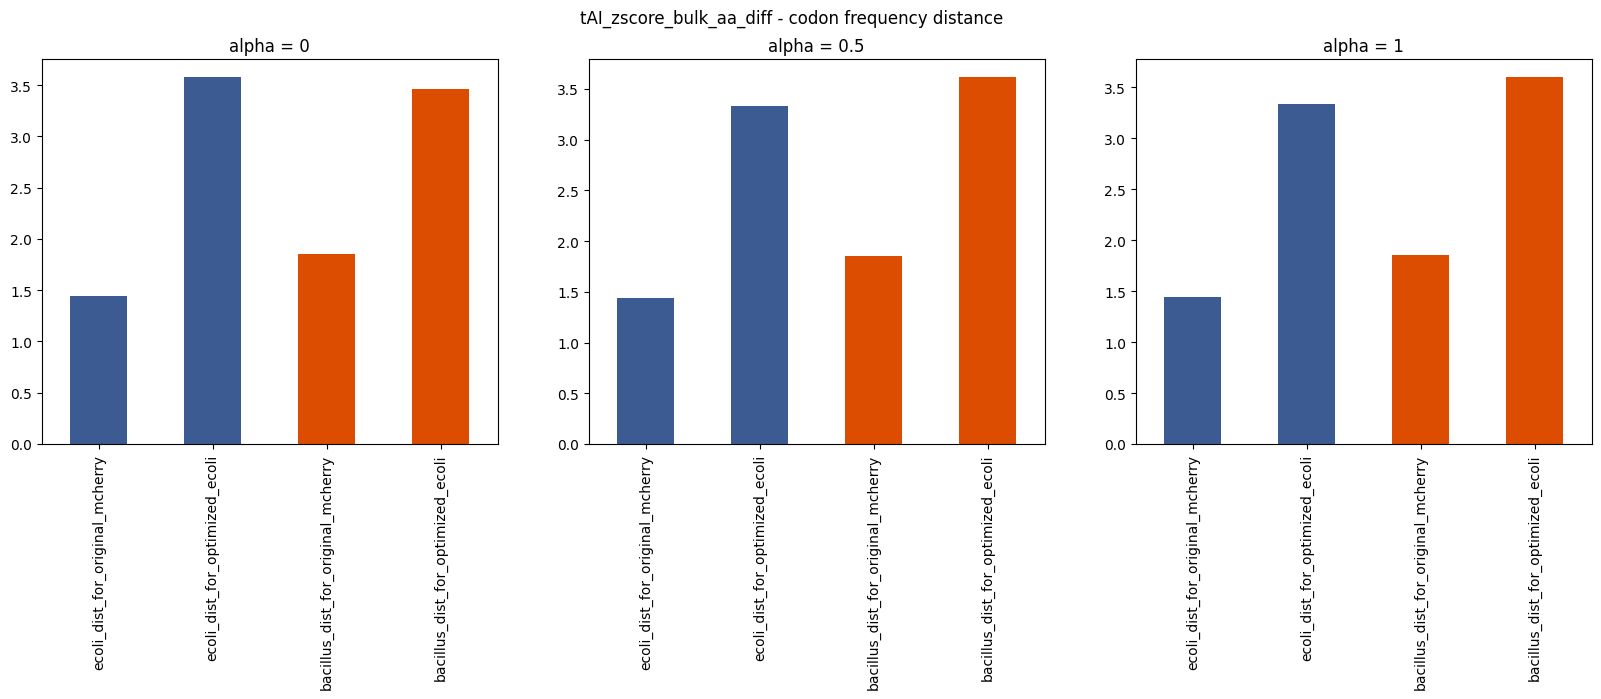

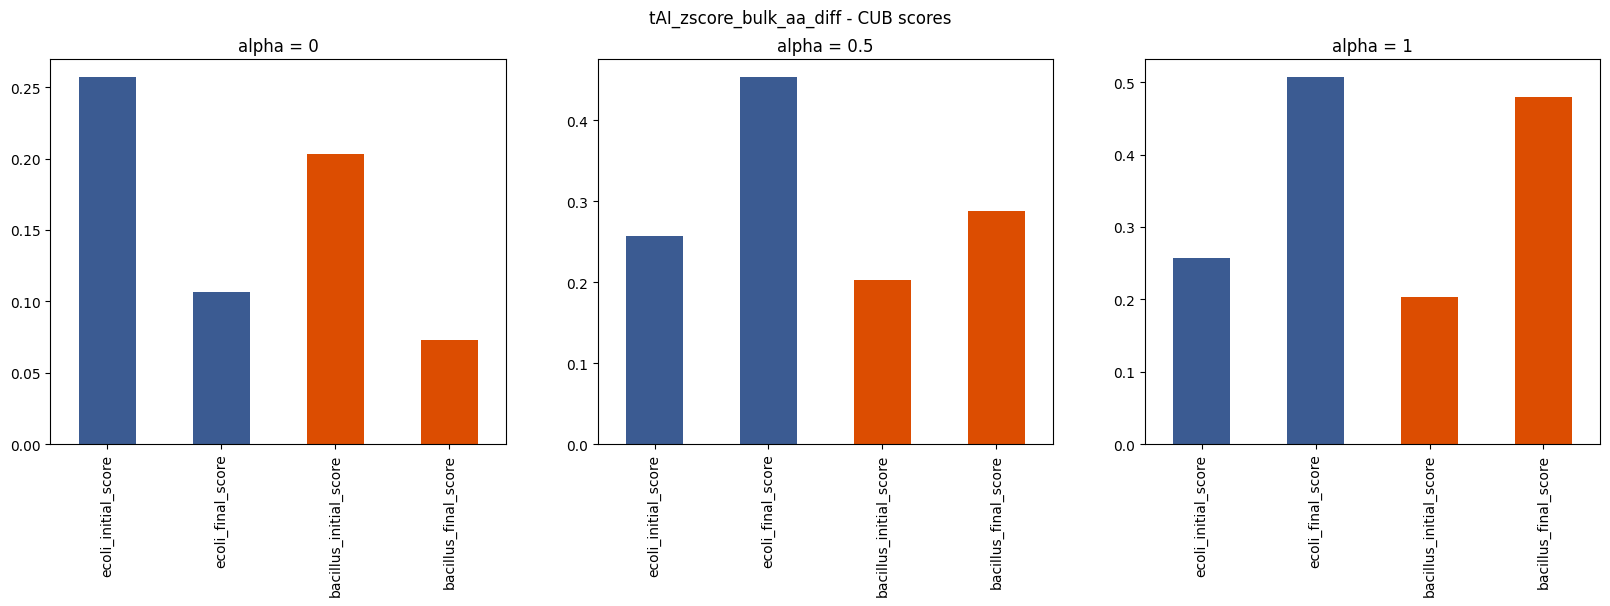

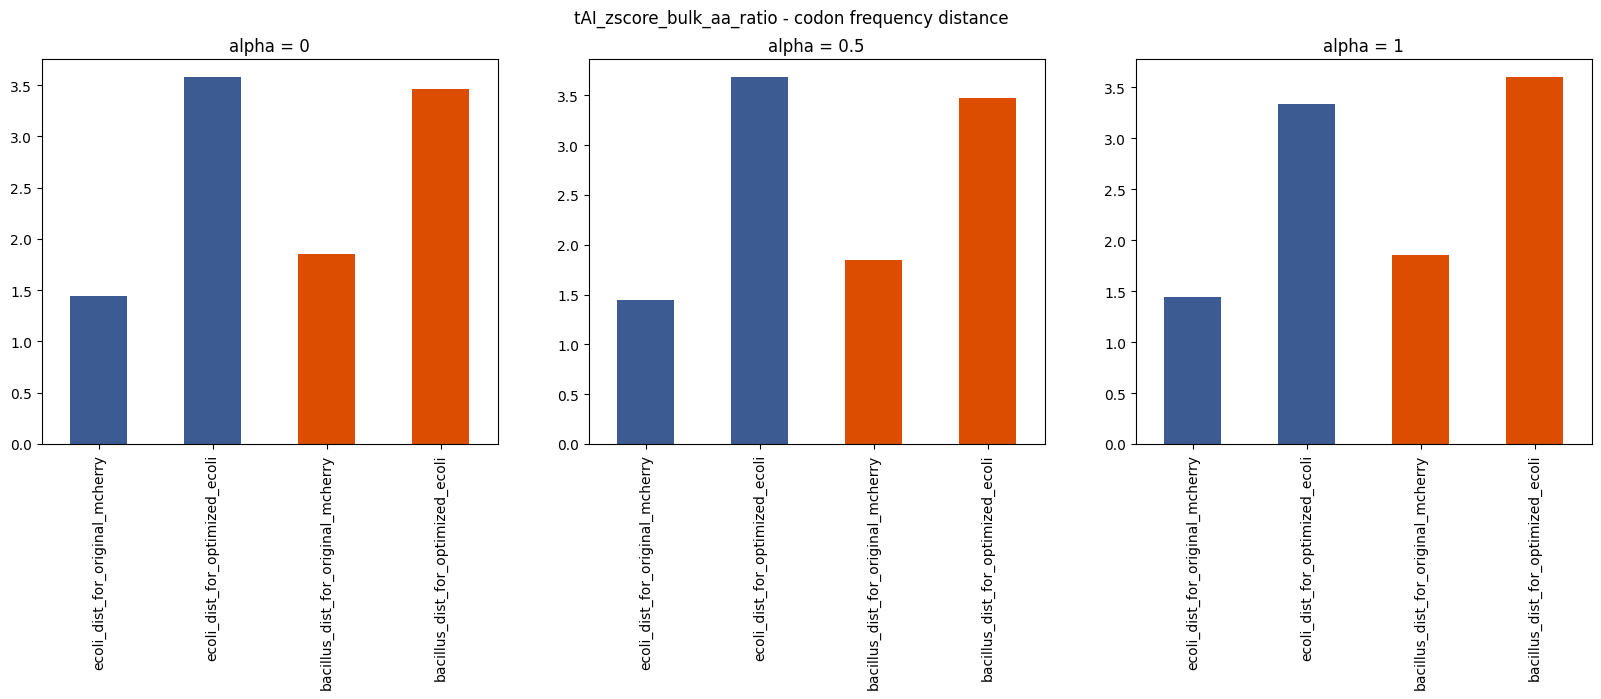

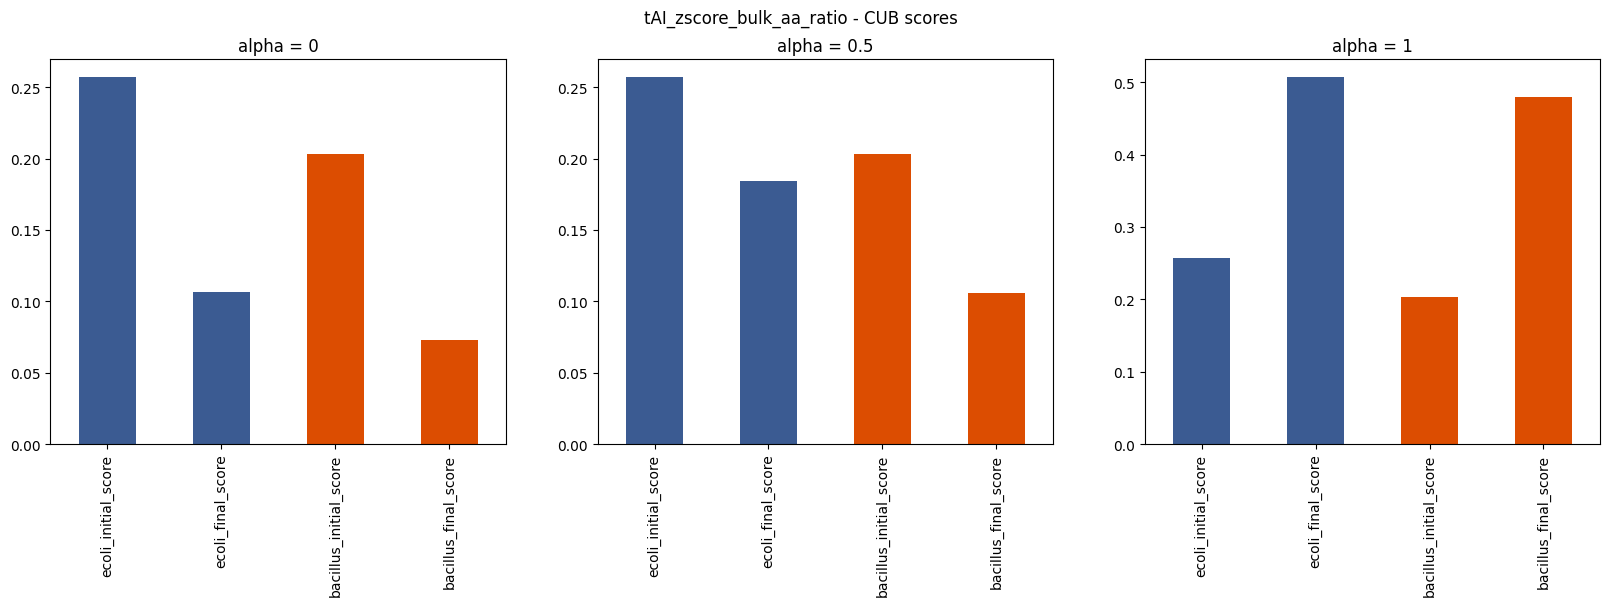

In [65]:
my_colors = ['#3b5b92', '#3b5b92', '#dc4d01', '#dc4d01'] 
for q in range(cub_ecoli_opt_greater_alpha_variants_dataframe.shape[0]):

    fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(20,5))
    fig.suptitle(greater_alpha_ecoli_opt_variants_dataframe.iloc[q,0] + " - codon frequency distance")
    lower_alpha_ecoli_opt_variants_dataframe.iloc[q,1:].plot(x="variant", kind="bar", ax=axes[0], stacked=True, color=my_colors)
    axes[0].set_title("alpha = 0")
    ecoli_opt_variants_dataframe.iloc[q,1:].plot(x="variant", kind="bar", ax=axes[1], stacked=True, color=my_colors)
    axes[1].set_title("alpha = 0.5")
    greater_alpha_ecoli_opt_variants_dataframe.iloc[q,1:].plot(x="variant", kind="bar", ax=axes[2], stacked=True, color=my_colors)
    axes[2].set_title("alpha = 1")


    fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(20,5))
    fig.suptitle(cub_ecoli_opt_greater_alpha_variants_dataframe.iloc[q,0] + " - CUB scores")
    cub_ecoli_opt_lower_alpha_variants_dataframe.iloc[q,1:].plot(x="variant", kind="bar", ax=axes[0], stacked=True, color=my_colors)
    axes[0].set_title("alpha = 0")
    cub_ecoli_opt_variants_dataframe.iloc[q,1:].plot(x="variant", kind="bar", ax=axes[1], stacked=True, color=my_colors)
    axes[1].set_title("alpha = 0.5")
    cub_ecoli_opt_greater_alpha_variants_dataframe.iloc[q,1:].plot(x="variant", kind="bar", ax=axes[2], stacked=True, color=my_colors)
    axes[2].set_title("alpha = 1")

## Optimizing for Bacillus

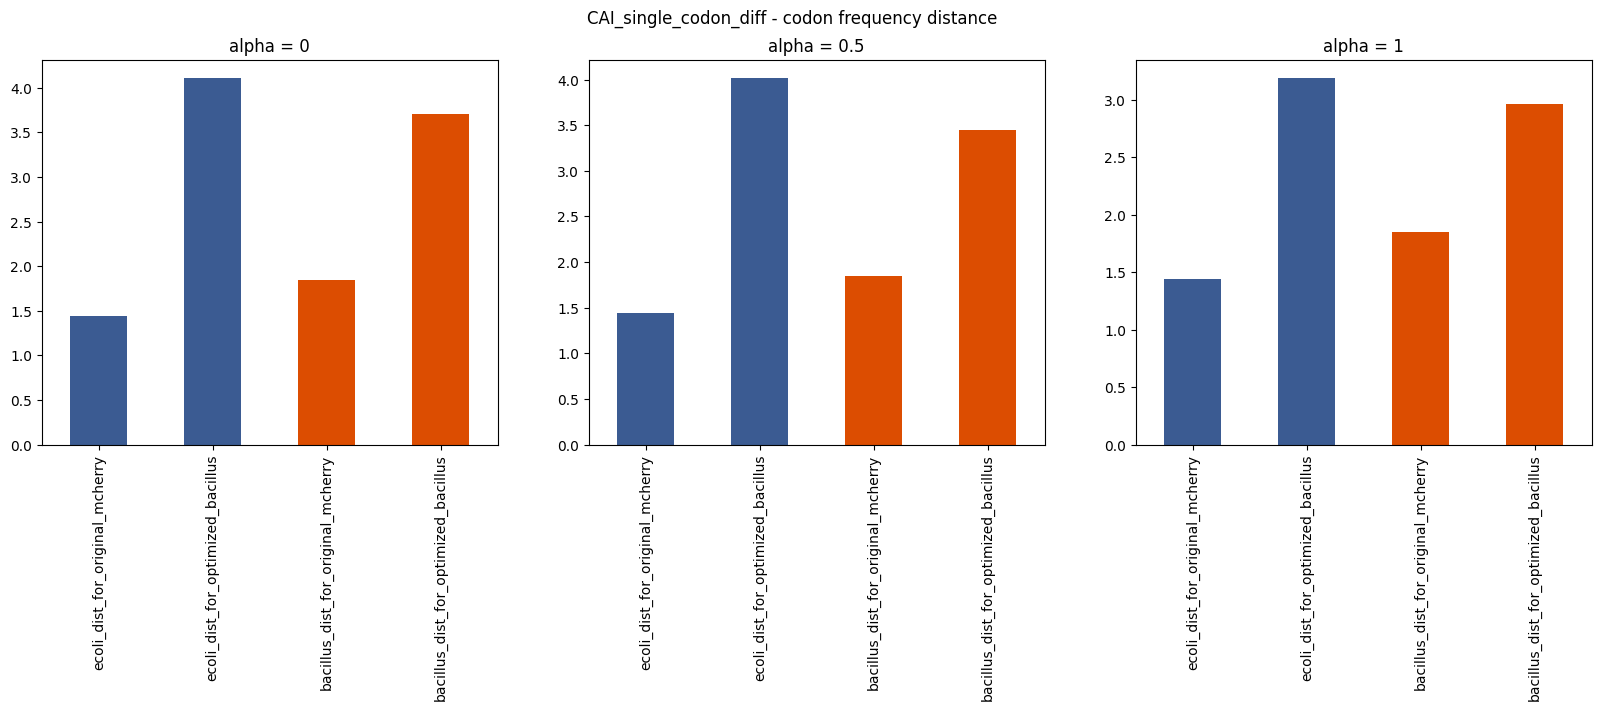

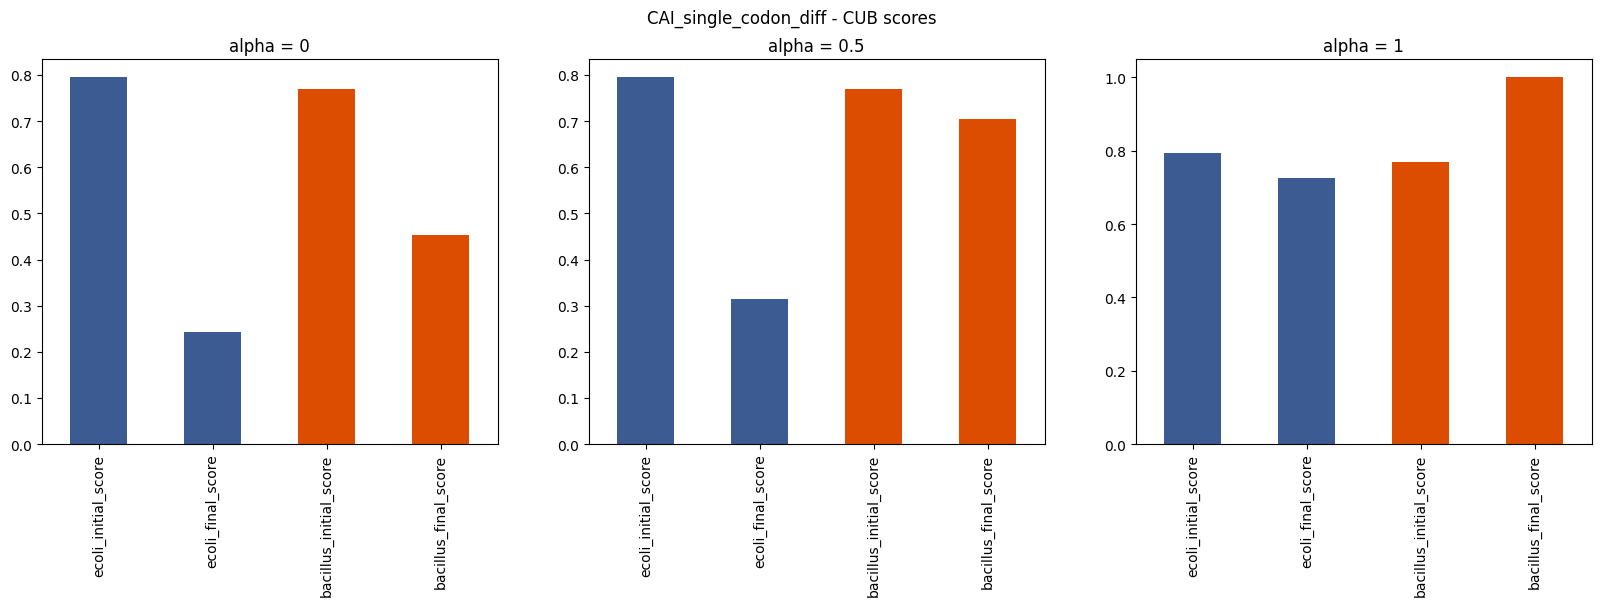

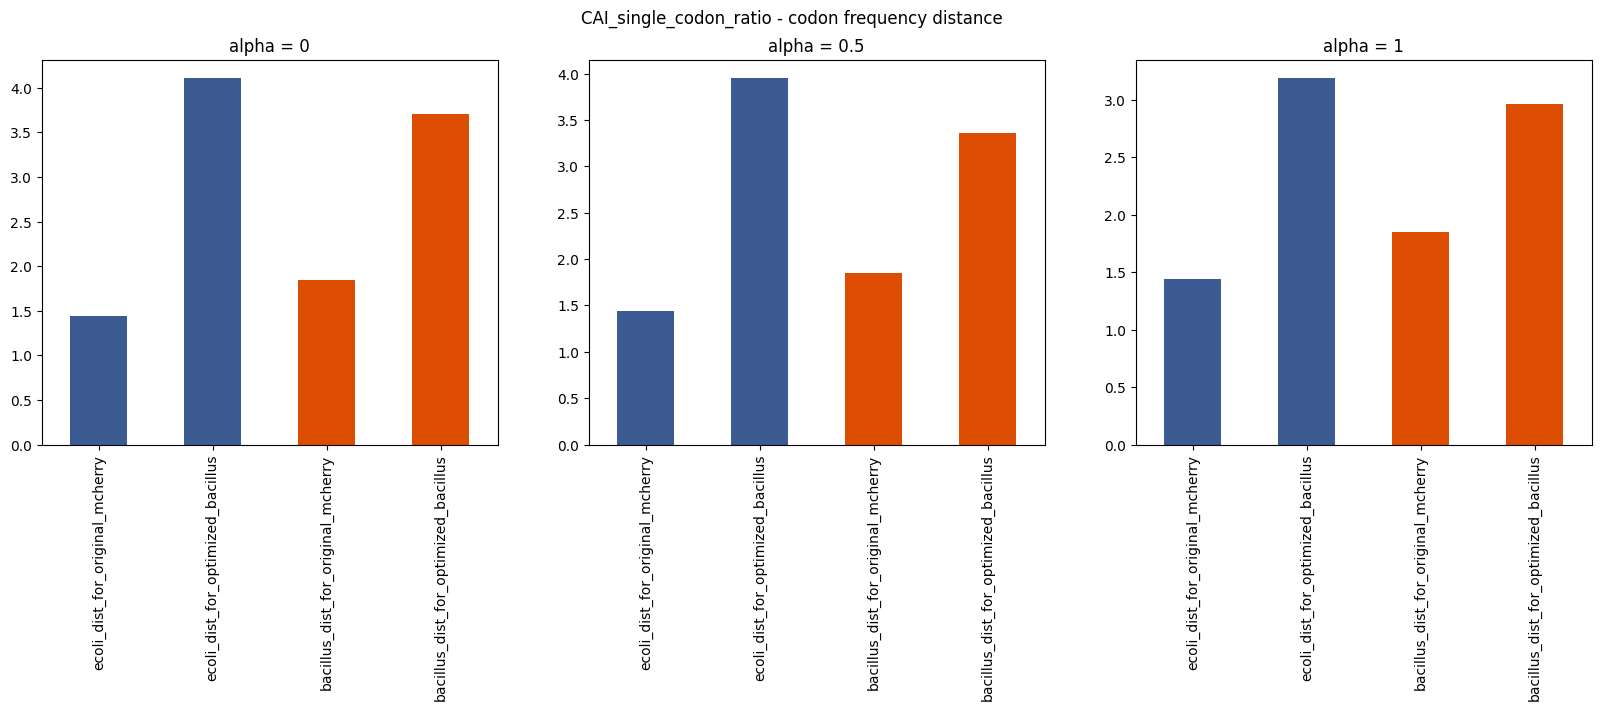

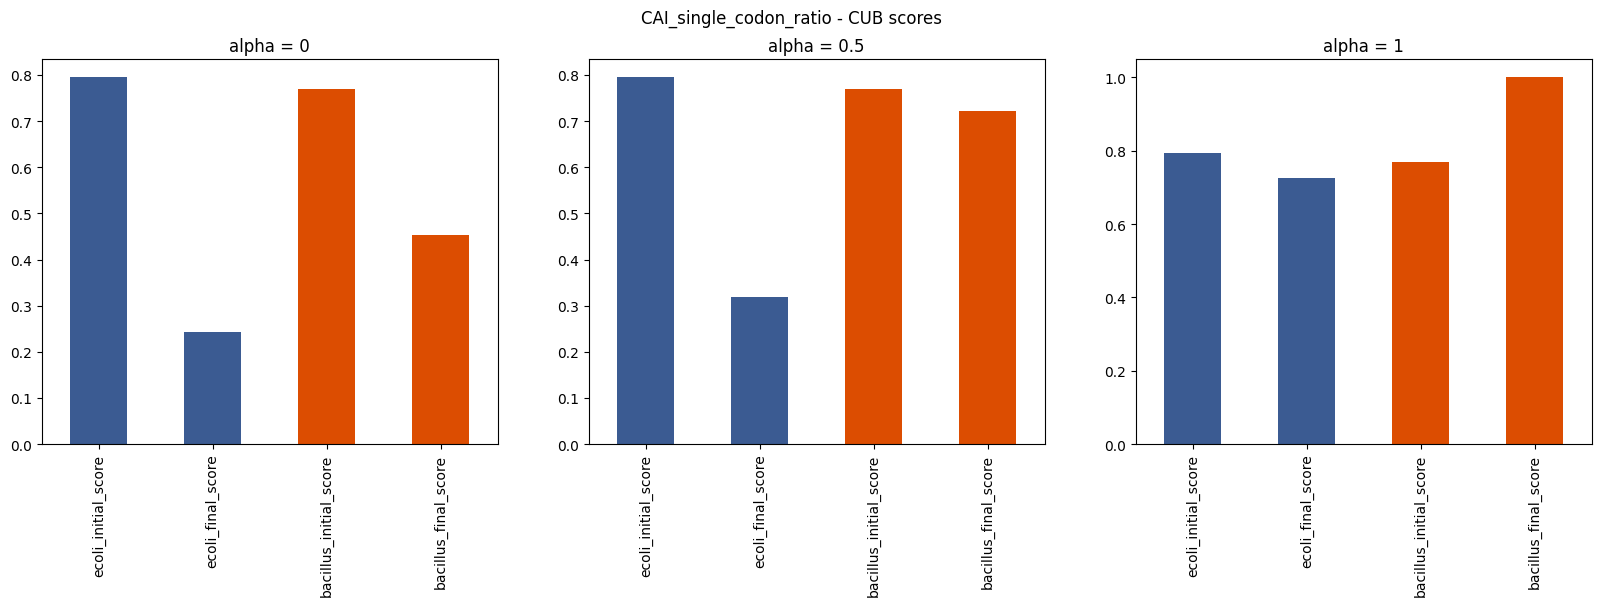

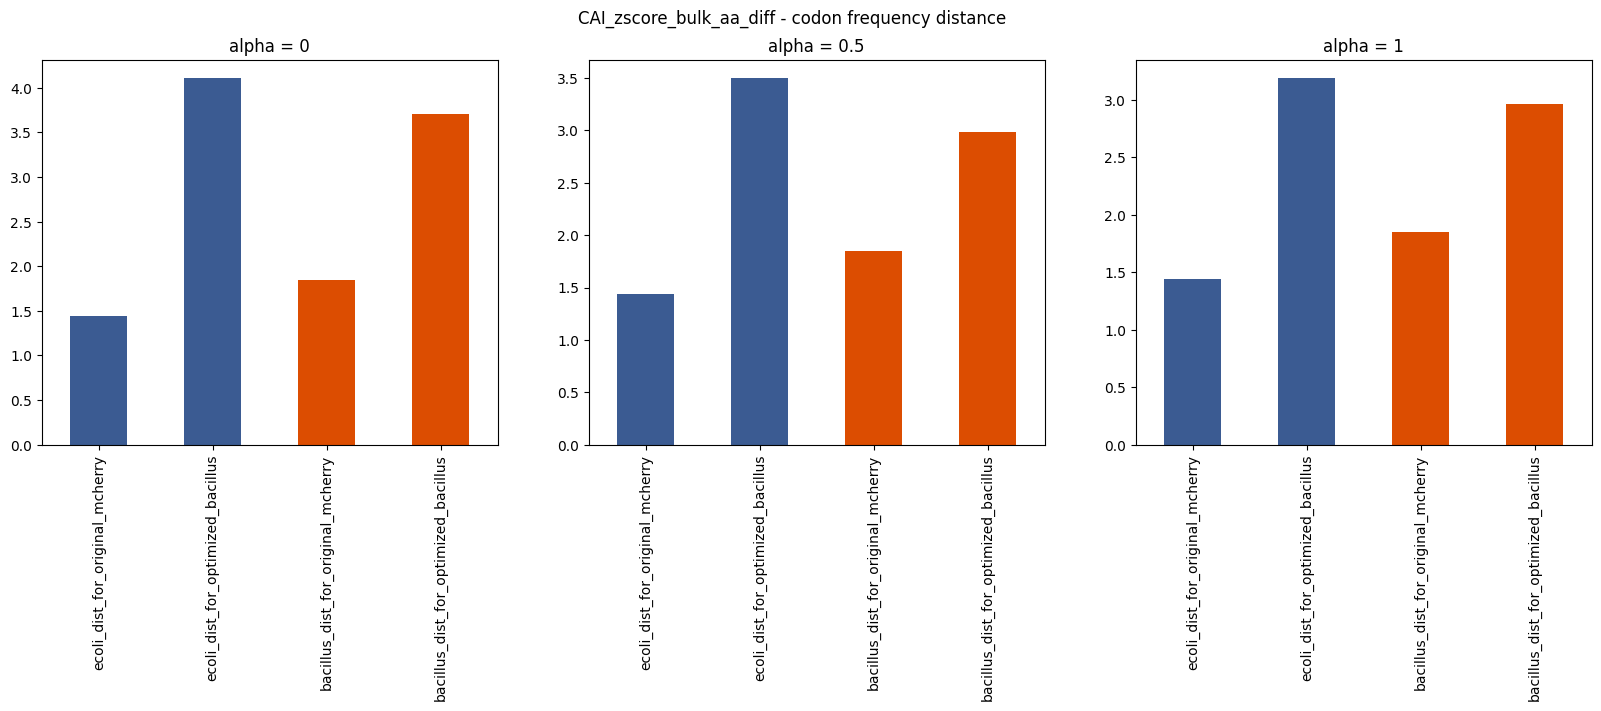

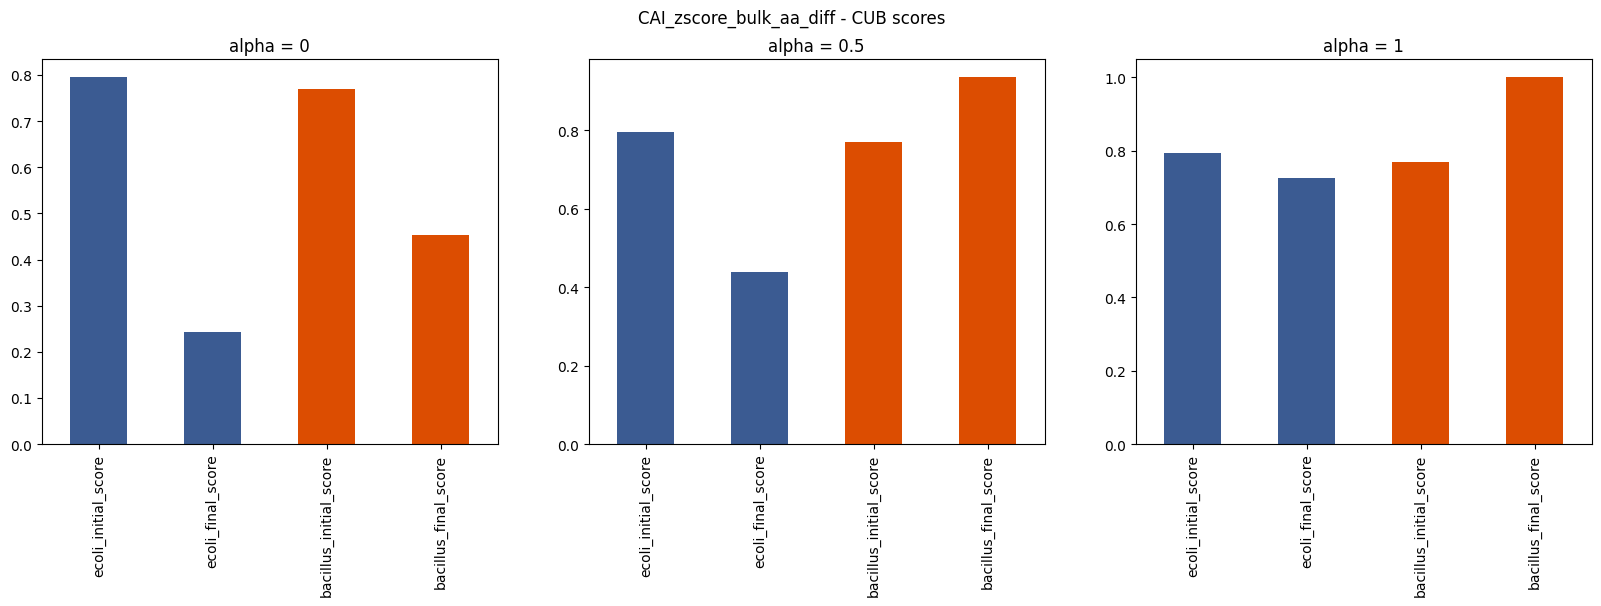

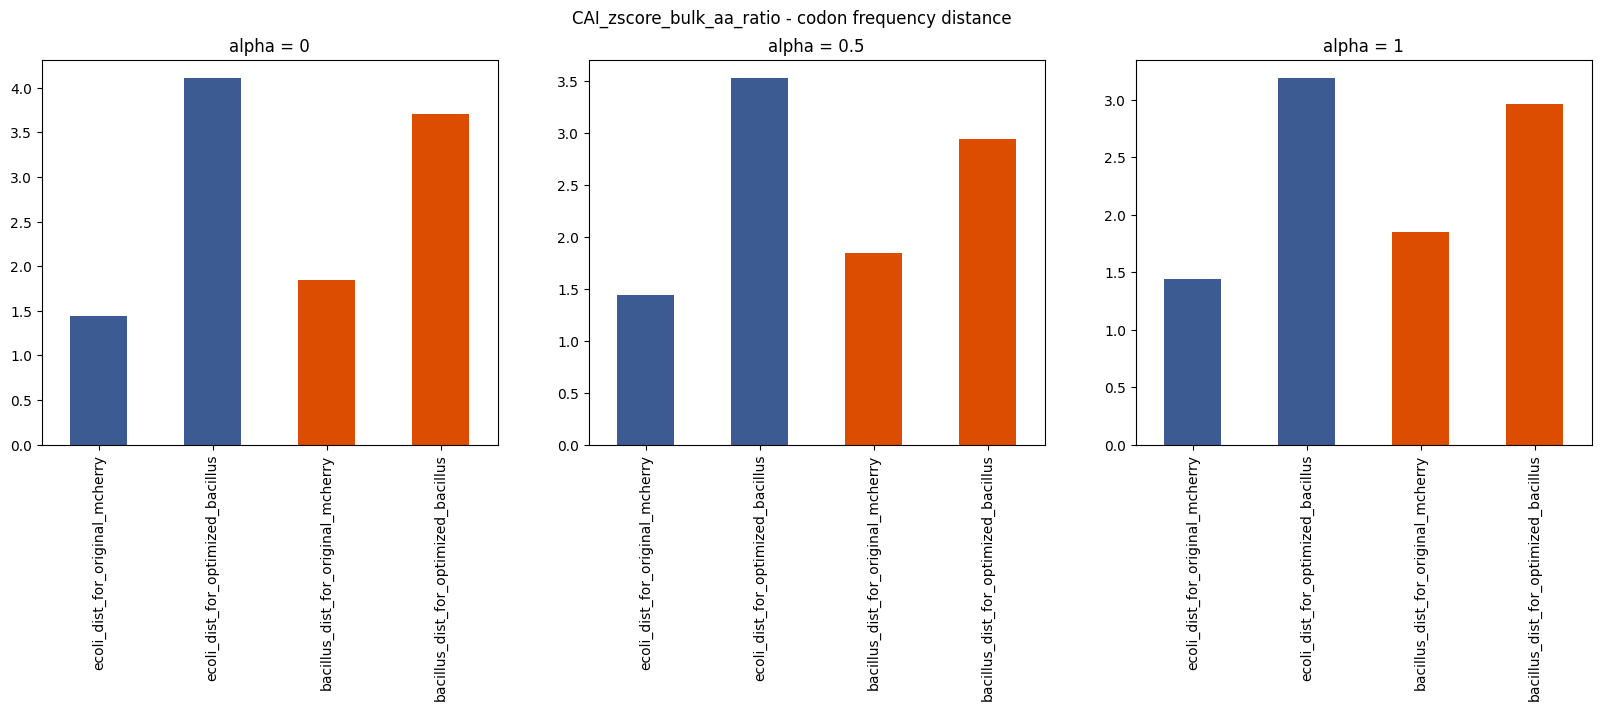

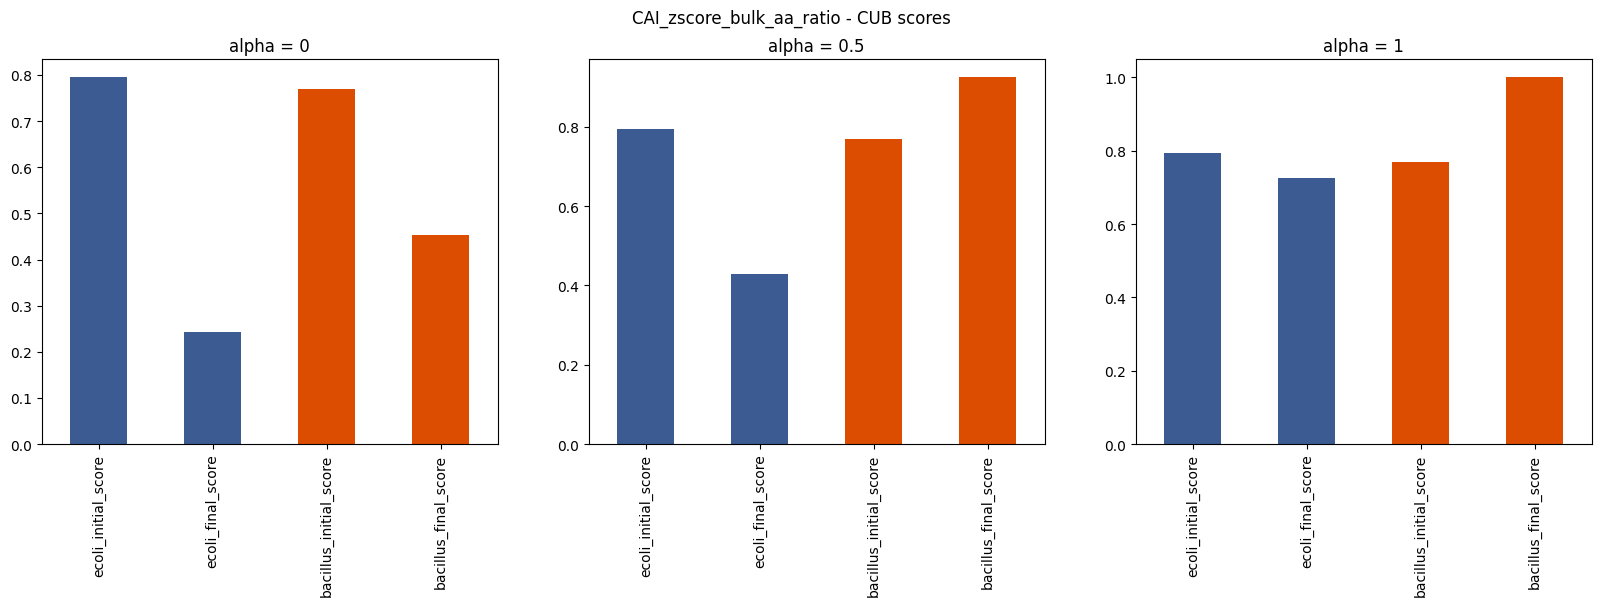

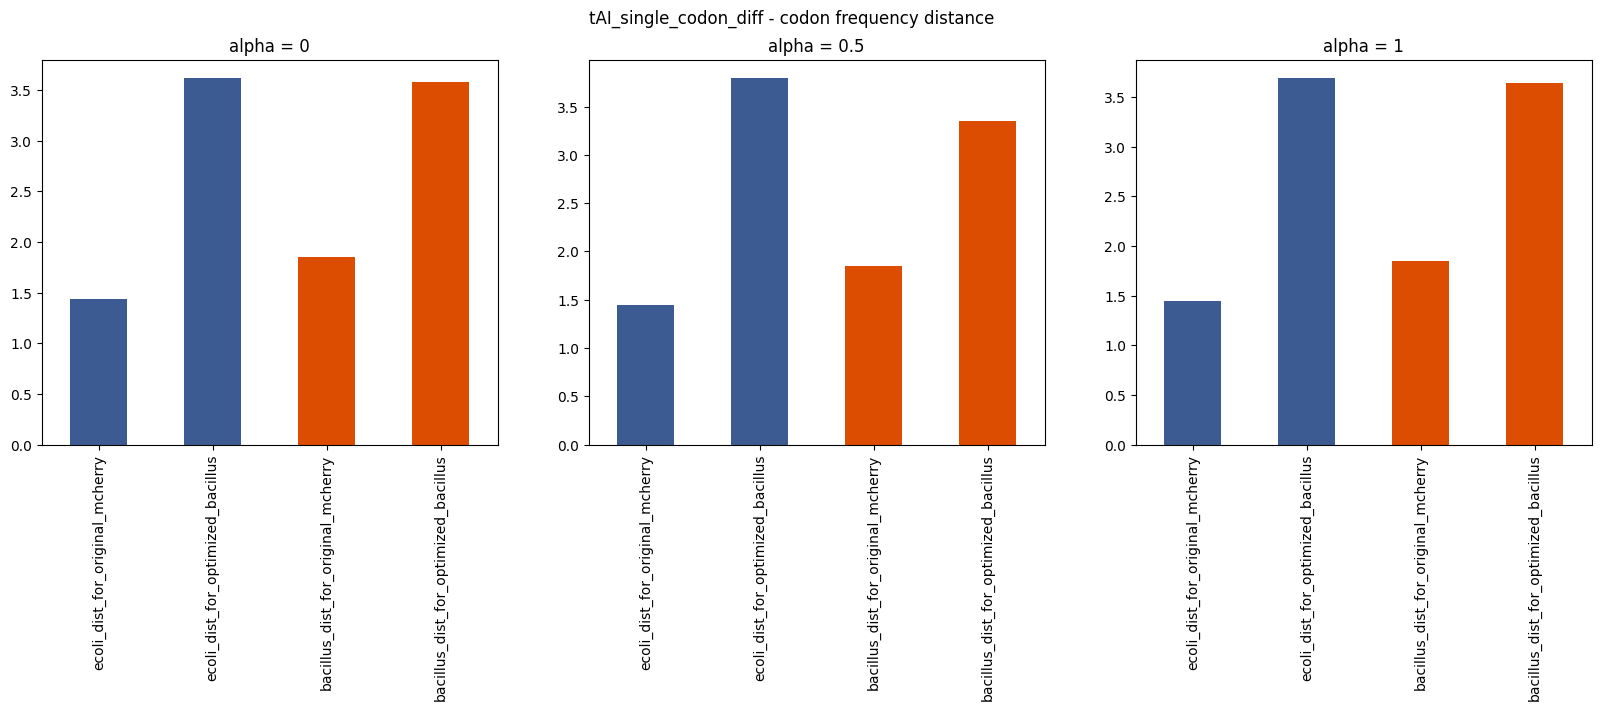

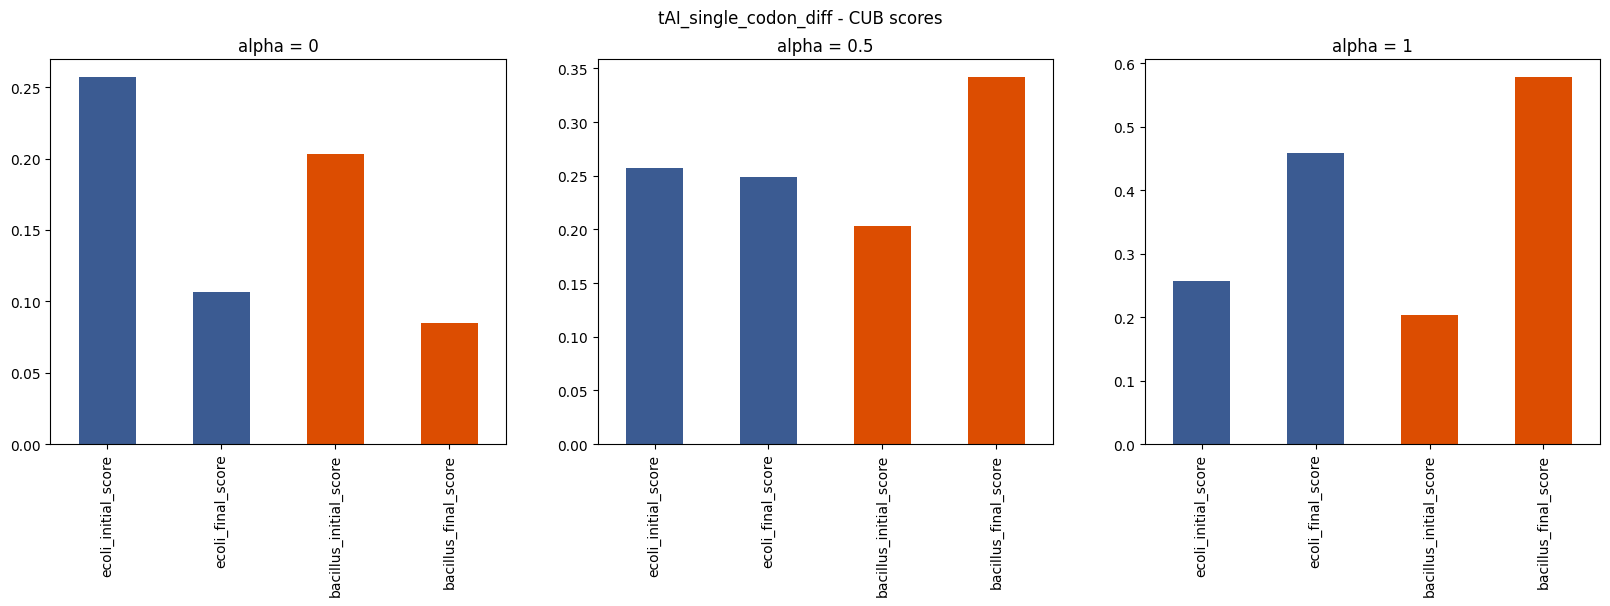

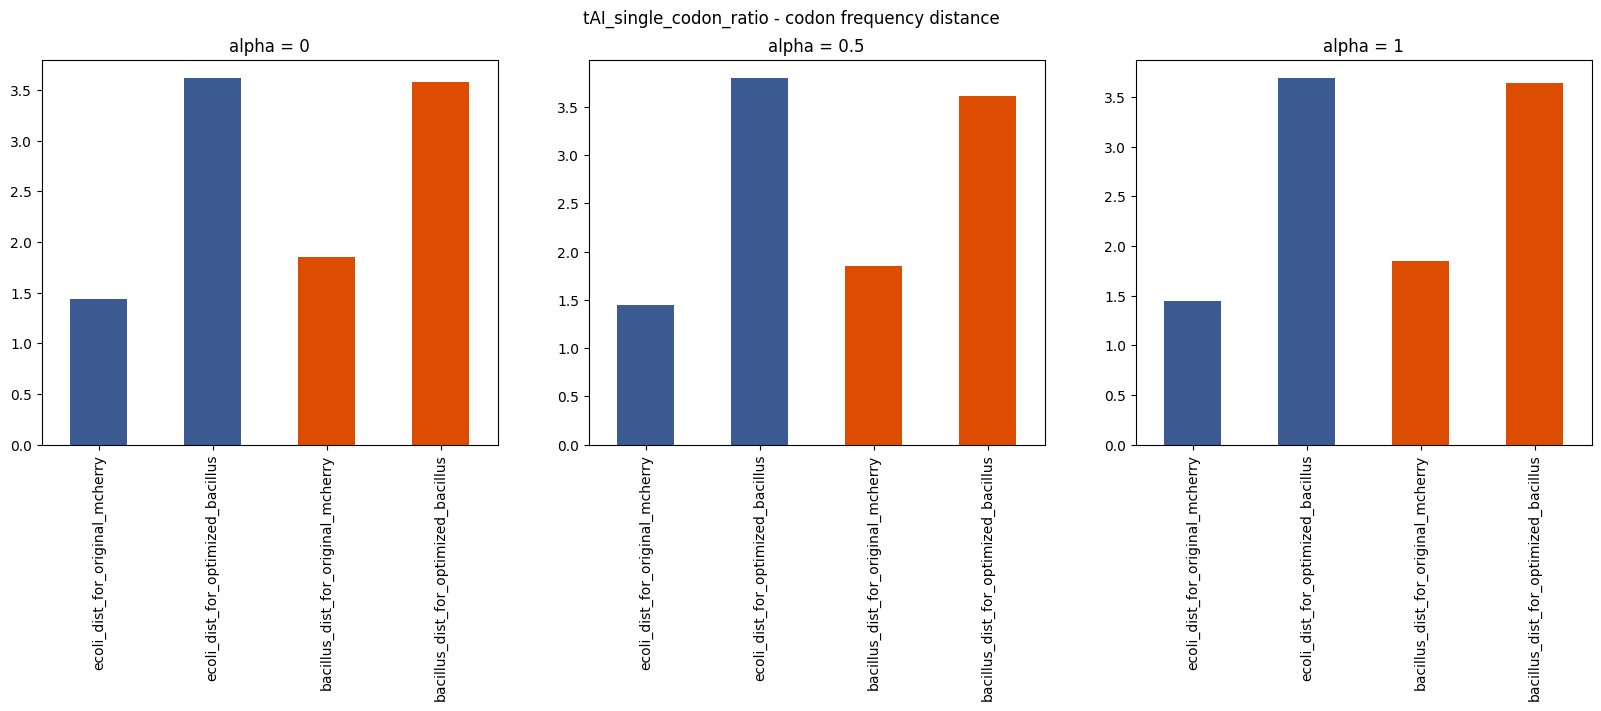

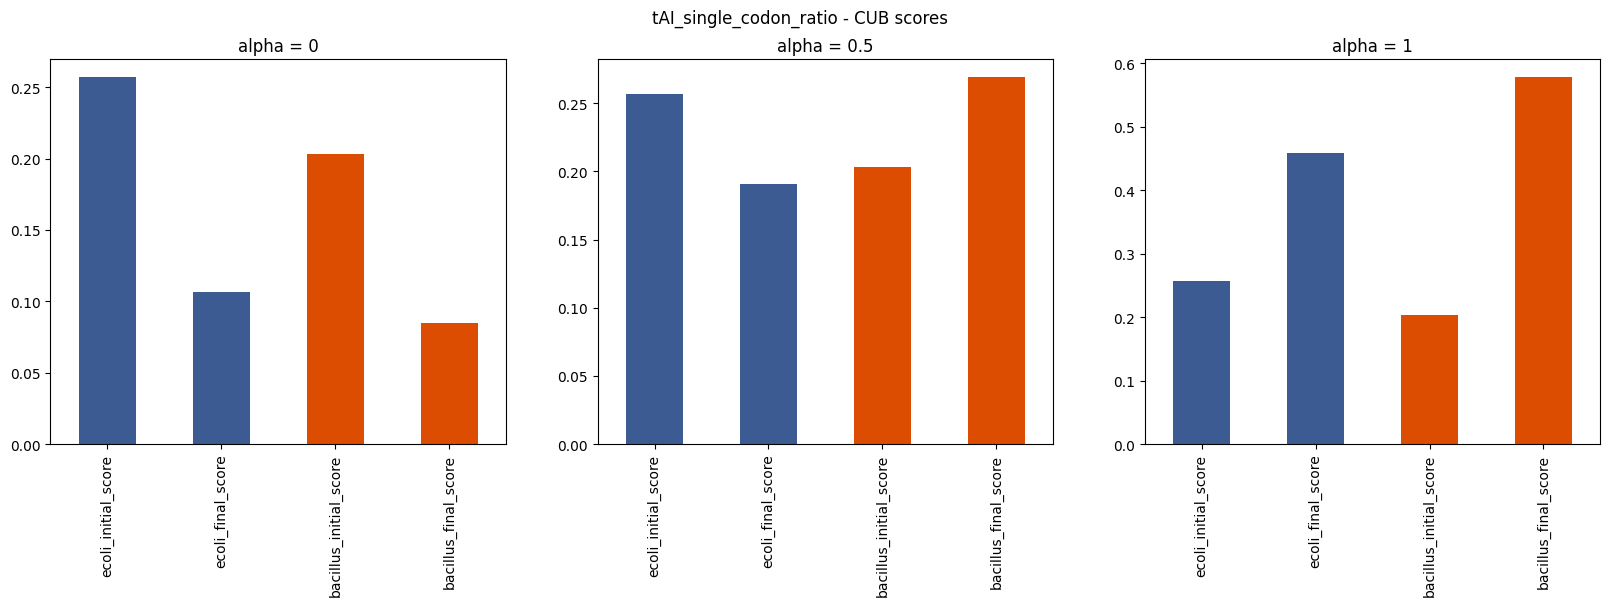

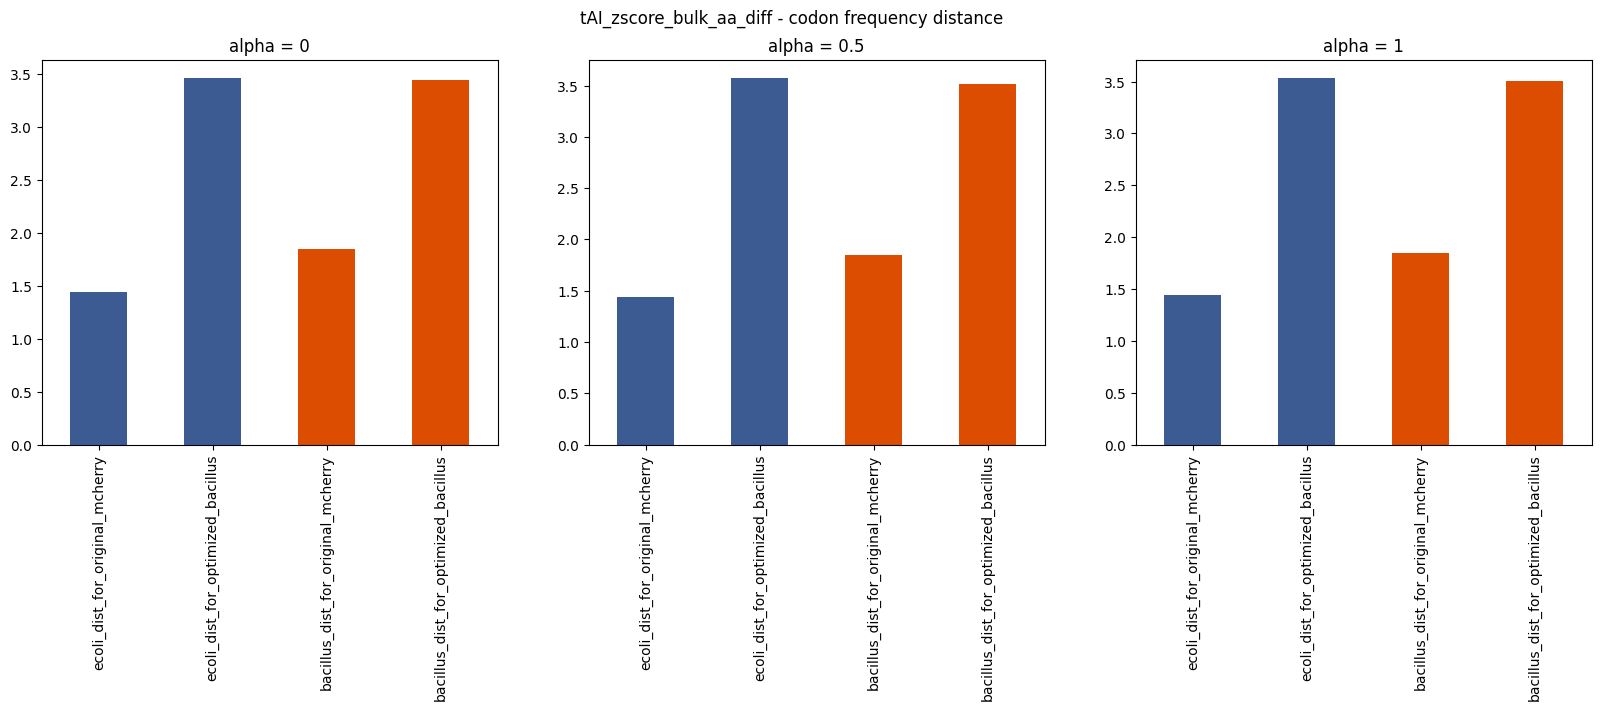

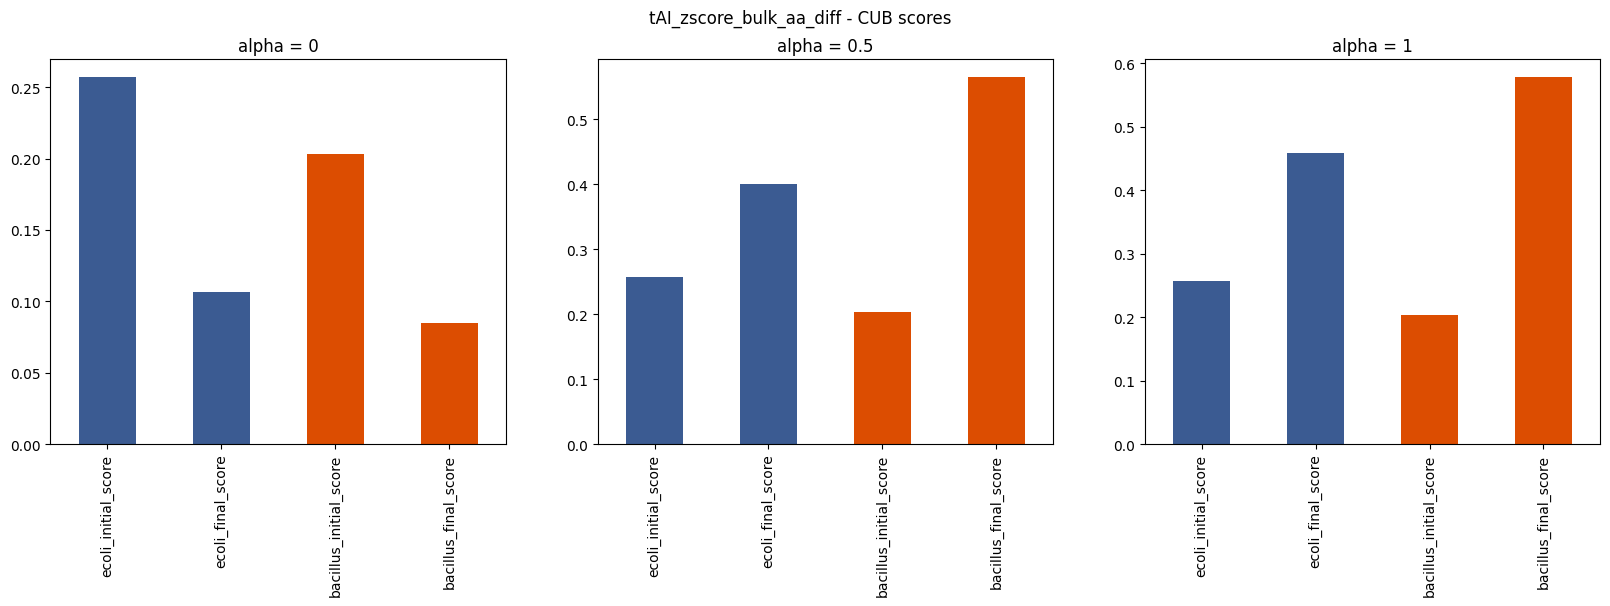

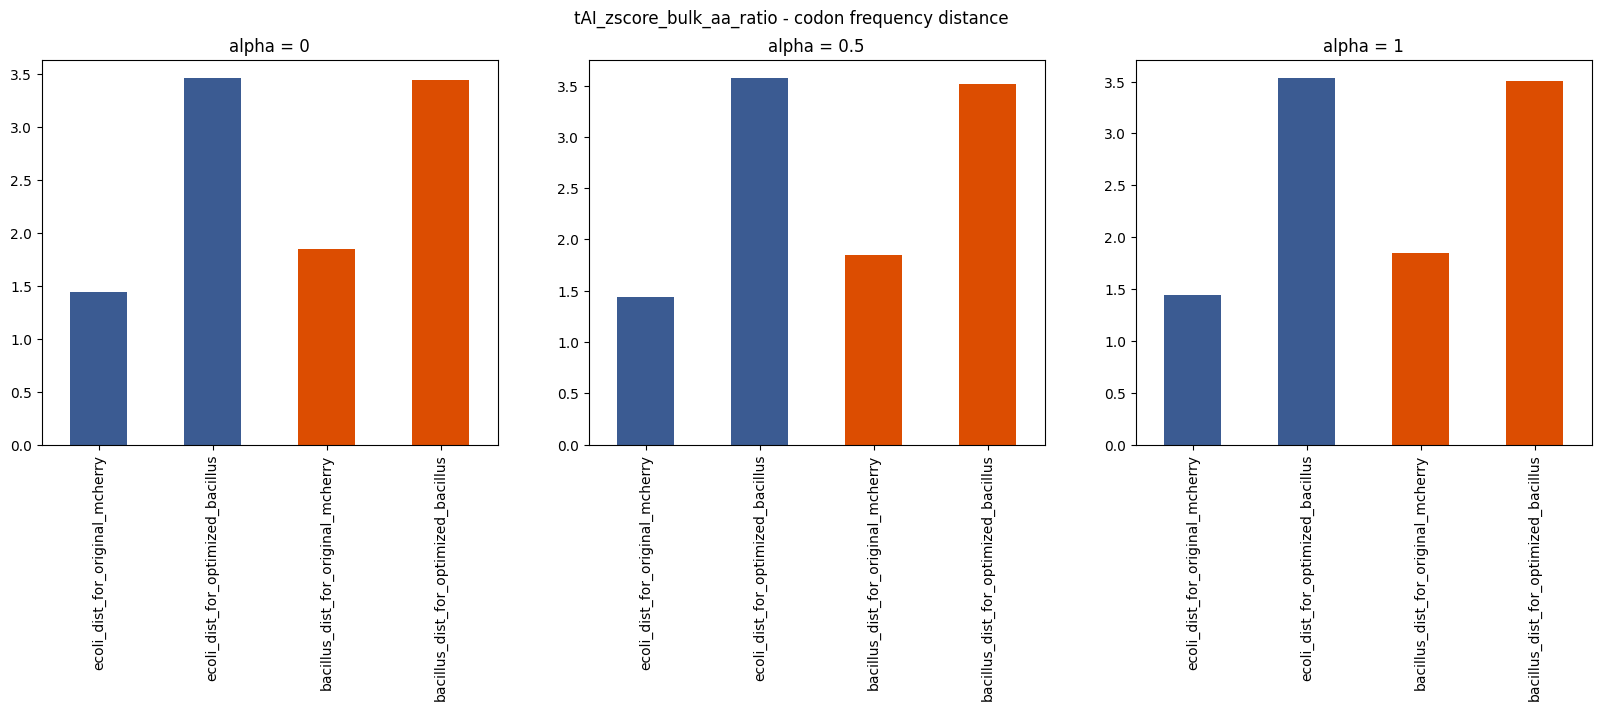

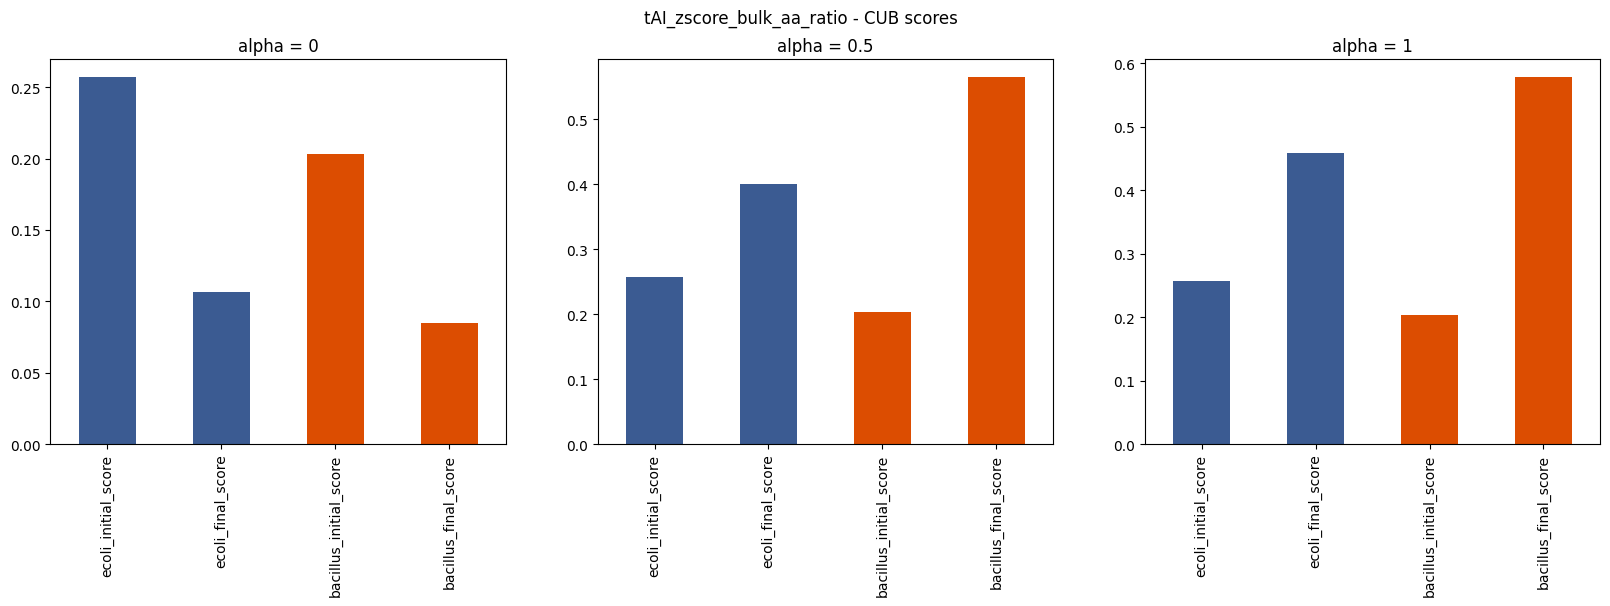

In [66]:
my_colors = ['#3b5b92', '#3b5b92', '#dc4d01', '#dc4d01'] 
for q in range(cub_bacillus_opt_greater_alpha_variants_dataframe.shape[0]):

    fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(20,5))
    fig.suptitle(greater_alpha_bacillus_opt_variants_dataframe.iloc[q,0] + " - codon frequency distance")
    lower_alpha_bacillus_opt_variants_dataframe.iloc[q,1:].plot(x="variant", kind="bar", ax=axes[0], stacked=True, color=my_colors)
    axes[0].set_title("alpha = 0")
    bacillus_opt_variants_dataframe.iloc[q,1:].plot(x="variant", kind="bar", ax=axes[1], stacked=True, color=my_colors)
    axes[1].set_title("alpha = 0.5")
    greater_alpha_bacillus_opt_variants_dataframe.iloc[q,1:].plot(x="variant", kind="bar", ax=axes[2], stacked=True, color=my_colors)
    axes[2].set_title("alpha = 1")


    fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(20,5))
    fig.suptitle(cub_bacillus_opt_greater_alpha_variants_dataframe.iloc[q,0] + " - CUB scores")
    cub_bacillus_opt_lower_alpha_variants_dataframe.iloc[q,1:].plot(x="variant", kind="bar", ax=axes[0], stacked=True, color=my_colors)
    axes[0].set_title("alpha = 0")
    cub_bacillus_opt_variants_dataframe.iloc[q,1:].plot(x="variant", kind="bar", ax=axes[1], stacked=True, color=my_colors)
    axes[1].set_title("alpha = 0.5")
    cub_bacillus_opt_greater_alpha_variants_dataframe.iloc[q,1:].plot(x="variant", kind="bar", ax=axes[2], stacked=True, color=my_colors)
    axes[2].set_title("alpha = 1")